### María Sofía Álvarez - Brenda Barahona - Álvaro Plata
<h1 align='center'>Proyecto 1: Analítica de textos - LSTM</h1>

In [19]:
import keras
import warnings
import datetime
import sent2vec
import fasttext
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dropout
from gensim.models import FastText
from keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from pandas.core.common import SettingWithCopyWarning
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from keras.layers import LSTM, Dense, Embedding, TextVectorization, Input
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay

In [2]:
%matplotlib inline

## Algoritmo elegido: LSTM

El tercer algoritmo que usaremos para este problema será LSTM.

La LSTM (Long-Short Term Memory) es un tipo de red neuronal recurrente (RNN, por sus siglas en inglés) que se desempeña mejor que las RNN tradicionales en términos de memoria [1]. Una RNN es un tipo de red neuronal que permite a las salidas de capas previas ser utilizadas como entradas, teniendo estados ocultos [2].

Las LSTM tienen múltiples capas ocultas. A medida que se pasa a través de una capa, la información relevante se mantiene y la irrelevante se desecha en cada neurona (celda) individual [1]. Asimismo, las LSTM solucionan el problema de desvanecimiento de gradientes que las RNN enfrentan a menudo.

Las LSTM cuentan principalmente con 3 compuertas:
+ **FORGET Gate:** Esta compuerta es la responsable de decidir qué información se queda y cuál es irrelevante y debe descartarse. Para ello, utiliza la información que viene de la neurona anterior $h_{t-1}$ y la información de la celda actual, $x_t$. Sobre ellas, se corre una función sigmoide, $$S(x) = \frac{1}{1 + e^{-x}},$$ tal que los datos que tiendan a 0 son descartados por la red [1].
+ **INPUT Gate:** Esta compuerta actualiza el estado de la neurona y decide qué información es importante. Como la compuerta FORGET ayuda a descartar la información, la compuerta INPUT ayuda a encontrar la información importante y a almacenar ciertos datos relevantes en memoria. En este caso, la información de la neurona anterior, $h_{t-1}$ es pasada por una función de activación sigmoide, mientras que la información de la neurona actual $x_t$ se pasa por una función de activación de tangete hiperbólica: $$\tanh(x) = \frac{1 - e^{-2x}}{1 + e^{-2x}}.$$ Es importante resaltar que la función $\tanh$ ayuda a regular la red y a reducir el sesgo de la misma [1].
+ **OUTPUT Gate:** Tras multiplicar el estado actual de la neurona con lo que se obtiene de la compuerta FORGET, lo cual permite eliminar cierta información si la compuerta FORGET arroja pesos de 0, debe decidirse cual será el estado de la siguiente celda. La información de $h_{t-1}$ y $x_t$ se pasa a través de una función sigmoide, el cual es a su vez pasado por una función de tangente hiperbólica, y ambos resultados se mltiplican para decidir la información que llevará el estado oculto [1]. 

A continuación, puede verse la gráfica de las funciones $\tanh$ y sigmoide:

<img src="https://www.researchgate.net/profile/Muhammad-Hamdan-8/publication/327435257/figure/fig4/AS:742898131812354@1554132125449/Activation-Functions-ReLU-Tanh-Sigmoid.ppm" />

Note que también se encuentra la función de activación ReLU (Regularized Linear Unit), muy popular en las aplicaciones de Machine y Deep Learning.

Asimismo, puede verse una representación esquemática (obtenida de [3]) de la estructura de cada una de las compuertas:

<img src="https://www.researchgate.net/profile/Xuan_Hien_Le2/publication/334268507/figure/fig8/AS:788364231987201@1564972088814/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan.png" width=50% />

En la imagen podemos ver las funciones de activación usadas en cada celda LSTM (sigmoide y tangente hiperbólica), así como sus entradas, salidas y compuertas.

---
Leamos los datos traidos de la fase anterior:

In [3]:
datos_train = pd.read_csv('train_Data.csv')
datos_test = pd.read_csv('test_Data.csv')
datos_train.sample(5)

,Unnamed: 0,problems_described,tokenized_abstracts,non_tokenized_abstracts,non_tokenized_entities,tokenized_entities
5733,7957,2,"['surgic', 'hydatid', 'liver', 'experi', 'medi...",surgic hydatid liver experi medic record conse...,hydatid liver liver liver extrahepat liver hyd...,"['hydatid', 'liver', 'liver', 'liver', 'extrah..."
6477,10350,5,"['serum', 'tissu', 'magnesium', 'concentr', 'h...",serum tissu magnesium concentr heart failur se...,serum tissu magnesium heart ventricular magnes...,"['serum', 'tissu', 'magnesium', 'heart', 'vent..."
591,2654,5,"['muscl', 'biopsi', 'diagnosi', 'malign', 'hyp...",muscl biopsi diagnosi malign hyperthermia susc...,muscl biopsi malign hyperthermia muscl biopsi ...,"['muscl', 'biopsi', 'malign', 'hyperthermia', ..."
6082,1160,2,"['prospect', 'preval', 'esophag', 'chest', 'pa...",prospect preval esophag chest pain refer elect...,esophag chest cardiac myocardi esophag chest c...,"['esophag', 'chest', 'cardiac', 'myocardi', 'e..."
6289,355,3,"['comparison', 'hybrid', 'uncement', 'total', ...",comparison hybrid uncement total hip replac re...,acetabular cement femor thigh femor cement fem...,"['acetabular', 'cement', 'femor', 'thigh', 'fe..."


## Vectorización

Una vez elegido el modelo, procedemos a hacer la vectorización de los datos que obtuvimos en la fase de preprocesamiento. Como dijimos, el preprocesamiento para los algoritmos basados en secuencias, como las redes neuronales, es diferente. En este caso, optaré por usar dos opciones de embedding. Describo una tercera, pero no la usaré porque es muy costosa computacionalmente.

* **BioSentVec:** Módulo basado en las investigaciones de Zhang et. al [4]. Similar a Sent2Vec (algoritmo de embedding de Google), está basado en la librería ```fast_text```de Facebook para embeddings y clasificación de textos. La librería utiliza las base de datos de PubMed y las notas clínicas de MIMIC-III Clinical Database como corpus para entrenar una red que genera vectores de 700 dimensiones. El procedimiento para usar este modelo es largo y tedioso, pero puede encontrarse anexo a este laboratorio. Debido a que la dimensionalidad sigue siendo elevada, para evitar overfitting, solamente se usará sobre los abstracts y no sobre las entities.
* **BioWordVec:** Desarrollada por los mismos investigadores de [4], es un embedding muy usado en contextos biomédicos. Como es sobre palabras únicamente, preferimos utilizarlo para las entidades médicas extraídas en el preprocesamiento
* **Keras Vectorizer y Keras Embedding:** Al usar redes neuronales con la librería Keras, existe una capa propia de ```Vectorizing``` y ```Embedding```. Esta técnica requiere de muchos más hiperparámetros y no se espera que tenga un mejor rendimiento, ya que no es especialmente diseñada para el contexto médico sino para cualquiera en general. Deberíamos controlar el tamaño de los vectores y la cantidad de neuronas en la capa de embedding, por ejemplo, lo cual es lento (considerando que tenemos los hiperparámetros de LSTM también).

Podemos probar esta técnica de vectorización también. Se probará sobre las palabras de entidades puesto que puede tardarse mucho sobre las historias clínicas.

Cargamos la librería de BioWordVec:

In [4]:
model_path = 'BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


Por la forma en la que funciona la librería, no podemos poner este paso en una Pipeline. Por lo tanto, lo que hacemos es generar los embeddings

In [5]:
embedded_abstracts = model.embed_sentences(datos_train['non_tokenized_abstracts'])

In [6]:
%store embedded_abstracts

Stored 'embedded_abstracts' (ndarray)


In [7]:
embedded_abstracts.shape

(9600, 700)

¡Note que la dimensionalidad de estos datos es de 700! Como vimos en el preprocesamiento, esto puede ser mucho para las entidades. Por lo tanto, para ellas, usaremos el embedding de ```sk-learn```.

## Manejo de desbalanceo de las clases

Ahora, uno de los mayores problemas de la clasificación es el contexto desbalanceado. Una opción sería reducir el conjunto de datos hasta que todas las clases queden con un número de abstracts igual al tamaño de la clase de menor cantidad de abstracts. No obstante, por lo general la idea es no reducir el conjunto de datos. Otra opción, como en los algoritmos anteriores, sería usar SMOTE. No obstante, esto es computacionalmente muy costoso para la red.

Lo que sí podemos hacer es considerar pesos. Así, el modelo podrá prestar mayor atención a las clases minoritarias. Para ello, usaremos la librería de <code>sk-learn</code> y lo pasaremos como un objeto al modelo que construiremos más adelante:

In [45]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(datos_train['problems_described']), 
                y = datos_train['problems_described'])
train_class_weights_ = dict(enumerate(class_weights, start=1))
train_class_weights = dict(enumerate(class_weights))

Podemos ver los pesos asociados a cada una de las clases, en orden ascendente:

In [46]:
train_class_weights_

{1: 0.912981455064194,
 2: 1.93158953722334,
 3: 1.5,
 4: 0.9462789551503203,
 5: 0.6011271133375078}

Como era de esperarse, recordando la gráfica del perfilamiento (mostrada más abajo), la clase con mayor peso es la 2, seguida de la clase 3. La clase mayoritaria (la 5) es la que presenta menores pesos.

<img src="images/img_preproc.png" width=40% />

Con esto, ya podemos proceder a realizar el modelamiento. 
## Modelo LSTM
Es importante mencionar que no hay un método estándar para la búsqueda de hiperparámetros en redes neuronales. Para ello, debemos hacer algunos *workarounds*. 

No obstante, antes de hacer el tuneo de hiperparámetros, en este tipo de modelos resulta más sencillo hacer un modelo base primero. Hagamos un modelo base usando el WordEmbedding de BioSentVec. 
### Modelo base: Usando BioSentVec
Consideremos un modelo base de dos capas LSTM, acompañadas de su capa de dropout (i.e. de pérdida). De acuerdo con [1], es importante que estos modelos estén acompañados de esta capa para evitar overfitting. Finalmente, consideramos una capa densa con función de activación <code>softmax</code>, que es la función de activación que se utiliza en contextos de clasificación.

In [36]:
embedded_abstracts_ = embedded_abstracts.reshape(-1, 1, embedded_abstracts.shape[1])
Y_train = datos_train['problems_described']
Y_train_ = keras.utils.np_utils.to_categorical(Y_train)[:,1:]

In [22]:
output = 5 # Cantidad de clases del problema
# ------------------LSTM-----------------------
# Inicializamos el modelo
lstm_base = Sequential(name='LSTM_basico') 
# Agregamos una capa LSTM con el tamanio de entrada de los embedded abstracts y 16 neuronas en la capa
lstm_base.add(LSTM(units=16, return_sequences=True, 
                    input_shape=(1, embedded_abstracts_.shape[2])))
# Agregamos la primera capa de dropout
lstm_base.add(Dropout(0.2))
# Agregamos una segunda capa LSTM con 16 neuronas
lstm_base.add(LSTM(units=16, return_sequences=False))
# Con su respectiva capa de dropout
lstm_base.add(Dropout(0.2))
# Definimos la capa de salida
lstm_base.add(Dense(output, activation='softmax'))

Antes de ver nuestro modelo totalmente construido, conviene discutir un poco lo que acabamos de hacer. Inicializamos el modelo creando un modelo secuencial. Posteriormente, agregamos una capa LSTM con su respectiva capa de dropout. Esta es una capa de regularización, que hace que se aprenda una fracción de los pesos en la red. Para redes grandes, se recomienda un dropout $p=0.5$ , la cual corresponde a la máxima regularización. Esto también lo ajustaremos como hiperparámetro, pero es un buen punto de partida para nuestro primer modelo [5]. Agregamos otra capa de LSTM con su respectiva capa de dropout y, finalmente, diseñamos la capa de salida con 5 neuronas: pues tenemos 5 clases.

Revisando la documentación de <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM"/> la capa LSTM</a>, es posible ver que hay muchos posibles hiperparámetros a configurar. No obstante, hay algunos que NO deben ser modificados, de acuerdo con la revisión teórica realizada más arriba, como la función de activación (que debe ser $\tanh$) y la función de activación recurrente (que debe ser sigmoide). Asimismo, hay otros parámetros que están ajustados para la mayoría de aplicaciones de ML, como el inicializador del kernel (que es globot) y del kernel recurrente (que es ortogonal), por defecto. Asimismo, hay otros hiperparámetros que permiten hacer modificaciones sobre el modelo, como ```go_backwards```. Este puede ser útil para la construcción de redes recurrentes bidireccionales. Así las cosas, vemos que, dados los hiperparámetros de esta capa, en realidad la más fundamental a determinar (y para no tener un gran costo computacional - pues el espacio de búsqueda sería inmenso -) es: 
* **units:** Indica el número de neuronas de la capa. En el modelo inicial, usamos 16. Pero puede ser cualquier número entero positivo.
* El número de capas, aunque no es un hiperparámetro de esta capa, es un hiperparámetro del modelo.

Estos hiperparámetros, junto con la tasa de dropout, serán tuneados más adelante. Veamos el resumen del modelo:

In [12]:
lstm_base.summary()

Model: "LSTM_basico"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             45888     
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 48,085
Trainable params: 48,085
Non-trainable params: 0
_________________________________________________________________


Ahora, debemos elegir una métrica, una función de pérdida y un optimizador. En cuanto a la función de pérdida, la que se usa con frecuencia en problemas de clasificación es la de entropía cruzada. De hecho, se recomienda no cambiarla, a menos de que se tenga una razón lo suficientemente fuerte para hacerlo, pues es la función de pérdida preferida en el marco de la máxima verosimilitud. Para problemas multiclase, se utiliza entropía cruzada categórica: sparse_categorical_crossentropy [6].

En el caso del optimizador, elegimos adam. Por lo general, este es el que mejores resultados presenta, de acuerdo con la literatura. Asimismo, nos quitamos de encima el ajustar un hiperparámetro extra (la tasa de aprendizaje), pues los algoritmos adaptativos como Adam van ajustando esta tasa a medida que entrenan [7]. Últimamente se ha visto que SGD, acompañado de un buen learning rate, puede arrojar resultados excelentes también. No obstante, esto implica el ajuste de un hiperparámetro que, dada la complejidad del problema, puede ser muy costosa computacionalmente.

Asimismo, debemos definir la métrica que informa el éxito del modelo. En este caso elegimos la precisión como métrica, pues el usuario médico quiere clasificar tan bien como se pueda los abstracts en las enfermedades.

In [26]:
lstm_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[ keras.metrics.Precision(name='precision')])

### Control de la complejidad y los tiempos de procesamiento
Una forma de controlar la complejidad y los tiempos de procesamiento es mediante el uso de callbacks. Estas son acciones durante las etapas del entrenamiento.

De acuerdo con la documentación de Tensorflow, encontramos dos callbacks que consideramos útiles para este laboratorio. Primero, consideramos EarlyStopping. En este caso, ponemos la cantidad monitoreada como la medida que tomamos a la pérdida (val_loss) tal que, si después de 3 épocas no ha mejorado, entonces pare el entrenamiento y la actualización de los pesos. En este caso, monitoreamos sobre el error de validación.

Finalmente, ModelCheckpoint permite guardar el modelo con mejor desempeño sobre validación.

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', baseline=None)
model_checkpoint = ModelCheckpoint('base_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

Finalmente, hacemos fit al modelo:

In [28]:
history_base = lstm_base.fit(embedded_abstracts_, Y_train_, validation_split=0.2, epochs= 100, callbacks=callbacks, class_weight=train_class_weights)

Epoch 1/100
223/240 [==========================>...] - ETA: 0s - loss: 1.3341 - precision: 0.6811
Epoch 1: val_loss did not improve from 0.92010
240/240 [==============================] - 2s 2ms/step - loss: 1.3133 - precision: 0.6629 - val_loss: 1.0806 - val_precision: 0.6759
Epoch 2/100
216/240 [==========================>...] - ETA: 0s - loss: 0.9649 - precision: 0.6401
Epoch 2: val_loss did not improve from 0.92010
240/240 [==============================] - 1s 2ms/step - loss: 0.9612 - precision: 0.6411 - val_loss: 1.0182 - val_precision: 0.6458
Epoch 3/100
219/240 [==========================>...] - ETA: 0s - loss: 0.8991 - precision: 0.6403
Epoch 3: val_loss did not improve from 0.92010
240/240 [==============================] - 1s 2ms/step - loss: 0.8973 - precision: 0.6394 - val_loss: 0.9781 - val_precision: 0.6479
Epoch 4/100
218/240 [==========================>...] - ETA: 0s - loss: 0.8682 - precision: 0.6464
Epoch 4: val_loss did not improve from 0.92010
240/240 [============

Podmeos ver los plots de precisión y pérdida para este modelo inicial:

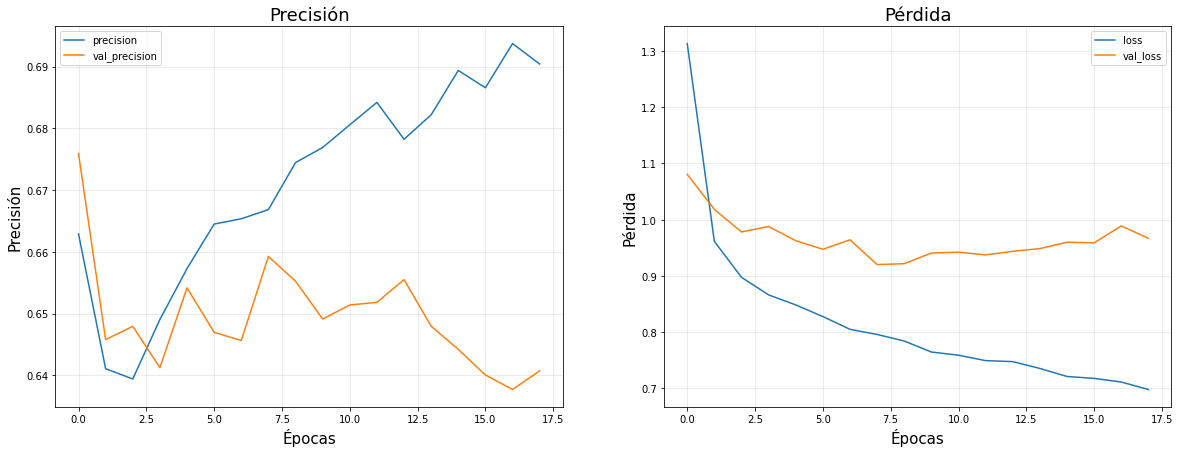

In [29]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Precision
plt.plot(history_base.epoch, history_base.history['precision'], label = "precision")
plt.plot(history_base.epoch, history_base.history['val_precision'], label = "val_precision")

plt.title("Precisión", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Precisión", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Pérdida
fig.add_subplot(122)

plt.plot(history_base.epoch, history_base.history['loss'], label="loss")
plt.plot(history_base.epoch, history_base.history['val_loss'], label = "val_loss")


plt.title("Pérdida", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Pérdida", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

De la salida por consola, podemos ver que el modelo paró tempranamente en la época 18. En este caso, suponemos que desde esta época el modelo empezaría a hacer overfitting. De hecho, de la gráfica de pérdida podemos ver que se empieza a llegar a una meseta. Lo que nos sugiere es que el modelo no encuentra forma de optimizar más los parámetros. Así las cosas, nuestro modelo no logra generalizar más sobre el conjunto de datos, o se queda atrapado en la optimización.

Asimismo, vemos que la precisión no es muy elevada. Pensamos que esto se debe a la cantidad de neuronas que utilizamos. Intentamos ahora ajustar hiperparámetros a ver si logramos una mejor precisión. Primero, lo intentaremos sobre las vectorizaciones usando el algoritmo biomédico.

### Modelo con ajuste de hiperparámetros usando BioSentVec

Hay muchos hiperparámetros por afinar en el modelo que en principio podríamos seguir buscando mediante la función de GridSearch. Sin embargo, no es recomendable pues nos encontramos en un universo enorme de hiperparámetros si deseamos hacer una búsqueda exhaustiva. Asimismo, podría usarse la función RandomizedSearchCV. No obstante, esta arroja algunos errores en el cálculo de las métricas y, por tanto, no funciona adecuadamente. Lo que hacemos es, entonces, construir nuestra propia función de búsqueda.

Los parámetros que son más importantes de ajustar son el número de neuronas por capa, el número total de capas y la tasa de dropout. Por economía de recursos computacionales, usamos el mismo número de neuronas en todos los casos y la misma tasa de Dropout para todas las capas. Definimos entonces una función que nos permita hacer esto a continuación

In [43]:
def LSTM_hiperparametros(config, x_train=embedded_abstracts_, y_train=Y_train_, is_ent=False):
    output = 5 # Tenemos 5 neuronas en la capa oculta pues son las 5 clases de salida
    # Extraigo los parametros
    first_add, second_add, third_add, nn, dropout = config
    possible_combinations = list(itertools.product(first_add, second_add, third_add, nn, dropout))
    
    print('La cantidad de combinaciones es: ', len(possible_combinations))
    print('\n')
    hist = []
    for i in range(0, len(possible_combinations)):
        first_add, second_add, third_add, nn, dropout = possible_combinations[i]
        print(f'Combinación {i+1}: \n')
        print('--------------------------------------------------------------------')
        # Inicializo la red
        clf = Sequential(name=f'Mi_Red_{i+1}')
        # Agrego la primera capa obligatoria LSTM
        clf.add(LSTM(units=nn, return_sequences=True, input_shape=(1, x_train.shape[2])))
        # Agrego la primera capa Dropout
        clf.add(Dropout(dropout))
        # Agrego capa adicional, de ser necesario, con dropout
        if first_add:
            clf.add(LSTM(units=nn, return_sequences=True))
            clf.add(Dropout(dropout))
        # Agrego segunda capa adicional, con dropout
        if second_add:
            clf.add(LSTM(units=nn, return_sequences=True))
            clf.add(Dropout(dropout))
        # Agrego tercera capa adicional, con dropout
        if third_add:
            clf.add(LSTM(units=nn, return_sequences=True))
            clf.add(Dropout(dropout))
        # Agrego una ultima capa LSTM, con dropout
        clf.add(LSTM(units=nn, return_sequences=False))
        clf.add(Dropout(dropout))
        # Agrego la capa de clasificacion
        clf.add(Dense(output, activation='softmax'))
        # Compilo el modelo
        clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.Precision(name='precision')]) # Valores por defecto
        # Agrego un callback para almacenar el mejor modelo
        if is_ent:
            model_checkpoint = ModelCheckpoint(f'model_ent{i+1}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        else:
            model_checkpoint = ModelCheckpoint(f'model_{i+1}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        # Hago fit
        history_base = clf.fit(x_train, y_train, validation_split=0.2, epochs= 70, callbacks=[early_stopping, model_checkpoint], class_weight=train_class_weights)
        # Mido la precision
        train_precision = clf.evaluate(x_train, y_train, verbose=1)
        hist.append(list((f'model_{i+1}.h5', history_base, first_add, second_add, third_add, nn, dropout, train_precision)))
        
        print(f'Combinación {str(i)} = {possible_combinations[i]} \n precision train: {train_precision}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

Con esto, ya podemos definir nuestra grilla de hiperparámetros.
Hablemos un poco de ellos. En este caso, queremos encontrar los mejores hiperparámetros para el número de capas, de neuronas, y la mejor tasa de dropout. Consideramos solo tres capas, así como neuronas entre 8, 16, 32 y 64 para evitar que el modelo haga overfitting. Para el dropout, evaluamos valores entre 0.1, 0.25 y 0.5, siendo 0.5 el máximo dropout.

In [18]:
config = [[True, False], [True, False], [True, False], [8, 16, 32, 64], [0.1, 0.25, 0.5]]  
hist = LSTM_hiperparametros(config)  

La cantidad de combinaciones es:  96


Combinación 1: 

--------------------------------------------------------------------
Epoch 1/70
224/240 [===========================>..] - ETA: 0s - loss: 1.5706 - precision: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.40126, saving model to model_1.h5
240/240 [==============================] - 6s 8ms/step - loss: 1.5577 - precision: 0.0000e+00 - val_loss: 1.4013 - val_precision: 0.0000e+00
Epoch 2/70
234/240 [============================>.] - ETA: 0s - loss: 1.3109 - precision: 0.0000e+00
Epoch 2: val_loss improved from 1.40126 to 1.32364, saving model to model_1.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.3111 - precision: 0.0000e+00 - val_loss: 1.3236 - val_precision: 0.0000e+00
Epoch 3/70
229/240 [===========================>..] - ETA: 0s - loss: 1.2681 - precision: 0.0000e+00
Epoch 3: val_loss improved from 1.32364 to 1.29586, saving model to model_1.h5
240/240 [==============================] - 1s 3ms/step - 

230/240 [===========================>..] - ETA: 0s - loss: 0.8486 - precision: 0.6330
Epoch 28: val_loss did not improve from 1.08918
240/240 [==============================] - 1s 3ms/step - loss: 0.8484 - precision: 0.6333 - val_loss: 1.0914 - val_precision: 0.5898
Epoch 29/70
234/240 [============================>.] - ETA: 0s - loss: 0.8374 - precision: 0.6389
Epoch 29: val_loss did not improve from 1.08918
240/240 [==============================] - 1s 3ms/step - loss: 0.8366 - precision: 0.6398 - val_loss: 1.1004 - val_precision: 0.5853
Epoch 30/70
231/240 [===========================>..] - ETA: 0s - loss: 0.8384 - precision: 0.6396
Epoch 30: val_loss did not improve from 1.08918
240/240 [==============================] - 1s 3ms/step - loss: 0.8356 - precision: 0.6407 - val_loss: 1.0941 - val_precision: 0.5864
Epoch 31/70
234/240 [============================>.] - ETA: 0s - loss: 0.8262 - precision: 0.6417
Epoch 31: val_loss did not improve from 1.08918
240/240 [====================

Epoch 22/70
227/240 [===========================>..] - ETA: 0s - loss: 1.0759 - precision: 0.6206
Epoch 22: val_loss improved from 1.16444 to 1.16336, saving model to model_2.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.0762 - precision: 0.6198 - val_loss: 1.1634 - val_precision: 0.6152
Epoch 23/70
239/240 [============================>.] - ETA: 0s - loss: 1.0733 - precision: 0.6196
Epoch 23: val_loss did not improve from 1.16336
240/240 [==============================] - 1s 4ms/step - loss: 1.0732 - precision: 0.6195 - val_loss: 1.1792 - val_precision: 0.5913
Epoch 24/70
229/240 [===========================>..] - ETA: 0s - loss: 1.0647 - precision: 0.6186
Epoch 24: val_loss improved from 1.16336 to 1.15992, saving model to model_2.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.0627 - precision: 0.6210 - val_loss: 1.1599 - val_precision: 0.5784
Epoch 25/70
232/240 [============================>.] - ETA: 0s - loss: 1.0475 - precision: 0.6136
E

Epoch 11/70
224/240 [===========================>..] - ETA: 0s - loss: 1.2882 - precision: 0.5747
Epoch 11: val_loss improved from 1.27722 to 1.25793, saving model to model_3.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2898 - precision: 0.5737 - val_loss: 1.2579 - val_precision: 0.7565
Epoch 12/70
235/240 [============================>.] - ETA: 0s - loss: 1.2698 - precision: 0.5989
Epoch 12: val_loss did not improve from 1.25793
240/240 [==============================] - 1s 3ms/step - loss: 1.2694 - precision: 0.5978 - val_loss: 1.2597 - val_precision: 0.7344
Epoch 13/70
226/240 [===========================>..] - ETA: 0s - loss: 1.2798 - precision: 0.5699
Epoch 13: val_loss improved from 1.25793 to 1.25497, saving model to model_3.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2778 - precision: 0.5697 - val_loss: 1.2550 - val_precision: 0.7280
Epoch 14/70
223/240 [==========================>...] - ETA: 0s - loss: 1.2695 - precision: 0.6053
E

Epoch 39/70
237/240 [============================>.] - ETA: 0s - loss: 1.1931 - precision: 0.5652
Epoch 39: val_loss did not improve from 1.17568
240/240 [==============================] - 1s 3ms/step - loss: 1.1920 - precision: 0.5667 - val_loss: 1.1800 - val_precision: 0.6220
Epoch 40/70
238/240 [============================>.] - ETA: 0s - loss: 1.1547 - precision: 0.5934
Epoch 40: val_loss did not improve from 1.17568
240/240 [==============================] - 1s 3ms/step - loss: 1.1554 - precision: 0.5926 - val_loss: 1.1886 - val_precision: 0.6238
Epoch 40: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 1.1228 - precision: 0.6473
Combinación 2 = (True, True, True, 8, 0.5) 
 precision train: [1.1228073835372925, 0.6473127603530884]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
-----------------

Epoch 8/70
233/240 [============================>.] - ETA: 0s - loss: 1.2178 - precision: 0.6927
Epoch 8: val_loss improved from 1.17938 to 1.17068, saving model to model_6.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.2194 - precision: 0.6930 - val_loss: 1.1707 - val_precision: 0.6918
Epoch 9/70
233/240 [============================>.] - ETA: 0s - loss: 1.2158 - precision: 0.6917
Epoch 9: val_loss improved from 1.17068 to 1.16659, saving model to model_6.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2165 - precision: 0.6910 - val_loss: 1.1666 - val_precision: 0.7046
Epoch 10/70
232/240 [============================>.] - ETA: 0s - loss: 1.2079 - precision: 0.6884
Epoch 10: val_loss did not improve from 1.16659
240/240 [==============================] - 1s 3ms/step - loss: 1.2062 - precision: 0.6920 - val_loss: 1.1666 - val_precision: 0.6954
Epoch 11/70
240/240 [==============================] - ETA: 0s - loss: 1.1950 - precision: 0.6973
Epoch

240/240 [==============================] - 1s 4ms/step - loss: 0.9700 - precision: 0.6329 - val_loss: 1.0485 - val_precision: 0.6318
Epoch 6/70
237/240 [============================>.] - ETA: 0s - loss: 0.9207 - precision: 0.6222
Epoch 6: val_loss improved from 1.04847 to 1.04422, saving model to model_7.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.9191 - precision: 0.6225 - val_loss: 1.0442 - val_precision: 0.6134
Epoch 7/70
233/240 [============================>.] - ETA: 0s - loss: 0.8774 - precision: 0.6248
Epoch 7: val_loss improved from 1.04422 to 1.04389, saving model to model_7.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.8797 - precision: 0.6241 - val_loss: 1.0439 - val_precision: 0.6108
Epoch 8/70
235/240 [============================>.] - ETA: 0s - loss: 0.8594 - precision: 0.6216
Epoch 8: val_loss improved from 1.04389 to 1.02792, saving model to model_7.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.8586 - p

240/240 [==============================] - 1s 3ms/step - loss: 0.9479 - precision: 0.6139 - val_loss: 1.1105 - val_precision: 0.5873
Epoch 12/70
235/240 [============================>.] - ETA: 0s - loss: 0.9198 - precision: 0.6172
Epoch 12: val_loss improved from 1.10136 to 1.07603, saving model to model_8.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.9194 - precision: 0.6171 - val_loss: 1.0760 - val_precision: 0.5943
Epoch 13/70
232/240 [============================>.] - ETA: 0s - loss: 0.8921 - precision: 0.6191
Epoch 13: val_loss did not improve from 1.07603
240/240 [==============================] - 1s 3ms/step - loss: 0.8925 - precision: 0.6183 - val_loss: 1.0913 - val_precision: 0.5872
Epoch 14/70
237/240 [============================>.] - ETA: 0s - loss: 0.8772 - precision: 0.6216
Epoch 14: val_loss improved from 1.07603 to 1.06519, saving model to model_8.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.8776 - precision: 0.6209 - val_los

Epoch 4/70
236/240 [============================>.] - ETA: 0s - loss: 1.1358 - precision: 0.6293
Epoch 4: val_loss improved from 1.12812 to 1.11219, saving model to model_9.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.1335 - precision: 0.6296 - val_loss: 1.1122 - val_precision: 0.6240
Epoch 5/70
235/240 [============================>.] - ETA: 0s - loss: 1.0718 - precision: 0.6255
Epoch 5: val_loss improved from 1.11219 to 1.07592, saving model to model_9.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.0713 - precision: 0.6259 - val_loss: 1.0759 - val_precision: 0.6204
Epoch 6/70
237/240 [============================>.] - ETA: 0s - loss: 1.0251 - precision: 0.6057
Epoch 6: val_loss improved from 1.07592 to 1.06088, saving model to model_9.h5
240/240 [==============================] - 1s 4ms/step - loss: 1.0262 - precision: 0.6048 - val_loss: 1.0609 - val_precision: 0.5957
Epoch 7/70
232/240 [============================>.] - ETA: 0s - loss: 1.0

240/240 [==============================] - 1s 4ms/step - loss: 0.7588 - precision: 0.6589 - val_loss: 1.0358 - val_precision: 0.6104
Epoch 14/70
240/240 [==============================] - ETA: 0s - loss: 0.7384 - precision: 0.6659
Epoch 14: val_loss did not improve from 1.00164
240/240 [==============================] - 1s 4ms/step - loss: 0.7384 - precision: 0.6659 - val_loss: 1.0154 - val_precision: 0.6235
Epoch 15/70
239/240 [============================>.] - ETA: 0s - loss: 0.7296 - precision: 0.6706
Epoch 15: val_loss did not improve from 1.00164
240/240 [==============================] - 1s 4ms/step - loss: 0.7294 - precision: 0.6702 - val_loss: 1.0089 - val_precision: 0.6213
Epoch 16/70
238/240 [============================>.] - ETA: 0s - loss: 0.7116 - precision: 0.6741
Epoch 16: val_loss did not improve from 1.00164
240/240 [==============================] - 1s 4ms/step - loss: 0.7108 - precision: 0.6745 - val_loss: 1.0101 - val_precision: 0.6239
Epoch 16: early stopping
300/3

229/240 [===========================>..] - ETA: 0s - loss: 0.8028 - precision: 0.6679
Epoch 20: val_loss did not improve from 1.01828
240/240 [==============================] - 1s 3ms/step - loss: 0.8015 - precision: 0.6700 - val_loss: 1.0395 - val_precision: 0.6222
Epoch 21/70
223/240 [==========================>...] - ETA: 0s - loss: 0.7901 - precision: 0.6712
Epoch 21: val_loss did not improve from 1.01828
240/240 [==============================] - 1s 3ms/step - loss: 0.7887 - precision: 0.6724 - val_loss: 1.0518 - val_precision: 0.6165
Epoch 22/70
221/240 [==========================>...] - ETA: 0s - loss: 0.7857 - precision: 0.6793
Epoch 22: val_loss did not improve from 1.01828
240/240 [==============================] - 1s 3ms/step - loss: 0.7877 - precision: 0.6762 - val_loss: 1.0497 - val_precision: 0.6160
Epoch 23/70
229/240 [===========================>..] - ETA: 0s - loss: 0.7817 - precision: 0.6773
Epoch 23: val_loss did not improve from 1.01828
240/240 [====================

240/240 [==============================] - 1s 6ms/step - loss: 0.9437 - precision: 0.6384 - val_loss: 1.0417 - val_precision: 0.6399
Epoch 21/70
229/240 [===========================>..] - ETA: 0s - loss: 0.9400 - precision: 0.6362
Epoch 21: val_loss did not improve from 1.04173
240/240 [==============================] - 1s 3ms/step - loss: 0.9395 - precision: 0.6367 - val_loss: 1.0519 - val_precision: 0.6284
Epoch 22/70
236/240 [============================>.] - ETA: 0s - loss: 0.9159 - precision: 0.6463
Epoch 22: val_loss did not improve from 1.04173
240/240 [==============================] - 1s 4ms/step - loss: 0.9148 - precision: 0.6469 - val_loss: 1.0596 - val_precision: 0.6232
Epoch 23/70
231/240 [===========================>..] - ETA: 0s - loss: 0.9196 - precision: 0.6316
Epoch 23: val_loss did not improve from 1.04173
240/240 [==============================] - 1s 3ms/step - loss: 0.9199 - precision: 0.6315 - val_loss: 1.0491 - val_precision: 0.6249
Epoch 24/70
227/240 [=========

Epoch 44/70
231/240 [===========================>..] - ETA: 0s - loss: 1.1350 - precision: 0.6287
Epoch 44: val_loss did not improve from 1.13566
240/240 [==============================] - 1s 3ms/step - loss: 1.1368 - precision: 0.6284 - val_loss: 1.1364 - val_precision: 0.6501
Epoch 45/70
230/240 [===========================>..] - ETA: 0s - loss: 1.1387 - precision: 0.6268
Epoch 45: val_loss did not improve from 1.13566
240/240 [==============================] - 1s 3ms/step - loss: 1.1371 - precision: 0.6286 - val_loss: 1.1416 - val_precision: 0.6364
Epoch 46/70
229/240 [===========================>..] - ETA: 0s - loss: 1.1377 - precision: 0.6265
Epoch 46: val_loss did not improve from 1.13566
240/240 [==============================] - 1s 3ms/step - loss: 1.1395 - precision: 0.6246 - val_loss: 1.1392 - val_precision: 0.6464
Epoch 47/70
227/240 [===========================>..] - ETA: 0s - loss: 1.1412 - precision: 0.6181
Epoch 47: val_loss did not improve from 1.13566
240/240 [========

240/240 [==============================] - 1s 3ms/step - loss: 1.0992 - precision: 0.6065 - val_loss: 1.0511 - val_precision: 0.6266
Epoch 8/70
223/240 [==========================>...] - ETA: 0s - loss: 1.0720 - precision: 0.6161
Epoch 8: val_loss improved from 1.05109 to 1.04478, saving model to model_18.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0710 - precision: 0.6155 - val_loss: 1.0448 - val_precision: 0.6159
Epoch 9/70
235/240 [============================>.] - ETA: 0s - loss: 1.0510 - precision: 0.6105
Epoch 9: val_loss improved from 1.04478 to 1.03818, saving model to model_18.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0525 - precision: 0.6092 - val_loss: 1.0382 - val_precision: 0.6145
Epoch 10/70
231/240 [===========================>..] - ETA: 0s - loss: 1.0508 - precision: 0.6031
Epoch 10: val_loss did not improve from 1.03818
240/240 [==============================] - 1s 3ms/step - loss: 1.0501 - precision: 0.6033 - val_loss:

Epoch 10/70
237/240 [============================>.] - ETA: 0s - loss: 0.7372 - precision: 0.6729
Epoch 10: val_loss did not improve from 0.97653
240/240 [==============================] - 1s 4ms/step - loss: 0.7362 - precision: 0.6734 - val_loss: 1.0106 - val_precision: 0.6200
Epoch 11/70
238/240 [============================>.] - ETA: 0s - loss: 0.7173 - precision: 0.6754
Epoch 11: val_loss did not improve from 0.97653
240/240 [==============================] - 1s 4ms/step - loss: 0.7162 - precision: 0.6765 - val_loss: 0.9798 - val_precision: 0.6331
Epoch 12/70
224/240 [===========================>..] - ETA: 0s - loss: 0.6967 - precision: 0.6806
Epoch 12: val_loss did not improve from 0.97653
240/240 [==============================] - 1s 3ms/step - loss: 0.7010 - precision: 0.6811 - val_loss: 1.0004 - val_precision: 0.6258
Epoch 13/70
233/240 [============================>.] - ETA: 0s - loss: 0.6879 - precision: 0.6878
Epoch 13: val_loss did not improve from 0.97653
240/240 [========

240/240 [==============================] - 1s 3ms/step - loss: 0.7800 - precision: 0.6543 - val_loss: 0.9793 - val_precision: 0.6375
Epoch 13/70
225/240 [===========================>..] - ETA: 0s - loss: 0.7738 - precision: 0.6591
Epoch 13: val_loss did not improve from 0.97927
240/240 [==============================] - 1s 3ms/step - loss: 0.7741 - precision: 0.6595 - val_loss: 1.0087 - val_precision: 0.6222
Epoch 14/70
223/240 [==========================>...] - ETA: 0s - loss: 0.7658 - precision: 0.6640
Epoch 14: val_loss did not improve from 0.97927
240/240 [==============================] - 1s 3ms/step - loss: 0.7645 - precision: 0.6643 - val_loss: 0.9950 - val_precision: 0.6320
Epoch 15/70
224/240 [===========================>..] - ETA: 0s - loss: 0.7569 - precision: 0.6666
Epoch 15: val_loss did not improve from 0.97927
240/240 [==============================] - 1s 3ms/step - loss: 0.7587 - precision: 0.6655 - val_loss: 1.0361 - val_precision: 0.6117
Epoch 16/70
227/240 [=========

Epoch 17/70
232/240 [============================>.] - ETA: 0s - loss: 0.8849 - precision: 0.6342
Epoch 17: val_loss did not improve from 1.01118
240/240 [==============================] - 1s 3ms/step - loss: 0.8846 - precision: 0.6338 - val_loss: 1.0347 - val_precision: 0.6108
Epoch 18/70
229/240 [===========================>..] - ETA: 0s - loss: 0.8842 - precision: 0.6323
Epoch 18: val_loss did not improve from 1.01118
240/240 [==============================] - 1s 3ms/step - loss: 0.8851 - precision: 0.6317 - val_loss: 1.0394 - val_precision: 0.6134
Epoch 19/70
228/240 [===========================>..] - ETA: 0s - loss: 0.8839 - precision: 0.6388
Epoch 19: val_loss did not improve from 1.01118
240/240 [==============================] - 1s 3ms/step - loss: 0.8823 - precision: 0.6371 - val_loss: 1.0186 - val_precision: 0.6351
Epoch 20/70
225/240 [===========================>..] - ETA: 0s - loss: 0.8784 - precision: 0.6379
Epoch 20: val_loss did not improve from 1.01118
240/240 [========

240/240 [==============================] - 1s 4ms/step - loss: 0.8991 - precision: 0.6182 - val_loss: 1.0043 - val_precision: 0.6226
Epoch 4/70
236/240 [============================>.] - ETA: 0s - loss: 0.8632 - precision: 0.6269
Epoch 4: val_loss improved from 1.00426 to 0.98274, saving model to model_23.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.8641 - precision: 0.6260 - val_loss: 0.9827 - val_precision: 0.6336
Epoch 5/70
238/240 [============================>.] - ETA: 0s - loss: 0.8472 - precision: 0.6328
Epoch 5: val_loss did not improve from 0.98274
240/240 [==============================] - 1s 3ms/step - loss: 0.8463 - precision: 0.6335 - val_loss: 0.9996 - val_precision: 0.6206
Epoch 6/70
229/240 [===========================>..] - ETA: 0s - loss: 0.8191 - precision: 0.6385
Epoch 6: val_loss improved from 0.98274 to 0.94839, saving model to model_23.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.8160 - precision: 0.6386 - val_loss: 0

Epoch 14/70
238/240 [============================>.] - ETA: 0s - loss: 0.7996 - precision: 0.6479
Epoch 14: val_loss did not improve from 0.98592
240/240 [==============================] - 1s 3ms/step - loss: 0.7995 - precision: 0.6481 - val_loss: 1.0237 - val_precision: 0.6093
Epoch 15/70
236/240 [============================>.] - ETA: 0s - loss: 0.7995 - precision: 0.6476
Epoch 15: val_loss did not improve from 0.98592
240/240 [==============================] - 1s 3ms/step - loss: 0.8002 - precision: 0.6470 - val_loss: 1.0043 - val_precision: 0.6186
Epoch 16/70
231/240 [===========================>..] - ETA: 0s - loss: 0.7869 - precision: 0.6483
Epoch 16: val_loss did not improve from 0.98592
240/240 [==============================] - 1s 4ms/step - loss: 0.7838 - precision: 0.6497 - val_loss: 1.0136 - val_precision: 0.6140
Epoch 17/70
226/240 [===========================>..] - ETA: 0s - loss: 0.7782 - precision: 0.6563
Epoch 17: val_loss did not improve from 0.98592
240/240 [========

240/240 [==============================] - 1s 3ms/step - loss: 1.0099 - precision: 0.6131 - val_loss: 1.0990 - val_precision: 0.5981
Epoch 21/70
225/240 [===========================>..] - ETA: 0s - loss: 1.0006 - precision: 0.6079
Epoch 21: val_loss improved from 1.09904 to 1.09536, saving model to model_26.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0027 - precision: 0.6094 - val_loss: 1.0954 - val_precision: 0.5909
Epoch 22/70
231/240 [===========================>..] - ETA: 0s - loss: 1.0103 - precision: 0.6059
Epoch 22: val_loss improved from 1.09536 to 1.08973, saving model to model_26.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0101 - precision: 0.6078 - val_loss: 1.0897 - val_precision: 0.5991
Epoch 23/70
231/240 [===========================>..] - ETA: 0s - loss: 0.9881 - precision: 0.6147
Epoch 23: val_loss did not improve from 1.08973
240/240 [==============================] - 1s 3ms/step - loss: 0.9845 - precision: 0.6152 - val_l

Epoch 4/70
228/240 [===========================>..] - ETA: 0s - loss: 1.3877 - precision: 0.6482
Epoch 4: val_loss improved from 1.33499 to 1.28357, saving model to model_27.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.3857 - precision: 0.6495 - val_loss: 1.2836 - val_precision: 0.7077
Epoch 5/70
233/240 [============================>.] - ETA: 0s - loss: 1.3449 - precision: 0.6290
Epoch 5: val_loss improved from 1.28357 to 1.26077, saving model to model_27.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.3449 - precision: 0.6262 - val_loss: 1.2608 - val_precision: 0.7108
Epoch 6/70
228/240 [===========================>..] - ETA: 0s - loss: 1.3309 - precision: 0.6139
Epoch 6: val_loss improved from 1.26077 to 1.24183, saving model to model_27.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.3306 - precision: 0.6132 - val_loss: 1.2418 - val_precision: 0.7229
Epoch 7/70
225/240 [===========================>..] - ETA: 0s - loss: 

240/240 [==============================] - 1s 3ms/step - loss: 1.1828 - precision: 0.6021 - val_loss: 1.1915 - val_precision: 0.6224
Epoch 32/70
225/240 [===========================>..] - ETA: 0s - loss: 1.1826 - precision: 0.5842
Epoch 32: val_loss did not improve from 1.18088
240/240 [==============================] - 1s 3ms/step - loss: 1.1822 - precision: 0.5877 - val_loss: 1.1823 - val_precision: 0.6461
Epoch 33/70
239/240 [============================>.] - ETA: 0s - loss: 1.1779 - precision: 0.5815
Epoch 33: val_loss did not improve from 1.18088
240/240 [==============================] - 1s 3ms/step - loss: 1.1778 - precision: 0.5815 - val_loss: 1.1881 - val_precision: 0.6406
Epoch 34/70
221/240 [==========================>...] - ETA: 0s - loss: 1.1782 - precision: 0.5857
Epoch 34: val_loss did not improve from 1.18088
240/240 [==============================] - 1s 3ms/step - loss: 1.1784 - precision: 0.5850 - val_loss: 1.1944 - val_precision: 0.6401
Epoch 35/70
228/240 [=========

240/240 [==============================] - 1s 3ms/step - loss: 0.7986 - precision: 0.6691 - val_loss: 1.0458 - val_precision: 0.6190
Epoch 25/70
239/240 [============================>.] - ETA: 0s - loss: 0.7815 - precision: 0.6773
Epoch 25: val_loss did not improve from 1.01074
240/240 [==============================] - 1s 3ms/step - loss: 0.7814 - precision: 0.6772 - val_loss: 1.0773 - val_precision: 0.6080
Epoch 25: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.8913 - precision: 0.6654
Combinación 28 = (True, False, True, 16, 0.25) 
 precision train: [0.891322910785675, 0.665351927280426]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 30: 

--------------------------------------------------------------------
Epoch

Epoch 25/70
238/240 [============================>.] - ETA: 0s - loss: 1.0090 - precision: 0.6135
Epoch 25: val_loss did not improve from 1.07104
240/240 [==============================] - 1s 3ms/step - loss: 1.0089 - precision: 0.6133 - val_loss: 1.0793 - val_precision: 0.6025
Epoch 26/70
235/240 [============================>.] - ETA: 0s - loss: 1.0213 - precision: 0.6099
Epoch 26: val_loss did not improve from 1.07104
240/240 [==============================] - 1s 3ms/step - loss: 1.0244 - precision: 0.6091 - val_loss: 1.0804 - val_precision: 0.6091
Epoch 27/70
234/240 [============================>.] - ETA: 0s - loss: 1.0051 - precision: 0.6139
Epoch 27: val_loss did not improve from 1.07104
240/240 [==============================] - 1s 3ms/step - loss: 1.0062 - precision: 0.6143 - val_loss: 1.0750 - val_precision: 0.6083
Epoch 28/70
240/240 [==============================] - ETA: 0s - loss: 1.0053 - precision: 0.6121
Epoch 28: val_loss did not improve from 1.07104
240/240 [========

240/240 [==============================] - 1s 3ms/step - loss: 0.8017 - precision: 0.6493 - val_loss: 0.9927 - val_precision: 0.6206
Epoch 8/70
228/240 [===========================>..] - ETA: 0s - loss: 0.7732 - precision: 0.6573
Epoch 8: val_loss did not improve from 0.97741
240/240 [==============================] - 1s 3ms/step - loss: 0.7758 - precision: 0.6569 - val_loss: 0.9848 - val_precision: 0.6301
Epoch 9/70
240/240 [==============================] - ETA: 0s - loss: 0.7643 - precision: 0.6624
Epoch 9: val_loss did not improve from 0.97741
240/240 [==============================] - 1s 3ms/step - loss: 0.7643 - precision: 0.6624 - val_loss: 0.9778 - val_precision: 0.6311
Epoch 10/70
227/240 [===========================>..] - ETA: 0s - loss: 0.7376 - precision: 0.6698
Epoch 10: val_loss did not improve from 0.97741
240/240 [==============================] - 1s 3ms/step - loss: 0.7364 - precision: 0.6699 - val_loss: 0.9968 - val_precision: 0.6320
Epoch 11/70
224/240 [=============

Epoch 17/70
227/240 [===========================>..] - ETA: 0s - loss: 0.8828 - precision: 0.6417
Epoch 17: val_loss did not improve from 1.01658
240/240 [==============================] - 1s 3ms/step - loss: 0.8821 - precision: 0.6403 - val_loss: 1.0376 - val_precision: 0.6190
Epoch 18/70
238/240 [============================>.] - ETA: 0s - loss: 0.8834 - precision: 0.6417
Epoch 18: val_loss did not improve from 1.01658
240/240 [==============================] - 1s 3ms/step - loss: 0.8837 - precision: 0.6418 - val_loss: 1.0576 - val_precision: 0.6080
Epoch 18: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.9514 - precision: 0.6371
Combinación 32 = (True, False, True, 32, 0.5) 
 precision train: [0.9514352679252625, 0.6371292471885681]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------

224/240 [===========================>..] - ETA: 0s - loss: 0.7776 - precision: 0.6449
Epoch 8: val_loss did not improve from 0.96561
240/240 [==============================] - 1s 4ms/step - loss: 0.7782 - precision: 0.6435 - val_loss: 0.9853 - val_precision: 0.6206
Epoch 9/70
237/240 [============================>.] - ETA: 0s - loss: 0.7588 - precision: 0.6556
Epoch 9: val_loss improved from 0.96561 to 0.96282, saving model to model_35.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.7604 - precision: 0.6551 - val_loss: 0.9628 - val_precision: 0.6286
Epoch 10/70
237/240 [============================>.] - ETA: 0s - loss: 0.7470 - precision: 0.6612
Epoch 10: val_loss did not improve from 0.96282
240/240 [==============================] - 1s 3ms/step - loss: 0.7467 - precision: 0.6620 - val_loss: 0.9950 - val_precision: 0.6205
Epoch 11/70
239/240 [============================>.] - ETA: 0s - loss: 0.7357 - precision: 0.6635
Epoch 11: val_loss did not improve from 0.96282

240/240 [==============================] - 1s 4ms/step - loss: 0.8884 - precision: 0.6225 - val_loss: 1.0338 - val_precision: 0.6000
Epoch 9/70
237/240 [============================>.] - ETA: 0s - loss: 0.8681 - precision: 0.6312
Epoch 9: val_loss did not improve from 1.01642
240/240 [==============================] - 1s 3ms/step - loss: 0.8683 - precision: 0.6308 - val_loss: 1.0167 - val_precision: 0.6093
Epoch 10/70
238/240 [============================>.] - ETA: 0s - loss: 0.8527 - precision: 0.6334
Epoch 10: val_loss improved from 1.01642 to 1.00277, saving model to model_36.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8547 - precision: 0.6336 - val_loss: 1.0028 - val_precision: 0.6179
Epoch 11/70
237/240 [============================>.] - ETA: 0s - loss: 0.8510 - precision: 0.6284
Epoch 11: val_loss did not improve from 1.00277
240/240 [==============================] - 1s 3ms/step - loss: 0.8508 - precision: 0.6287 - val_loss: 1.0110 - val_precision: 0.6128

Epoch 1/70
234/240 [============================>.] - ETA: 0s - loss: 1.5115 - precision: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.35114, saving model to model_37.h5
240/240 [==============================] - 4s 6ms/step - loss: 1.5050 - precision: 0.0000e+00 - val_loss: 1.3511 - val_precision: 0.0000e+00
Epoch 2/70
217/240 [==========================>...] - ETA: 0s - loss: 1.1920 - precision: 0.6595
Epoch 2: val_loss improved from 1.35114 to 1.14404, saving model to model_37.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.1824 - precision: 0.6552 - val_loss: 1.1440 - val_precision: 0.6652
Epoch 3/70
237/240 [============================>.] - ETA: 0s - loss: 1.0162 - precision: 0.6275
Epoch 3: val_loss improved from 1.14404 to 1.06723, saving model to model_37.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0164 - precision: 0.6270 - val_loss: 1.0672 - val_precision: 0.6319
Epoch 4/70
217/240 [==========================>...] - ETA: 0s 

Epoch 4/70
221/240 [==========================>...] - ETA: 0s - loss: 1.1137 - precision: 0.6269
Epoch 4: val_loss improved from 1.17200 to 1.12258, saving model to model_38.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.1113 - precision: 0.6267 - val_loss: 1.1226 - val_precision: 0.6697
Epoch 5/70
217/240 [==========================>...] - ETA: 0s - loss: 1.0650 - precision: 0.6184
Epoch 5: val_loss improved from 1.12258 to 1.07833, saving model to model_38.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.0639 - precision: 0.6187 - val_loss: 1.0783 - val_precision: 0.6597
Epoch 6/70
221/240 [==========================>...] - ETA: 0s - loss: 1.0427 - precision: 0.6142
Epoch 6: val_loss improved from 1.07833 to 1.06629, saving model to model_38.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.0411 - precision: 0.6147 - val_loss: 1.0663 - val_precision: 0.6300
Epoch 7/70
239/240 [============================>.] - ETA: 0s - loss: 

240/240 [==============================] - 1s 2ms/step - loss: 1.2655 - precision: 0.5238 - val_loss: 1.2223 - val_precision: 0.6533
Epoch 7/70
224/240 [===========================>..] - ETA: 0s - loss: 1.2596 - precision: 0.5191
Epoch 7: val_loss improved from 1.22229 to 1.21199, saving model to model_39.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.2609 - precision: 0.5237 - val_loss: 1.2120 - val_precision: 0.6787
Epoch 8/70
227/240 [===========================>..] - ETA: 0s - loss: 1.2495 - precision: 0.5297
Epoch 8: val_loss improved from 1.21199 to 1.20445, saving model to model_39.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.2480 - precision: 0.5287 - val_loss: 1.2044 - val_precision: 0.6448
Epoch 9/70
219/240 [==========================>...] - ETA: 0s - loss: 1.2354 - precision: 0.5600
Epoch 9: val_loss improved from 1.20445 to 1.19985, saving model to model_39.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2364 

Epoch 2/70
227/240 [===========================>..] - ETA: 0s - loss: 1.0220 - precision: 0.6245
Epoch 2: val_loss improved from 1.16633 to 1.05250, saving model to model_40.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0164 - precision: 0.6227 - val_loss: 1.0525 - val_precision: 0.6287
Epoch 3/70
236/240 [============================>.] - ETA: 0s - loss: 0.9304 - precision: 0.6214
Epoch 3: val_loss improved from 1.05250 to 1.02288, saving model to model_40.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.9312 - precision: 0.6212 - val_loss: 1.0229 - val_precision: 0.6269
Epoch 4/70
236/240 [============================>.] - ETA: 0s - loss: 0.8923 - precision: 0.6316
Epoch 4: val_loss did not improve from 1.02288
240/240 [==============================] - 1s 2ms/step - loss: 0.8910 - precision: 0.6324 - val_loss: 1.0324 - val_precision: 0.6259
Epoch 5/70
240/240 [==============================] - ETA: 0s - loss: 0.8726 - precision: 0.6387
Epoch 

Epoch 6/70
218/240 [==========================>...] - ETA: 0s - loss: 0.9022 - precision: 0.6275
Epoch 6: val_loss did not improve from 0.98777
240/240 [==============================] - 1s 2ms/step - loss: 0.9004 - precision: 0.6267 - val_loss: 0.9935 - val_precision: 0.6239
Epoch 7/70
239/240 [============================>.] - ETA: 0s - loss: 0.8763 - precision: 0.6334
Epoch 7: val_loss did not improve from 0.98777
240/240 [==============================] - 1s 2ms/step - loss: 0.8755 - precision: 0.6337 - val_loss: 0.9982 - val_precision: 0.6237
Epoch 8/70
240/240 [==============================] - ETA: 0s - loss: 0.8664 - precision: 0.6323
Epoch 8: val_loss did not improve from 0.98777
240/240 [==============================] - 1s 2ms/step - loss: 0.8664 - precision: 0.6323 - val_loss: 1.0054 - val_precision: 0.6176
Epoch 9/70
238/240 [============================>.] - ETA: 0s - loss: 0.8604 - precision: 0.6350
Epoch 9: val_loss improved from 0.98777 to 0.98417, saving model to mode

240/240 [==============================] - 1s 3ms/step - loss: 1.1509 - precision: 0.6162 - val_loss: 1.1367 - val_precision: 0.6547
Epoch 7/70
232/240 [============================>.] - ETA: 0s - loss: 1.1311 - precision: 0.6098
Epoch 7: val_loss did not improve from 1.13670
240/240 [==============================] - 1s 3ms/step - loss: 1.1316 - precision: 0.6074 - val_loss: 1.1430 - val_precision: 0.6192
Epoch 8/70
225/240 [===========================>..] - ETA: 0s - loss: 1.1212 - precision: 0.6131
Epoch 8: val_loss improved from 1.13670 to 1.13532, saving model to model_42.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.1210 - precision: 0.6161 - val_loss: 1.1353 - val_precision: 0.6449
Epoch 9/70
236/240 [============================>.] - ETA: 0s - loss: 1.1154 - precision: 0.6248
Epoch 9: val_loss improved from 1.13532 to 1.12583, saving model to model_42.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.1145 - precision: 0.6249 - val_loss: 1

240/240 [==============================] - 1s 2ms/step - loss: 0.9171 - precision: 0.6473 - val_loss: 1.0408 - val_precision: 0.6098
Epoch 35/70
236/240 [============================>.] - ETA: 0s - loss: 0.9237 - precision: 0.6380
Epoch 35: val_loss did not improve from 1.02420
240/240 [==============================] - 1s 2ms/step - loss: 0.9219 - precision: 0.6384 - val_loss: 1.0384 - val_precision: 0.6111
Epoch 36/70
237/240 [============================>.] - ETA: 0s - loss: 0.9056 - precision: 0.6461
Epoch 36: val_loss did not improve from 1.02420
240/240 [==============================] - 1s 2ms/step - loss: 0.9068 - precision: 0.6466 - val_loss: 1.0495 - val_precision: 0.6050
Epoch 36: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.9256 - precision: 0.6438
Combinación 41 = (True, False, False, 16, 0.5) 
 precision train: [0.9256336688995361, 0.6438255906105042]
--------------------------------------------------------------------
------------------

Epoch 7/70
227/240 [===========================>..] - ETA: 0s - loss: 0.8073 - precision: 0.6501
Epoch 7: val_loss improved from 0.96744 to 0.95483, saving model to model_44.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8088 - precision: 0.6495 - val_loss: 0.9548 - val_precision: 0.6448
Epoch 8/70
224/240 [===========================>..] - ETA: 0s - loss: 0.7975 - precision: 0.6461
Epoch 8: val_loss improved from 0.95483 to 0.94293, saving model to model_44.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.7952 - precision: 0.6499 - val_loss: 0.9429 - val_precision: 0.6469
Epoch 9/70
226/240 [===========================>..] - ETA: 0s - loss: 0.7782 - precision: 0.6589
Epoch 9: val_loss did not improve from 0.94293
240/240 [==============================] - 1s 3ms/step - loss: 0.7766 - precision: 0.6597 - val_loss: 0.9679 - val_precision: 0.6357
Epoch 10/70
223/240 [==========================>...] - ETA: 0s - loss: 0.7654 - precision: 0.6648
Epoch

240/240 [==============================] - 1s 3ms/step - loss: 0.8868 - precision: 0.6389 - val_loss: 0.9980 - val_precision: 0.6270
Epoch 12/70
230/240 [===========================>..] - ETA: 0s - loss: 0.8785 - precision: 0.6421
Epoch 12: val_loss did not improve from 0.99666
240/240 [==============================] - 1s 3ms/step - loss: 0.8782 - precision: 0.6412 - val_loss: 1.0086 - val_precision: 0.6241
Epoch 13/70
226/240 [===========================>..] - ETA: 0s - loss: 0.8766 - precision: 0.6337
Epoch 13: val_loss did not improve from 0.99666
240/240 [==============================] - 1s 3ms/step - loss: 0.8786 - precision: 0.6356 - val_loss: 1.0027 - val_precision: 0.6274
Epoch 14/70
226/240 [===========================>..] - ETA: 0s - loss: 0.8532 - precision: 0.6436
Epoch 14: val_loss did not improve from 0.99666
240/240 [==============================] - 1s 3ms/step - loss: 0.8567 - precision: 0.6408 - val_loss: 1.0077 - val_precision: 0.6165
Epoch 15/70
226/240 [=========

Epoch 3/70
232/240 [============================>.] - ETA: 0s - loss: 0.8392 - precision: 0.6384
Epoch 3: val_loss improved from 0.95678 to 0.94911, saving model to model_47.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8410 - precision: 0.6377 - val_loss: 0.9491 - val_precision: 0.6449
Epoch 4/70
221/240 [==========================>...] - ETA: 0s - loss: 0.8061 - precision: 0.6532
Epoch 4: val_loss improved from 0.94911 to 0.94386, saving model to model_47.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8087 - precision: 0.6513 - val_loss: 0.9439 - val_precision: 0.6365
Epoch 5/70
221/240 [==========================>...] - ETA: 0s - loss: 0.7813 - precision: 0.6532
Epoch 5: val_loss improved from 0.94386 to 0.91843, saving model to model_47.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.7803 - precision: 0.6546 - val_loss: 0.9184 - val_precision: 0.6491
Epoch 6/70
239/240 [============================>.] - ETA: 0s - loss: 

224/240 [===========================>..] - ETA: 0s - loss: 0.8717 - precision: 0.6444
Epoch 13: val_loss did not improve from 1.02193
240/240 [==============================] - 1s 3ms/step - loss: 0.8718 - precision: 0.6427 - val_loss: 1.0298 - val_precision: 0.6236
Epoch 14/70
225/240 [===========================>..] - ETA: 0s - loss: 0.8652 - precision: 0.6447
Epoch 14: val_loss did not improve from 1.02193
240/240 [==============================] - 1s 3ms/step - loss: 0.8602 - precision: 0.6482 - val_loss: 1.0265 - val_precision: 0.6245
Epoch 15/70
224/240 [===========================>..] - ETA: 0s - loss: 0.8576 - precision: 0.6475
Epoch 15: val_loss did not improve from 1.02193
240/240 [==============================] - 1s 3ms/step - loss: 0.8572 - precision: 0.6489 - val_loss: 1.0342 - val_precision: 0.6184
Epoch 16/70
228/240 [===========================>..] - ETA: 0s - loss: 0.8427 - precision: 0.6517
Epoch 16: val_loss improved from 1.02193 to 1.02165, saving model to model_49

Epoch 13/70
227/240 [===========================>..] - ETA: 0s - loss: 1.0348 - precision: 0.6082
Epoch 13: val_loss improved from 1.11650 to 1.09449, saving model to model_50.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0367 - precision: 0.6053 - val_loss: 1.0945 - val_precision: 0.6192
Epoch 14/70
225/240 [===========================>..] - ETA: 0s - loss: 1.0335 - precision: 0.5993
Epoch 14: val_loss improved from 1.09449 to 1.08874, saving model to model_50.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0346 - precision: 0.6016 - val_loss: 1.0887 - val_precision: 0.6137
Epoch 15/70
227/240 [===========================>..] - ETA: 0s - loss: 1.0047 - precision: 0.6143
Epoch 15: val_loss improved from 1.08874 to 1.08833, saving model to model_50.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0029 - precision: 0.6126 - val_loss: 1.0883 - val_precision: 0.6115
Epoch 16/70
230/240 [===========================>..] - ETA: 0s -

Epoch 9/70
223/240 [==========================>...] - ETA: 0s - loss: 1.2532 - precision: 0.6262
Epoch 9: val_loss did not improve from 1.23484
240/240 [==============================] - 1s 3ms/step - loss: 1.2537 - precision: 0.6189 - val_loss: 1.2407 - val_precision: 0.6855
Epoch 10/70
224/240 [===========================>..] - ETA: 0s - loss: 1.2424 - precision: 0.6205
Epoch 10: val_loss improved from 1.23484 to 1.22796, saving model to model_51.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2416 - precision: 0.6172 - val_loss: 1.2280 - val_precision: 0.6883
Epoch 11/70
227/240 [===========================>..] - ETA: 0s - loss: 1.2354 - precision: 0.6357
Epoch 11: val_loss did not improve from 1.22796
240/240 [==============================] - 1s 3ms/step - loss: 1.2363 - precision: 0.6333 - val_loss: 1.2328 - val_precision: 0.6916
Epoch 12/70
222/240 [==========================>...] - ETA: 0s - loss: 1.2328 - precision: 0.6288
Epoch 12: val_loss did not improve

240/240 [==============================] - 1s 3ms/step - loss: 1.1652 - precision: 0.5660 - val_loss: 1.2045 - val_precision: 0.6561
Epoch 38/70
224/240 [===========================>..] - ETA: 0s - loss: 1.1615 - precision: 0.5738
Epoch 38: val_loss did not improve from 1.19953
240/240 [==============================] - 1s 3ms/step - loss: 1.1595 - precision: 0.5734 - val_loss: 1.2001 - val_precision: 0.6735
Epoch 39/70
221/240 [==========================>...] - ETA: 0s - loss: 1.1774 - precision: 0.5536
Epoch 39: val_loss improved from 1.19953 to 1.19464, saving model to model_51.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.1792 - precision: 0.5536 - val_loss: 1.1946 - val_precision: 0.6767
Epoch 40/70
224/240 [===========================>..] - ETA: 0s - loss: 1.1704 - precision: 0.5440
Epoch 40: val_loss did not improve from 1.19464
240/240 [==============================] - 1s 3ms/step - loss: 1.1659 - precision: 0.5424 - val_loss: 1.2074 - val_precision: 0.68

Epoch 15/70
232/240 [============================>.] - ETA: 0s - loss: 0.7700 - precision: 0.6579
Epoch 15: val_loss did not improve from 1.01451
240/240 [==============================] - 1s 3ms/step - loss: 0.7693 - precision: 0.6596 - val_loss: 1.0390 - val_precision: 0.6134
Epoch 16/70
238/240 [============================>.] - ETA: 0s - loss: 0.7597 - precision: 0.6626
Epoch 16: val_loss did not improve from 1.01451
240/240 [==============================] - 1s 3ms/step - loss: 0.7595 - precision: 0.6624 - val_loss: 1.0515 - val_precision: 0.6056
Epoch 17/70
239/240 [============================>.] - ETA: 0s - loss: 0.7473 - precision: 0.6709
Epoch 17: val_loss did not improve from 1.01451
240/240 [==============================] - 1s 3ms/step - loss: 0.7489 - precision: 0.6702 - val_loss: 1.0587 - val_precision: 0.6029
Epoch 18/70
238/240 [============================>.] - ETA: 0s - loss: 0.7357 - precision: 0.6740
Epoch 18: val_loss did not improve from 1.01451
240/240 [========

240/240 [==============================] - 1s 3ms/step - loss: 1.0356 - precision: 0.6469 - val_loss: 1.1021 - val_precision: 0.6443
Epoch 24/70
230/240 [===========================>..] - ETA: 0s - loss: 1.0273 - precision: 0.6383
Epoch 24: val_loss improved from 1.10123 to 1.09347, saving model to model_54.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0276 - precision: 0.6375 - val_loss: 1.0935 - val_precision: 0.6422
Epoch 25/70
231/240 [===========================>..] - ETA: 0s - loss: 1.0155 - precision: 0.6375
Epoch 25: val_loss improved from 1.09347 to 1.08868, saving model to model_54.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0159 - precision: 0.6379 - val_loss: 1.0887 - val_precision: 0.6295
Epoch 26/70
225/240 [===========================>..] - ETA: 0s - loss: 1.0032 - precision: 0.6339
Epoch 26: val_loss improved from 1.08868 to 1.08790, saving model to model_54.h5
240/240 [==============================] - 1s 3ms/step - loss: 1

Epoch 9/70
237/240 [============================>.] - ETA: 0s - loss: 0.7648 - precision: 0.6676
Epoch 9: val_loss did not improve from 0.98096
240/240 [==============================] - 1s 3ms/step - loss: 0.7665 - precision: 0.6670 - val_loss: 0.9989 - val_precision: 0.6339
Epoch 10/70
236/240 [============================>.] - ETA: 0s - loss: 0.7556 - precision: 0.6606
Epoch 10: val_loss improved from 0.98096 to 0.95554, saving model to model_55.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.7546 - precision: 0.6612 - val_loss: 0.9555 - val_precision: 0.6429
Epoch 11/70
235/240 [============================>.] - ETA: 0s - loss: 0.7283 - precision: 0.6714
Epoch 11: val_loss did not improve from 0.95554
240/240 [==============================] - 1s 3ms/step - loss: 0.7309 - precision: 0.6720 - val_loss: 0.9908 - val_precision: 0.6354
Epoch 12/70
239/240 [============================>.] - ETA: 0s - loss: 0.7132 - precision: 0.6796
Epoch 12: val_loss did not improve

240/240 [==============================] - 1s 3ms/step - loss: 0.7566 - precision: 0.6665 - val_loss: 0.9790 - val_precision: 0.6394
Epoch 16/70
236/240 [============================>.] - ETA: 0s - loss: 0.7411 - precision: 0.6726
Epoch 16: val_loss did not improve from 0.97902
240/240 [==============================] - 1s 3ms/step - loss: 0.7440 - precision: 0.6725 - val_loss: 0.9958 - val_precision: 0.6302
Epoch 17/70
238/240 [============================>.] - ETA: 0s - loss: 0.7364 - precision: 0.6756
Epoch 17: val_loss did not improve from 0.97902
240/240 [==============================] - 1s 3ms/step - loss: 0.7367 - precision: 0.6756 - val_loss: 1.0076 - val_precision: 0.6247
Epoch 18/70
236/240 [============================>.] - ETA: 0s - loss: 0.7290 - precision: 0.6790
Epoch 18: val_loss did not improve from 0.97902
240/240 [==============================] - 1s 3ms/step - loss: 0.7273 - precision: 0.6792 - val_loss: 1.0209 - val_precision: 0.6147
Epoch 19/70
237/240 [=========

230/240 [===========================>..] - ETA: 0s - loss: 0.8793 - precision: 0.6545
Epoch 17: val_loss did not improve from 1.01780
240/240 [==============================] - 1s 3ms/step - loss: 0.8853 - precision: 0.6533 - val_loss: 1.0444 - val_precision: 0.6224
Epoch 18/70
228/240 [===========================>..] - ETA: 0s - loss: 0.8689 - precision: 0.6561
Epoch 18: val_loss did not improve from 1.01780
240/240 [==============================] - 1s 3ms/step - loss: 0.8697 - precision: 0.6553 - val_loss: 1.0442 - val_precision: 0.6187
Epoch 19/70
230/240 [===========================>..] - ETA: 0s - loss: 0.8573 - precision: 0.6510
Epoch 19: val_loss did not improve from 1.01780
240/240 [==============================] - 1s 3ms/step - loss: 0.8642 - precision: 0.6473 - val_loss: 1.0408 - val_precision: 0.6139
Epoch 20/70
231/240 [===========================>..] - ETA: 0s - loss: 0.8627 - precision: 0.6550
Epoch 20: val_loss did not improve from 1.01780
240/240 [====================

240/240 [==============================] - 1s 4ms/step - loss: 0.8959 - precision: 0.6295 - val_loss: 1.0040 - val_precision: 0.6240
Epoch 4/70
227/240 [===========================>..] - ETA: 0s - loss: 0.8771 - precision: 0.6311
Epoch 4: val_loss improved from 1.00403 to 0.99267, saving model to model_59.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8723 - precision: 0.6321 - val_loss: 0.9927 - val_precision: 0.6286
Epoch 5/70
227/240 [===========================>..] - ETA: 0s - loss: 0.8392 - precision: 0.6297
Epoch 5: val_loss improved from 0.99267 to 0.96878, saving model to model_59.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8410 - precision: 0.6287 - val_loss: 0.9688 - val_precision: 0.6381
Epoch 6/70
232/240 [============================>.] - ETA: 0s - loss: 0.8106 - precision: 0.6437
Epoch 6: val_loss did not improve from 0.96878
240/240 [==============================] - 1s 3ms/step - loss: 0.8105 - precision: 0.6437 - val_loss: 0

Epoch 11/70
227/240 [===========================>..] - ETA: 0s - loss: 0.8435 - precision: 0.6337
Epoch 11: val_loss did not improve from 1.00272
240/240 [==============================] - 1s 4ms/step - loss: 0.8480 - precision: 0.6316 - val_loss: 1.0069 - val_precision: 0.6179
Epoch 12/70
229/240 [===========================>..] - ETA: 0s - loss: 0.8415 - precision: 0.6357
Epoch 12: val_loss did not improve from 1.00272
240/240 [==============================] - 1s 4ms/step - loss: 0.8412 - precision: 0.6368 - val_loss: 1.0244 - val_precision: 0.6084
Epoch 13/70
238/240 [============================>.] - ETA: 0s - loss: 0.8228 - precision: 0.6364
Epoch 13: val_loss did not improve from 1.00272
240/240 [==============================] - 1s 4ms/step - loss: 0.8226 - precision: 0.6364 - val_loss: 1.0042 - val_precision: 0.6123
Epoch 14/70
225/240 [===========================>..] - ETA: 0s - loss: 0.8164 - precision: 0.6370
Epoch 14: val_loss did not improve from 1.00272
240/240 [========

Epoch 20/70
227/240 [===========================>..] - ETA: 0s - loss: 0.7920 - precision: 0.6747
Epoch 20: val_loss improved from 1.01089 to 1.00749, saving model to model_61.h5
240/240 [==============================] - 1s 2ms/step - loss: 0.7941 - precision: 0.6721 - val_loss: 1.0075 - val_precision: 0.6251
Epoch 21/70
222/240 [==========================>...] - ETA: 0s - loss: 0.7816 - precision: 0.6796
Epoch 21: val_loss did not improve from 1.00749
240/240 [==============================] - 1s 2ms/step - loss: 0.7824 - precision: 0.6796 - val_loss: 1.0243 - val_precision: 0.6158
Epoch 22/70
237/240 [============================>.] - ETA: 0s - loss: 0.7684 - precision: 0.6826
Epoch 22: val_loss did not improve from 1.00749
240/240 [==============================] - 1s 2ms/step - loss: 0.7675 - precision: 0.6831 - val_loss: 1.0315 - val_precision: 0.6177
Epoch 23/70
231/240 [===========================>..] - ETA: 0s - loss: 0.7682 - precision: 0.6817
Epoch 23: val_loss did not impro

221/240 [==========================>...] - ETA: 0s - loss: 1.1770 - precision: 0.5965
Epoch 21: val_loss did not improve from 1.15606
240/240 [==============================] - 1s 2ms/step - loss: 1.1781 - precision: 0.5966 - val_loss: 1.1693 - val_precision: 0.5988
Epoch 22/70
223/240 [==========================>...] - ETA: 0s - loss: 1.1766 - precision: 0.5820
Epoch 22: val_loss did not improve from 1.15606
240/240 [==============================] - 1s 2ms/step - loss: 1.1733 - precision: 0.5830 - val_loss: 1.1625 - val_precision: 0.6164
Epoch 23/70
225/240 [===========================>..] - ETA: 0s - loss: 1.1660 - precision: 0.6004
Epoch 23: val_loss did not improve from 1.15606
240/240 [==============================] - 0s 2ms/step - loss: 1.1700 - precision: 0.5985 - val_loss: 1.1703 - val_precision: 0.6055
Epoch 24/70
223/240 [==========================>...] - ETA: 0s - loss: 1.1556 - precision: 0.6003
Epoch 24: val_loss did not improve from 1.15606
240/240 [====================

240/240 [==============================] - 1s 2ms/step - loss: 0.6658 - precision: 0.7004 - val_loss: 0.9753 - val_precision: 0.6381
Epoch 20/70
221/240 [==========================>...] - ETA: 0s - loss: 0.6564 - precision: 0.7069
Epoch 20: val_loss did not improve from 0.95000
240/240 [==============================] - 1s 2ms/step - loss: 0.6593 - precision: 0.7048 - val_loss: 1.0065 - val_precision: 0.6322
Epoch 20: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.7696 - precision: 0.7044
Combinación 63 = (False, True, False, 16, 0.1) 
 precision train: [0.7695759534835815, 0.7043903470039368]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 65: 

--------------------------------------------------------------------
Epo

240/240 [==============================] - 1s 2ms/step - loss: 1.1080 - precision: 0.6320 - val_loss: 1.0552 - val_precision: 0.6457
Epoch 5/70
239/240 [============================>.] - ETA: 0s - loss: 1.0795 - precision: 0.6190
Epoch 5: val_loss improved from 1.05523 to 1.03956, saving model to model_66.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.0798 - precision: 0.6189 - val_loss: 1.0396 - val_precision: 0.6301
Epoch 6/70
217/240 [==========================>...] - ETA: 0s - loss: 1.0605 - precision: 0.6099
Epoch 6: val_loss improved from 1.03956 to 1.03897, saving model to model_66.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.0643 - precision: 0.6090 - val_loss: 1.0390 - val_precision: 0.6360
Epoch 7/70
222/240 [==========================>...] - ETA: 0s - loss: 1.0403 - precision: 0.6141
Epoch 7: val_loss improved from 1.03897 to 1.02526, saving model to model_66.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.0406 

Epoch 3/70
220/240 [==========================>...] - ETA: 0s - loss: 0.8482 - precision: 0.6379
Epoch 3: val_loss did not improve from 0.97564
240/240 [==============================] - 1s 3ms/step - loss: 0.8504 - precision: 0.6367 - val_loss: 0.9782 - val_precision: 0.6382
Epoch 4/70
240/240 [==============================] - ETA: 0s - loss: 0.8179 - precision: 0.6482
Epoch 4: val_loss improved from 0.97564 to 0.94262, saving model to model_67.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8179 - precision: 0.6482 - val_loss: 0.9426 - val_precision: 0.6467
Epoch 5/70
235/240 [============================>.] - ETA: 0s - loss: 0.7869 - precision: 0.6529
Epoch 5: val_loss improved from 0.94262 to 0.93744, saving model to model_67.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.7869 - precision: 0.6535 - val_loss: 0.9374 - val_precision: 0.6433
Epoch 6/70
220/240 [==========================>...] - ETA: 0s - loss: 0.7709 - precision: 0.6625
Epoch 

240/240 [==============================] - 1s 3ms/step - loss: 0.7256 - precision: 0.6740 - val_loss: 0.9810 - val_precision: 0.6328
Epoch 14/70
239/240 [============================>.] - ETA: 0s - loss: 0.7152 - precision: 0.6779
Epoch 14: val_loss did not improve from 0.94763
240/240 [==============================] - 1s 3ms/step - loss: 0.7164 - precision: 0.6782 - val_loss: 0.9916 - val_precision: 0.6370
Epoch 15/70
239/240 [============================>.] - ETA: 0s - loss: 0.7070 - precision: 0.6825
Epoch 15: val_loss did not improve from 0.94763
240/240 [==============================] - 1s 3ms/step - loss: 0.7060 - precision: 0.6829 - val_loss: 1.0038 - val_precision: 0.6328
Epoch 16/70
236/240 [============================>.] - ETA: 0s - loss: 0.6857 - precision: 0.6850
Epoch 16: val_loss did not improve from 0.94763
240/240 [==============================] - 1s 3ms/step - loss: 0.6882 - precision: 0.6842 - val_loss: 0.9726 - val_precision: 0.6288
Epoch 16: early stopping
300/3

Epoch 23: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.8783 - precision: 0.6577
Combinación 68 = (False, True, False, 32, 0.5) 
 precision train: [0.8783200979232788, 0.6577466726303101]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 70: 

--------------------------------------------------------------------
Epoch 1/70
233/240 [============================>.] - ETA: 0s - loss: 1.1419 - precision: 0.6386
Epoch 1: val_loss improved from inf to 0.98510, saving model to model_70.h5
240/240 [==============================] - 5s 7ms/step - loss: 1.1392 - precision: 0.6326 - val_loss: 0.9851 - val_precision: 0.6549
Epoch 2/70
239/240 [============================>.] - ETA: 0s - loss: 0.8627 - precision: 0.6319
Epoch 2: val

223/240 [==========================>...] - ETA: 0s - loss: 0.7174 - precision: 0.6735
Epoch 9: val_loss did not improve from 0.91598
240/240 [==============================] - 1s 3ms/step - loss: 0.7190 - precision: 0.6707 - val_loss: 0.9573 - val_precision: 0.6405
Epoch 10/70
238/240 [============================>.] - ETA: 0s - loss: 0.7054 - precision: 0.6748
Epoch 10: val_loss did not improve from 0.91598
240/240 [==============================] - 1s 3ms/step - loss: 0.7049 - precision: 0.6748 - val_loss: 0.9645 - val_precision: 0.6363
Epoch 11/70
231/240 [===========================>..] - ETA: 0s - loss: 0.6842 - precision: 0.6731
Epoch 11: val_loss did not improve from 0.91598
240/240 [==============================] - 1s 3ms/step - loss: 0.6907 - precision: 0.6704 - val_loss: 0.9407 - val_precision: 0.6419
Epoch 12/70
227/240 [===========================>..] - ETA: 0s - loss: 0.6806 - precision: 0.6826
Epoch 12: val_loss did not improve from 0.91598
240/240 [=====================

233/240 [============================>.] - ETA: 0s - loss: 0.8277 - precision: 0.6386
Epoch 13: val_loss improved from 1.01338 to 1.01146, saving model to model_73.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8265 - precision: 0.6393 - val_loss: 1.0115 - val_precision: 0.6124
Epoch 14/70
232/240 [============================>.] - ETA: 0s - loss: 0.8243 - precision: 0.6468
Epoch 14: val_loss did not improve from 1.01146
240/240 [==============================] - 1s 3ms/step - loss: 0.8262 - precision: 0.6452 - val_loss: 1.0251 - val_precision: 0.6033
Epoch 15/70
237/240 [============================>.] - ETA: 0s - loss: 0.8108 - precision: 0.6515
Epoch 15: val_loss improved from 1.01146 to 1.00428, saving model to model_73.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8108 - precision: 0.6508 - val_loss: 1.0043 - val_precision: 0.6143
Epoch 16/70
236/240 [============================>.] - ETA: 0s - loss: 0.8031 - precision: 0.6543
Epoch 16: v

Epoch 10/70
216/240 [==========================>...] - ETA: 0s - loss: 0.9777 - precision: 0.6299
Epoch 10: val_loss improved from 1.03437 to 1.02609, saving model to model_74.h5
240/240 [==============================] - 1s 2ms/step - loss: 0.9786 - precision: 0.6298 - val_loss: 1.0261 - val_precision: 0.6287
Epoch 11/70
231/240 [===========================>..] - ETA: 0s - loss: 0.9715 - precision: 0.6247
Epoch 11: val_loss did not improve from 1.02609
240/240 [==============================] - 1s 2ms/step - loss: 0.9731 - precision: 0.6243 - val_loss: 1.0298 - val_precision: 0.6206
Epoch 12/70
219/240 [==========================>...] - ETA: 0s - loss: 0.9686 - precision: 0.6207
Epoch 12: val_loss did not improve from 1.02609
240/240 [==============================] - 1s 2ms/step - loss: 0.9654 - precision: 0.6236 - val_loss: 1.0313 - val_precision: 0.6279
Epoch 13/70
217/240 [==========================>...] - ETA: 0s - loss: 0.9470 - precision: 0.6231
Epoch 13: val_loss improved from

Epoch 9/70
233/240 [============================>.] - ETA: 0s - loss: 1.1957 - precision: 0.5941
Epoch 9: val_loss improved from 1.13983 to 1.12890, saving model to model_75.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.1964 - precision: 0.5953 - val_loss: 1.1289 - val_precision: 0.6551
Epoch 10/70
232/240 [============================>.] - ETA: 0s - loss: 1.2026 - precision: 0.5892
Epoch 10: val_loss did not improve from 1.12890
240/240 [==============================] - 1s 2ms/step - loss: 1.2026 - precision: 0.5902 - val_loss: 1.1326 - val_precision: 0.6433
Epoch 11/70
223/240 [==========================>...] - ETA: 0s - loss: 1.1805 - precision: 0.6016
Epoch 11: val_loss improved from 1.12890 to 1.10626, saving model to model_75.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.1825 - precision: 0.6029 - val_loss: 1.1063 - val_precision: 0.6838
Epoch 12/70
230/240 [===========================>..] - ETA: 0s - loss: 1.1760 - precision: 0.6125
E

300/300 [==============================] - 0s 1ms/step - loss: 0.9807 - precision: 0.6693
Combinación 74 = (False, False, True, 8, 0.5) 
 precision train: [0.980731189250946, 0.6693055629730225]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 76: 

--------------------------------------------------------------------
Epoch 1/70
229/240 [===========================>..] - ETA: 0s - loss: 1.4048 - precision: 0.6548
Epoch 1: val_loss improved from inf to 1.21204, saving model to model_76.h5
240/240 [==============================] - 5s 7ms/step - loss: 1.3985 - precision: 0.6537 - val_loss: 1.2120 - val_precision: 0.7046
Epoch 2/70
219/240 [==========================>...] - ETA: 0s - loss: 1.0721 - precision: 0.6502
Epoch 2: val_loss improved from 1.21204

Epoch 3/70
218/240 [==========================>...] - ETA: 0s - loss: 1.0729 - precision: 0.6394
Epoch 3: val_loss improved from 1.18919 to 1.09945, saving model to model_77.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0746 - precision: 0.6404 - val_loss: 1.0994 - val_precision: 0.6723
Epoch 4/70
234/240 [============================>.] - ETA: 0s - loss: 0.9979 - precision: 0.6277
Epoch 4: val_loss improved from 1.09945 to 1.04730, saving model to model_77.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.9972 - precision: 0.6276 - val_loss: 1.0473 - val_precision: 0.6347
Epoch 5/70
234/240 [============================>.] - ETA: 0s - loss: 0.9467 - precision: 0.6259
Epoch 5: val_loss improved from 1.04730 to 1.03467, saving model to model_77.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.9484 - precision: 0.6251 - val_loss: 1.0347 - val_precision: 0.6263
Epoch 6/70
237/240 [============================>.] - ETA: 0s - loss: 

Epoch 7/70
225/240 [===========================>..] - ETA: 0s - loss: 1.0403 - precision: 0.6183
Epoch 7: val_loss improved from 1.02999 to 1.01060, saving model to model_78.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.0433 - precision: 0.6180 - val_loss: 1.0106 - val_precision: 0.6415
Epoch 8/70
224/240 [===========================>..] - ETA: 0s - loss: 1.0212 - precision: 0.6162
Epoch 8: val_loss did not improve from 1.01060
240/240 [==============================] - 1s 3ms/step - loss: 1.0243 - precision: 0.6161 - val_loss: 1.0224 - val_precision: 0.6329
Epoch 9/70
227/240 [===========================>..] - ETA: 0s - loss: 1.0124 - precision: 0.6199
Epoch 9: val_loss did not improve from 1.01060
240/240 [==============================] - 1s 3ms/step - loss: 1.0107 - precision: 0.6242 - val_loss: 1.0276 - val_precision: 0.6288
Epoch 10/70
218/240 [==========================>...] - ETA: 0s - loss: 1.0196 - precision: 0.6170
Epoch 10: val_loss did not improve fro

Epoch 16: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.7646 - precision: 0.6985
Combinación 78 = (False, False, True, 32, 0.1) 
 precision train: [0.764595627784729, 0.6984715461730957]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 80: 

--------------------------------------------------------------------
Epoch 1/70
230/240 [===========================>..] - ETA: 0s - loss: 1.3383 - precision: 0.6653
Epoch 1: val_loss improved from inf to 1.09880, saving model to model_80.h5
240/240 [==============================] - 5s 7ms/step - loss: 1.3274 - precision: 0.6629 - val_loss: 1.0988 - val_precision: 0.6699
Epoch 2/70
227/240 [===========================>..] - ETA: 0s - loss: 0.9707 - precision: 0.6303
Epoch 2: val_

Epoch 6/70
233/240 [============================>.] - ETA: 0s - loss: 0.9415 - precision: 0.6278
Epoch 6: val_loss did not improve from 1.00859
240/240 [==============================] - 1s 3ms/step - loss: 0.9398 - precision: 0.6286 - val_loss: 1.0150 - val_precision: 0.6191
Epoch 7/70
235/240 [============================>.] - ETA: 0s - loss: 0.9171 - precision: 0.6308
Epoch 7: val_loss improved from 1.00859 to 0.99530, saving model to model_81.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.9186 - precision: 0.6290 - val_loss: 0.9953 - val_precision: 0.6297
Epoch 8/70
236/240 [============================>.] - ETA: 0s - loss: 0.8988 - precision: 0.6360
Epoch 8: val_loss improved from 0.99530 to 0.99010, saving model to model_81.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.8992 - precision: 0.6378 - val_loss: 0.9901 - val_precision: 0.6287
Epoch 9/70
232/240 [============================>.] - ETA: 0s - loss: 0.9058 - precision: 0.6325
Epoch 

240/240 [==============================] - 1s 3ms/step - loss: 0.6560 - precision: 0.6884 - val_loss: 0.9293 - val_precision: 0.6477
Epoch 11/70
223/240 [==========================>...] - ETA: 0s - loss: 0.6460 - precision: 0.6924
Epoch 11: val_loss did not improve from 0.92914
240/240 [==============================] - 1s 3ms/step - loss: 0.6433 - precision: 0.6940 - val_loss: 0.9844 - val_precision: 0.6309
Epoch 12/70
230/240 [===========================>..] - ETA: 0s - loss: 0.6250 - precision: 0.6992
Epoch 12: val_loss did not improve from 0.92914
240/240 [==============================] - 1s 3ms/step - loss: 0.6256 - precision: 0.7004 - val_loss: 0.9823 - val_precision: 0.6306
Epoch 13/70
233/240 [============================>.] - ETA: 0s - loss: 0.6127 - precision: 0.6991
Epoch 13: val_loss did not improve from 0.92914
240/240 [==============================] - 1s 3ms/step - loss: 0.6133 - precision: 0.6991 - val_loss: 0.9844 - val_precision: 0.6272
Epoch 14/70
227/240 [=========

Epoch 1/70
231/240 [===========================>..] - ETA: 0s - loss: 1.2916 - precision: 0.6307
Epoch 1: val_loss improved from inf to 1.02673, saving model to model_84.h5
240/240 [==============================] - 5s 8ms/step - loss: 1.2787 - precision: 0.6295 - val_loss: 1.0267 - val_precision: 0.6467
Epoch 2/70
237/240 [============================>.] - ETA: 0s - loss: 0.9601 - precision: 0.6228
Epoch 2: val_loss improved from 1.02673 to 0.99567, saving model to model_84.h5
240/240 [==============================] - 1s 4ms/step - loss: 0.9595 - precision: 0.6220 - val_loss: 0.9957 - val_precision: 0.6401
Epoch 3/70
233/240 [============================>.] - ETA: 0s - loss: 0.9077 - precision: 0.6285
Epoch 3: val_loss improved from 0.99567 to 0.99103, saving model to model_84.h5
240/240 [==============================] - 1s 3ms/step - loss: 0.9110 - precision: 0.6258 - val_loss: 0.9910 - val_precision: 0.6300
Epoch 4/70
228/240 [===========================>..] - ETA: 0s - loss: 0.88

240/240 [==============================] - 1s 2ms/step - loss: 1.0234 - precision: 0.6333 - val_loss: 1.0518 - val_precision: 0.6505
Epoch 4/70
237/240 [============================>.] - ETA: 0s - loss: 0.9880 - precision: 0.6338
Epoch 4: val_loss improved from 1.05182 to 1.02976, saving model to model_86.h5
240/240 [==============================] - 1s 2ms/step - loss: 0.9887 - precision: 0.6328 - val_loss: 1.0298 - val_precision: 0.6467
Epoch 5/70
236/240 [============================>.] - ETA: 0s - loss: 0.9703 - precision: 0.6369
Epoch 5: val_loss improved from 1.02976 to 1.02491, saving model to model_86.h5
240/240 [==============================] - 1s 2ms/step - loss: 0.9690 - precision: 0.6379 - val_loss: 1.0249 - val_precision: 0.6395
Epoch 6/70
237/240 [============================>.] - ETA: 0s - loss: 0.9581 - precision: 0.6297
Epoch 6: val_loss improved from 1.02491 to 1.01620, saving model to model_86.h5
240/240 [==============================] - 0s 2ms/step - loss: 0.9586 

Epoch 1/70
226/240 [===========================>..] - ETA: 0s - loss: 1.5471 - precision: 0.6364  
Epoch 1: val_loss improved from inf to 1.40301, saving model to model_87.h5
240/240 [==============================] - 4s 7ms/step - loss: 1.5406 - precision: 0.5185 - val_loss: 1.4030 - val_precision: 0.0000e+00
Epoch 2/70
222/240 [==========================>...] - ETA: 0s - loss: 1.3385 - precision: 0.6027
Epoch 2: val_loss improved from 1.40301 to 1.21827, saving model to model_87.h5
240/240 [==============================] - 1s 2ms/step - loss: 1.3338 - precision: 0.6060 - val_loss: 1.2183 - val_precision: 0.6692
Epoch 3/70
225/240 [===========================>..] - ETA: 0s - loss: 1.2366 - precision: 0.6144
Epoch 3: val_loss improved from 1.21827 to 1.13978, saving model to model_87.h5
240/240 [==============================] - 1s 3ms/step - loss: 1.2356 - precision: 0.6094 - val_loss: 1.1398 - val_precision: 0.6909
Epoch 4/70
239/240 [============================>.] - ETA: 0s - loss

Epoch 28: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.9303 - precision: 0.6705
Combinación 86 = (False, False, False, 8, 0.5) 
 precision train: [0.9303359985351562, 0.6705323457717896]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 88: 

--------------------------------------------------------------------
Epoch 1/70
225/240 [===========================>..] - ETA: 0s - loss: 1.3022 - precision: 0.6637
Epoch 1: val_loss improved from inf to 1.07587, saving model to model_88.h5
240/240 [==============================] - 4s 6ms/step - loss: 1.2830 - precision: 0.6622 - val_loss: 1.0759 - val_precision: 0.6543
Epoch 2/70
236/240 [============================>.] - ETA: 0s - loss: 0.9322 - precision: 0.6347
Epoch 2: val

218/240 [==========================>...] - ETA: 0s - loss: 0.9460 - precision: 0.6371
Epoch 9: val_loss improved from 0.99695 to 0.98661, saving model to model_90.h5
240/240 [==============================] - 0s 2ms/step - loss: 0.9470 - precision: 0.6370 - val_loss: 0.9866 - val_precision: 0.6444
Epoch 10/70
220/240 [==========================>...] - ETA: 0s - loss: 0.9433 - precision: 0.6404
Epoch 10: val_loss improved from 0.98661 to 0.98555, saving model to model_90.h5
240/240 [==============================] - 0s 2ms/step - loss: 0.9457 - precision: 0.6379 - val_loss: 0.9855 - val_precision: 0.6411
Epoch 11/70
219/240 [==========================>...] - ETA: 0s - loss: 0.9404 - precision: 0.6405
Epoch 11: val_loss improved from 0.98555 to 0.98386, saving model to model_90.h5
240/240 [==============================] - 0s 2ms/step - loss: 0.9376 - precision: 0.6423 - val_loss: 0.9839 - val_precision: 0.6413
Epoch 12/70
213/240 [=========================>....] - ETA: 0s - loss: 0.9404

240/240 [==============================] - 1s 2ms/step - loss: 0.6885 - precision: 0.6914 - val_loss: 0.9555 - val_precision: 0.6389
Epoch 15/70
222/240 [==========================>...] - ETA: 0s - loss: 0.6711 - precision: 0.6970
Epoch 15: val_loss did not improve from 0.91759
240/240 [==============================] - 1s 2ms/step - loss: 0.6747 - precision: 0.6966 - val_loss: 0.9324 - val_precision: 0.6441
Epoch 16/70
223/240 [==========================>...] - ETA: 0s - loss: 0.6645 - precision: 0.7009
Epoch 16: val_loss did not improve from 0.91759
240/240 [==============================] - 1s 2ms/step - loss: 0.6674 - precision: 0.6994 - val_loss: 1.0055 - val_precision: 0.6245
Epoch 17/70
222/240 [==========================>...] - ETA: 0s - loss: 0.6601 - precision: 0.6994
Epoch 17: val_loss did not improve from 0.91759
240/240 [==============================] - 1s 2ms/step - loss: 0.6593 - precision: 0.7008 - val_loss: 1.0183 - val_precision: 0.6317
Epoch 18/70
220/240 [=========

300/300 [==============================] - 0s 1ms/step - loss: 0.7912 - precision: 0.6906
Combinación 92 = (False, False, False, 32, 0.5) 
 precision train: [0.7911925911903381, 0.6906006932258606]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 94: 

--------------------------------------------------------------------
Epoch 1/70
237/240 [============================>.] - ETA: 0s - loss: 1.1012 - precision: 0.6315
Epoch 1: val_loss improved from inf to 1.00130, saving model to model_94.h5
240/240 [==============================] - 4s 6ms/step - loss: 1.0993 - precision: 0.6316 - val_loss: 1.0013 - val_precision: 0.6519
Epoch 2/70
234/240 [============================>.] - ETA: 0s - loss: 0.8344 - precision: 0.6470
Epoch 2: val_loss improved from 1.00

Epoch 18/70
218/240 [==========================>...] - ETA: 0s - loss: 0.6687 - precision: 0.6981
Epoch 18: val_loss did not improve from 0.91205
240/240 [==============================] - 1s 2ms/step - loss: 0.6742 - precision: 0.6976 - val_loss: 0.9362 - val_precision: 0.6444
Epoch 19/70
238/240 [============================>.] - ETA: 0s - loss: 0.6722 - precision: 0.6883
Epoch 19: val_loss did not improve from 0.91205
240/240 [==============================] - 1s 3ms/step - loss: 0.6721 - precision: 0.6884 - val_loss: 0.9582 - val_precision: 0.6384
Epoch 19: early stopping
300/300 [==============================] - 0s 1ms/step - loss: 0.7585 - precision: 0.6930
Combinación 95 = (False, False, False, 64, 0.5) 
 precision train: [0.7584602236747742, 0.6929924488067627]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
------------

Veamos cuál fue el modelo con mejores desempeños:

In [24]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist.head()

,0,1,2,3,4,5,6,7
93,model_94.h5,<keras.callbacks.History object at 0x1a139ce50>,False,False,False,64,0.1,"[0.6896501779556274, 0.7242774963378906]"
81,model_82.h5,<keras.callbacks.History object at 0x19c36abb0>,False,False,True,64,0.1,"[0.6989232301712036, 0.7173121571540833]"
21,model_22.h5,<keras.callbacks.History object at 0x1708587f0>,True,True,False,64,0.1,"[0.7090219855308533, 0.7198400497436523]"
69,model_70.h5,<keras.callbacks.History object at 0x19398c8b0>,False,True,False,64,0.1,"[0.712011456489563, 0.7133584022521973]"
90,model_91.h5,<keras.callbacks.History object at 0x19fb30550>,False,False,False,32,0.1,"[0.7135452032089233, 0.7087605595588684]"


In [30]:
print(f'Mejor combinacion: \n primera_capa_adicional = {hist.iloc[0, 2]}\n segunda_capa_adicional = {hist.iloc[0, 3]}\n tercera_capa_adicional = {hist.iloc[0, 4]}\n n_neuronas = {hist.iloc[0, 5]}\n dropout = {hist.iloc[0, 6]}')
print('**************************')
base = np.round(lstm_base.evaluate(embedded_abstracts_, Y_train_), 4)[1]
print(f'Resultados antes de tuneo con hiperparametros:\n Train Precision: {base}\n')
print(f'Resultados despues de tuneo con hiperparametros: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.abs(np.round((base - hist.iloc[0, -1][1])*100/np.round(base, 4)))}% mejora')

Mejor combinacion: 
 primera_capa_adicional = False
 segunda_capa_adicional = False
 tercera_capa_adicional = False
 n_neuronas = 64
 dropout = 0.1
**************************
300/300 [==============================] - 0s 1ms/step - loss: 0.8008 - precision: 0.6908
Resultados antes de tuneo con hiperparametros:
 Train Precision: 0.6908

Resultados despues de tuneo con hiperparametros: 0.7243

5.0% mejora


Vemos entonces que el modelo con mejores métricas para este caso fue el que no escogió ninguna capa adicional, pero que tenía 64 neuronas en cada una de las 5 capas consideradas, con una tasa de pérdida de 0.1 (la más baja). Podemos ver que este modelo corresponde al añmacenado en el archivo ```modelo_94.h5```.

Finalmente, veamos las métricas de precisión y pérdida para este modelo:

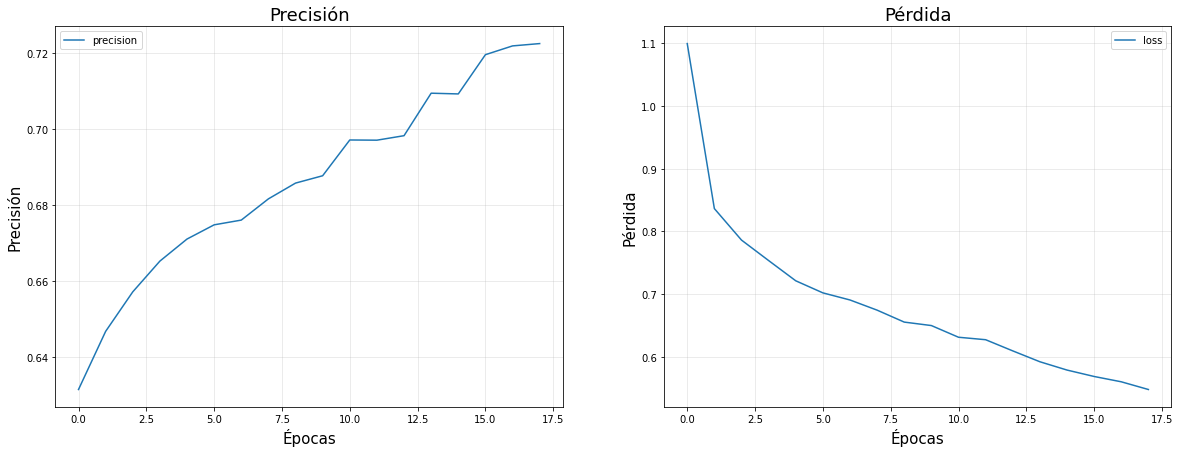

In [31]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Precision
best_cv_1 = load_model('model_94.h5')
plt.plot(hist.iloc[0, 1].epoch, hist.iloc[0, 1].history['precision'], label = "precision")

plt.title("Precisión", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Precisión", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Pérdida
fig.add_subplot(122)

plt.plot(hist.iloc[0, 1].epoch, hist.iloc[0, 1].history['loss'], label="loss")

plt.title("Pérdida", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Pérdida", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

Podemos ver cómo aumenta la precisión conforme disminuye la pérdida del modelo. Vemos que, al momento de parar, el momento está llegando a una especie de plateau, tal que podemos pensar que NO está haciendo overfitting. No obstante, para determinar esto debemos hacer validación sobre test.

Antes de proseguir, veamos el reporte de clasificación para nuestro modelo:

In [41]:
y_pred = best_cv_1.predict(embedded_abstracts_)
y_pred = y_pred.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 
Y_tr = Y_train_.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 


print('---Reporte para el modelo construido---')
print(classification_report(Y_tr, y_pred))

---Reporte para el modelo construido---
              precision    recall  f1-score   support

           1       0.75      0.81      0.78      2103
           2       0.52      0.92      0.66       994
           3       0.57      0.75      0.65      1280
           4       0.70      0.85      0.77      2029
           5       0.77      0.35      0.48      3194

    accuracy                           0.67      9600
   macro avg       0.66      0.74      0.67      9600
weighted avg       0.70      0.67      0.65      9600



Podemos ver que, en promedio, la precisión de este modelo no es mala. De hecho, para tres de las 5 clases (neoplasias, enfermedades cardiovasculares y patologías generales, se tiene una precisión mayor o igual al 70%. Esperamos poder mejorar esto de alguna forma, para ello, intentamos otras técnicas.

Veamos ahora la matriz de confusión:

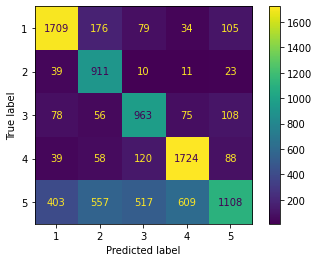

In [42]:
cm = confusion_matrix(Y_tr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.arange(1,6))
disp.plot()
plt.show()

En este caso, podemos ver que la clase que más se confunde es la 5: esto tiene sentido, pues las palabras que la conforman pueden caber en varias de las otras categorías. De resto, el modelo clasifica bien (sin mucho error) las otras clases. Note que las clases peor clasificadas son las minoritarias, incluso a pesar de que consideramos los pesos en la construcción del modelo.

### Modelo con ajuste de hiperparámetros usando BioWordVec
Lo primero que hacemos es eliminar los datos nulos, pues hay algunas filas que no tuvieron palabras importantes y, por tanto, deben ser eliminadas.

In [5]:
datos_train_not_null = datos_train.copy()
datos_train_not_null = datos_train_not_null.dropna(how='any',axis=0) 
tokenized_entities = datos_train_not_null['tokenized_entities']
tokenized_entities_ = tokenized_entities.to_numpy().reshape(-1, 1)

Usamos la librería de BioWordVec para las palabras de las entidades obtenidas en el preprocesamiento:

In [4]:
embedding = fasttext.load_model('BioWordVec_PubMed_MIMICIII_d200.bin')

In [20]:
datos_train_not_null['embedded'] = 'pre'
for i in range(len(datos_train_not_null)):
    datos_train_not_null['embedded'].iloc[i] = embedding[datos_train_not_null['tokenized_entities'].iloc[i]]

In [95]:
embedded_entities = np.array([[embedding[datos_train_not_null['tokenized_entities'].iloc[i]]] for i in range(len(datos_train_not_null))])

Note que los vectores generados son de dimensionalidad 200, mientras que los de Sent2Vec eran de dimensionalidad 700.

In [101]:
print(embedded_entities[2].shape)

(1, 200)


Ya que hemos cargado el embedding de las palabras, podemos usar la función de hiperparámetros definida previamente, solo que con algunos diferentes (debido a que este conjunto tiene menor dimensionalidad). En este caso, no es necesario hacer un reshape por la forma en que fueron leídos los datos. Pero sí debemos pasar las categorías a OneHot para la interpretación por parte del modelo.

In [103]:
Y_ent = datos_train_not_null['problems_described']
Y_ent = keras.utils.np_utils.to_categorical(Y_ent)[:,1:]

Ahora, definimos nuestra grilla de hiperparámetros. Para ello, usamos el mismo número de capas ocultas (máximo 3 + una LSTM de entrada y una LSTM de salida = 5), las mismas tasas de dropout y la misma cantidad de neuronas (excepto que, en este caso, consideramos capas de 128 neuronas también). Asimismo, consideramos como posible salida de la capa de embedding una capa con 128 o 256 neuronas.
Para este ejercicio, consideramos la definición de los siguientes hiperparámetros:
* **Número de capas:** Le permitimos a la red elegir entre 1, 2 o 3 capas ocultas LSTM. Siempre hay dos capas LSTM iniciales por defecto.
* **Número de neuronas:** Permitimos un espacio de búsqueda de 8, 16, 32, y 64 neuronas. Note que, por facilidades computacionales y de implementación, este número de neuronas será utilizado por todas las capas.
* **Tasa de Dropout:** Para no sobreaprender y hacer overfitting sobre el conjunto de datos, debemos añadir una capa de dropout para que la red olvide un porcentaje de lo que ha aprendido. 

Note asimismo que la función parte el conjunto de entrenamiento en entrenamiento-validación y hace la validación de la función de error y de la métrica usando las métricas sobre validación y no entrenamiento, esto hará que los resultados obtenidos tengan menos sobreajuste que si se evaluara sobre train.

In [102]:
new_config = [[True, False], [True, False], [True, False], [8, 16, 32, 64, 128], [0.1, 0.25, 0.5]]  
hist_entities = LSTM_hiperparametros(new_config, x_train=embedded_entities, y_train=Y_ent, is_ent=True)

La cantidad de combinaciones es:  120


Combinación 1: 

--------------------------------------------------------------------
Epoch 1/70
230/236 [============================>.] - ETA: 0s - loss: 1.5750 - precision: 0.4658   
Epoch 1: val_loss improved from inf to 1.51458, saving model to model_ent1.h5
236/236 [==============================] - 8s 10ms/step - loss: 1.5718 - precision: 0.4242 - val_loss: 1.5146 - val_precision: 0.4300
Epoch 2/70
226/236 [===========================>..] - ETA: 0s - loss: 1.3855 - precision: 0.3581
Epoch 2: val_loss improved from 1.51458 to 1.41420, saving model to model_ent1.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3856 - precision: 0.3559 - val_loss: 1.4142 - val_precision: 0.3911
Epoch 3/70
230/236 [============================>.] - ETA: 0s - loss: 1.3279 - precision: 0.3556
Epoch 3: val_loss improved from 1.41420 to 1.35764, saving model to model_ent1.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3259 -

236/236 [==============================] - 1s 4ms/step - loss: 0.9521 - precision: 0.6027 - val_loss: 1.0893 - val_precision: 0.5911
Epoch 56/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9474 - precision: 0.6063
Epoch 56: val_loss did not improve from 1.08336
236/236 [==============================] - 1s 4ms/step - loss: 0.9504 - precision: 0.6064 - val_loss: 1.0974 - val_precision: 0.5848
Epoch 56: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 1.0177 - precision: 0.6062
Combinación 0 = (True, True, True, 8, 0.1) 
 precision train: [1.0177134275436401, 0.6061726808547974]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 2: 

--------------------------------------------------------------------
Epoch 1/

Epoch 25/70
223/236 [===========================>..] - ETA: 0s - loss: 1.1050 - precision: 0.6099
Epoch 25: val_loss improved from 1.10901 to 1.10791, saving model to model_ent2.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.1043 - precision: 0.6090 - val_loss: 1.1079 - val_precision: 0.6319
Epoch 26/70
233/236 [============================>.] - ETA: 0s - loss: 1.1000 - precision: 0.6091
Epoch 26: val_loss improved from 1.10791 to 1.10660, saving model to model_ent2.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0992 - precision: 0.6094 - val_loss: 1.1066 - val_precision: 0.6328
Epoch 27/70
234/236 [============================>.] - ETA: 0s - loss: 1.0973 - precision: 0.6110
Epoch 27: val_loss improved from 1.10660 to 1.10146, saving model to model_ent2.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0976 - precision: 0.6099 - val_loss: 1.1015 - val_precision: 0.6273
Epoch 28/70
224/236 [===========================>..] - ETA

236/236 [==============================] - 1s 4ms/step - loss: 1.0568 - precision: 0.6084 - val_loss: 1.1012 - val_precision: 0.6006
Epoch 54/70
224/236 [===========================>..] - ETA: 0s - loss: 1.0353 - precision: 0.6152
Epoch 54: val_loss did not improve from 1.08661
236/236 [==============================] - 1s 4ms/step - loss: 1.0356 - precision: 0.6147 - val_loss: 1.1010 - val_precision: 0.5972
Epoch 55/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0486 - precision: 0.6051
Epoch 55: val_loss did not improve from 1.08661
236/236 [==============================] - 1s 4ms/step - loss: 1.0484 - precision: 0.6047 - val_loss: 1.0993 - val_precision: 0.6003
Epoch 56/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0513 - precision: 0.6108
Epoch 56: val_loss did not improve from 1.08661
236/236 [==============================] - 1s 4ms/step - loss: 1.0564 - precision: 0.6103 - val_loss: 1.0989 - val_precision: 0.6014
Epoch 57/70
236/236 [=========

Epoch 22/70
233/236 [============================>.] - ETA: 0s - loss: 1.2941 - precision: 0.6022
Epoch 22: val_loss did not improve from 1.26480
236/236 [==============================] - 1s 4ms/step - loss: 1.2937 - precision: 0.6025 - val_loss: 1.2730 - val_precision: 0.6643
Epoch 23/70
235/236 [============================>.] - ETA: 0s - loss: 1.2975 - precision: 0.5912
Epoch 23: val_loss improved from 1.26480 to 1.26224, saving model to model_ent3.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2980 - precision: 0.5921 - val_loss: 1.2622 - val_precision: 0.6597
Epoch 24/70
232/236 [============================>.] - ETA: 0s - loss: 1.2963 - precision: 0.5856
Epoch 24: val_loss did not improve from 1.26224
236/236 [==============================] - 1s 4ms/step - loss: 1.2945 - precision: 0.5843 - val_loss: 1.2659 - val_precision: 0.6628
Epoch 25/70
234/236 [============================>.] - ETA: 0s - loss: 1.2882 - precision: 0.6080
Epoch 25: val_loss did not imp

236/236 [==============================] - 1s 4ms/step - loss: 1.0336 - precision: 0.5884 - val_loss: 1.0980 - val_precision: 0.5911
Epoch 7/70
225/236 [===========================>..] - ETA: 0s - loss: 1.0226 - precision: 0.5876
Epoch 7: val_loss improved from 1.09802 to 1.07582, saving model to model_ent4.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0211 - precision: 0.5885 - val_loss: 1.0758 - val_precision: 0.6073
Epoch 8/70
231/236 [============================>.] - ETA: 0s - loss: 1.0044 - precision: 0.5963
Epoch 8: val_loss did not improve from 1.07582
236/236 [==============================] - 1s 4ms/step - loss: 1.0065 - precision: 0.5949 - val_loss: 1.0850 - val_precision: 0.6007
Epoch 9/70
233/236 [============================>.] - ETA: 0s - loss: 1.0023 - precision: 0.5979
Epoch 9: val_loss improved from 1.07582 to 1.07211, saving model to model_ent4.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0033 - precision: 0.5976 - val_los

Epoch 4/70
234/236 [============================>.] - ETA: 0s - loss: 1.2533 - precision: 0.6329
Epoch 4: val_loss improved from 1.28428 to 1.24446, saving model to model_ent5.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2541 - precision: 0.6336 - val_loss: 1.2445 - val_precision: 0.6732
Epoch 5/70
227/236 [===========================>..] - ETA: 0s - loss: 1.2238 - precision: 0.6421
Epoch 5: val_loss improved from 1.24446 to 1.21967, saving model to model_ent5.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2235 - precision: 0.6431 - val_loss: 1.2197 - val_precision: 0.7053
Epoch 6/70
232/236 [============================>.] - ETA: 0s - loss: 1.2035 - precision: 0.6684
Epoch 6: val_loss improved from 1.21967 to 1.19068, saving model to model_ent5.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2029 - precision: 0.6680 - val_loss: 1.1907 - val_precision: 0.6901
Epoch 7/70
228/236 [===========================>..] - ETA: 0s - 

232/236 [============================>.] - ETA: 0s - loss: 1.0209 - precision: 0.5950
Epoch 31: val_loss did not improve from 1.09457
236/236 [==============================] - 1s 4ms/step - loss: 1.0205 - precision: 0.5951 - val_loss: 1.0976 - val_precision: 0.5948
Epoch 32/70
234/236 [============================>.] - ETA: 0s - loss: 1.0157 - precision: 0.5981
Epoch 32: val_loss did not improve from 1.09457
236/236 [==============================] - 1s 4ms/step - loss: 1.0158 - precision: 0.5985 - val_loss: 1.1023 - val_precision: 0.5873
Epoch 33/70
229/236 [============================>.] - ETA: 0s - loss: 1.0076 - precision: 0.5997
Epoch 33: val_loss did not improve from 1.09457
236/236 [==============================] - 1s 4ms/step - loss: 1.0072 - precision: 0.6013 - val_loss: 1.1234 - val_precision: 0.5823
Epoch 34/70
229/236 [============================>.] - ETA: 0s - loss: 1.0176 - precision: 0.5952
Epoch 34: val_loss did not improve from 1.09457
236/236 [====================

Epoch 3/70
230/236 [============================>.] - ETA: 0s - loss: 1.3464 - precision: 0.4783
Epoch 3: val_loss improved from 1.34240 to 1.31946, saving model to model_ent6.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.3459 - precision: 0.4798 - val_loss: 1.3195 - val_precision: 0.0000e+00
Epoch 4/70
230/236 [============================>.] - ETA: 0s - loss: 1.3118 - precision: 0.5189
Epoch 4: val_loss improved from 1.31946 to 1.30933, saving model to model_ent6.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3140 - precision: 0.5202 - val_loss: 1.3093 - val_precision: 0.0000e+00
Epoch 5/70
233/236 [============================>.] - ETA: 0s - loss: 1.3154 - precision: 0.5429
Epoch 5: val_loss improved from 1.30933 to 1.28415, saving model to model_ent6.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3134 - precision: 0.5450 - val_loss: 1.2842 - val_precision: 0.6742
Epoch 6/70
229/236 [============================>.] - ET

Epoch 30/70
232/236 [============================>.] - ETA: 0s - loss: 1.1681 - precision: 0.6002
Epoch 30: val_loss improved from 1.15529 to 1.14691, saving model to model_ent6.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.1674 - precision: 0.5997 - val_loss: 1.1469 - val_precision: 0.6279
Epoch 31/70
235/236 [============================>.] - ETA: 0s - loss: 1.1602 - precision: 0.5963
Epoch 31: val_loss did not improve from 1.14691
236/236 [==============================] - 1s 4ms/step - loss: 1.1593 - precision: 0.5972 - val_loss: 1.1476 - val_precision: 0.6246
Epoch 32/70
233/236 [============================>.] - ETA: 0s - loss: 1.1599 - precision: 0.5957
Epoch 32: val_loss did not improve from 1.14691
236/236 [==============================] - 1s 4ms/step - loss: 1.1589 - precision: 0.5956 - val_loss: 1.1514 - val_precision: 0.6187
Epoch 33/70
228/236 [===========================>..] - ETA: 0s - loss: 1.1564 - precision: 0.6094
Epoch 33: val_loss did not imp

Epoch 1/70
226/236 [===========================>..] - ETA: 0s - loss: 1.4342 - precision: 0.5844
Epoch 1: val_loss improved from inf to 1.30559, saving model to model_ent7.h5
236/236 [==============================] - 7s 10ms/step - loss: 1.4299 - precision: 0.5835 - val_loss: 1.3056 - val_precision: 0.7026
Epoch 2/70
233/236 [============================>.] - ETA: 0s - loss: 1.2010 - precision: 0.6495
Epoch 2: val_loss improved from 1.30559 to 1.14813, saving model to model_ent7.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.2007 - precision: 0.6480 - val_loss: 1.1481 - val_precision: 0.6137
Epoch 3/70
234/236 [============================>.] - ETA: 0s - loss: 1.0779 - precision: 0.5900
Epoch 3: val_loss improved from 1.14813 to 1.11912, saving model to model_ent7.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.0771 - precision: 0.5899 - val_loss: 1.1191 - val_precision: 0.6020
Epoch 4/70
229/236 [============================>.] - ETA: 0s - los

Epoch 21/70
236/236 [==============================] - ETA: 0s - loss: 0.9600 - precision: 0.6044
Epoch 21: val_loss improved from 1.06258 to 1.05765, saving model to model_ent8.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9600 - precision: 0.6044 - val_loss: 1.0577 - val_precision: 0.6014
Epoch 22/70
235/236 [============================>.] - ETA: 0s - loss: 0.9515 - precision: 0.6119
Epoch 22: val_loss did not improve from 1.05765
236/236 [==============================] - 1s 4ms/step - loss: 0.9512 - precision: 0.6117 - val_loss: 1.0586 - val_precision: 0.5983
Epoch 23/70
231/236 [============================>.] - ETA: 0s - loss: 0.9507 - precision: 0.6086
Epoch 23: val_loss improved from 1.05765 to 1.05535, saving model to model_ent8.h5
236/236 [==============================] - 1s 5ms/step - loss: 0.9508 - precision: 0.6072 - val_loss: 1.0554 - val_precision: 0.5976
Epoch 24/70
233/236 [============================>.] - ETA: 0s - loss: 0.9458 - precision: 0.

236/236 [==============================] - 1s 4ms/step - loss: 0.8514 - precision: 0.6240 - val_loss: 1.0897 - val_precision: 0.5849
Epoch 50/70
234/236 [============================>.] - ETA: 0s - loss: 0.8581 - precision: 0.6249
Epoch 50: val_loss did not improve from 1.03386
236/236 [==============================] - 1s 4ms/step - loss: 0.8571 - precision: 0.6252 - val_loss: 1.0650 - val_precision: 0.5869
Epoch 51/70
232/236 [============================>.] - ETA: 0s - loss: 0.8461 - precision: 0.6285
Epoch 51: val_loss did not improve from 1.03386
236/236 [==============================] - 1s 4ms/step - loss: 0.8447 - precision: 0.6284 - val_loss: 1.0799 - val_precision: 0.5778
Epoch 51: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9546 - precision: 0.6186
Combinación 7 = (True, True, True, 32, 0.25) 
 precision train: [0.9545841813087463, 0.618643045425415]
--------------------------------------------------------------------
---------------------

Epoch 24/70
231/236 [============================>.] - ETA: 0s - loss: 1.0580 - precision: 0.6040
Epoch 24: val_loss did not improve from 1.09699
236/236 [==============================] - 1s 4ms/step - loss: 1.0588 - precision: 0.6042 - val_loss: 1.1030 - val_precision: 0.6007
Epoch 25/70
234/236 [============================>.] - ETA: 0s - loss: 1.0550 - precision: 0.6001
Epoch 25: val_loss did not improve from 1.09699
236/236 [==============================] - 1s 4ms/step - loss: 1.0569 - precision: 0.6005 - val_loss: 1.1170 - val_precision: 0.5883
Epoch 26/70
233/236 [============================>.] - ETA: 0s - loss: 1.0599 - precision: 0.5993
Epoch 26: val_loss did not improve from 1.09699
236/236 [==============================] - 1s 4ms/step - loss: 1.0591 - precision: 0.5994 - val_loss: 1.1027 - val_precision: 0.5999
Epoch 27/70
232/236 [============================>.] - ETA: 0s - loss: 1.0511 - precision: 0.6040
Epoch 27: val_loss improved from 1.09699 to 1.09174, saving model

236/236 [==============================] - 1s 6ms/step - loss: 0.9621 - precision: 0.6071 - val_loss: 1.0700 - val_precision: 0.6072
Epoch 10/70
233/236 [============================>.] - ETA: 0s - loss: 0.9659 - precision: 0.6036
Epoch 10: val_loss improved from 1.04682 to 1.04558, saving model to model_ent11.h5
236/236 [==============================] - 1s 5ms/step - loss: 0.9644 - precision: 0.6043 - val_loss: 1.0456 - val_precision: 0.6189
Epoch 11/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9581 - precision: 0.6073
Epoch 11: val_loss did not improve from 1.04558
236/236 [==============================] - 1s 6ms/step - loss: 0.9586 - precision: 0.6063 - val_loss: 1.0545 - val_precision: 0.6138
Epoch 12/70
236/236 [==============================] - ETA: 0s - loss: 0.9467 - precision: 0.6052
Epoch 12: val_loss did not improve from 1.04558
236/236 [==============================] - 1s 5ms/step - loss: 0.9467 - precision: 0.6052 - val_loss: 1.0629 - val_precision: 0

236/236 [==============================] - 1s 5ms/step - loss: 1.0236 - precision: 0.5950 - val_loss: 1.0584 - val_precision: 0.6087
Epoch 11/70
225/236 [===========================>..] - ETA: 0s - loss: 1.0070 - precision: 0.6003
Epoch 11: val_loss improved from 1.05838 to 1.05777, saving model to model_ent12.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.0092 - precision: 0.6003 - val_loss: 1.0578 - val_precision: 0.6083
Epoch 12/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0138 - precision: 0.5983
Epoch 12: val_loss did not improve from 1.05777
236/236 [==============================] - 1s 5ms/step - loss: 1.0140 - precision: 0.5984 - val_loss: 1.0777 - val_precision: 0.6038
Epoch 13/70
228/236 [===========================>..] - ETA: 0s - loss: 1.0056 - precision: 0.5980
Epoch 13: val_loss improved from 1.05777 to 1.05608, saving model to model_ent12.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.0065 - precision: 0.5976 -

Epoch 39/70
236/236 [==============================] - ETA: 0s - loss: 0.9293 - precision: 0.6099
Epoch 39: val_loss did not improve from 1.03668
236/236 [==============================] - 1s 6ms/step - loss: 0.9293 - precision: 0.6099 - val_loss: 1.0519 - val_precision: 0.5941
Epoch 40/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9181 - precision: 0.6111
Epoch 40: val_loss did not improve from 1.03668
236/236 [==============================] - 1s 6ms/step - loss: 0.9131 - precision: 0.6117 - val_loss: 1.0575 - val_precision: 0.5914
Epoch 41/70
232/236 [============================>.] - ETA: 0s - loss: 0.9177 - precision: 0.6094
Epoch 41: val_loss did not improve from 1.03668
236/236 [==============================] - 1s 5ms/step - loss: 0.9189 - precision: 0.6089 - val_loss: 1.0426 - val_precision: 0.5971
Epoch 42/70
232/236 [============================>.] - ETA: 0s - loss: 0.9100 - precision: 0.6188
Epoch 42: val_loss did not improve from 1.03668
236/236 [========

236/236 [==============================] - 2s 8ms/step - loss: 0.8328 - precision: 0.6233 - val_loss: 1.0716 - val_precision: 0.5953
Epoch 18/70
231/236 [============================>.] - ETA: 0s - loss: 0.8335 - precision: 0.6198
Epoch 18: val_loss did not improve from 1.02229
236/236 [==============================] - 2s 7ms/step - loss: 0.8317 - precision: 0.6219 - val_loss: 1.0502 - val_precision: 0.6040
Epoch 19/70
232/236 [============================>.] - ETA: 0s - loss: 0.8132 - precision: 0.6283
Epoch 19: val_loss did not improve from 1.02229
236/236 [==============================] - 2s 8ms/step - loss: 0.8138 - precision: 0.6279 - val_loss: 1.0394 - val_precision: 0.5946
Epoch 20/70
229/236 [============================>.] - ETA: 0s - loss: 0.8084 - precision: 0.6287
Epoch 20: val_loss did not improve from 1.02229
236/236 [==============================] - 2s 8ms/step - loss: 0.8076 - precision: 0.6300 - val_loss: 1.0727 - val_precision: 0.5938
Epoch 21/70
229/236 [=========

Epoch 18/70
232/236 [============================>.] - ETA: 0s - loss: 0.8677 - precision: 0.6128
Epoch 18: val_loss did not improve from 1.01894
236/236 [==============================] - 2s 8ms/step - loss: 0.8660 - precision: 0.6142 - val_loss: 1.0332 - val_precision: 0.6044
Epoch 19/70
235/236 [============================>.] - ETA: 0s - loss: 0.8653 - precision: 0.6161
Epoch 19: val_loss did not improve from 1.01894
236/236 [==============================] - 2s 8ms/step - loss: 0.8647 - precision: 0.6163 - val_loss: 1.0458 - val_precision: 0.5999
Epoch 20/70
233/236 [============================>.] - ETA: 0s - loss: 0.8502 - precision: 0.6196
Epoch 20: val_loss did not improve from 1.01894
236/236 [==============================] - 2s 8ms/step - loss: 0.8515 - precision: 0.6197 - val_loss: 1.0612 - val_precision: 0.5873
Epoch 21/70
233/236 [============================>.] - ETA: 0s - loss: 0.8484 - precision: 0.6242
Epoch 21: val_loss did not improve from 1.01894
236/236 [========

236/236 [==============================] - 2s 8ms/step - loss: 0.9266 - precision: 0.6040 - val_loss: 1.0381 - val_precision: 0.6073
Epoch 20/70
234/236 [============================>.] - ETA: 0s - loss: 0.9221 - precision: 0.6047
Epoch 20: val_loss improved from 1.03353 to 1.02228, saving model to model_ent15.h5
236/236 [==============================] - 2s 8ms/step - loss: 0.9232 - precision: 0.6051 - val_loss: 1.0223 - val_precision: 0.6190
Epoch 21/70
236/236 [==============================] - ETA: 0s - loss: 0.9149 - precision: 0.6090
Epoch 21: val_loss did not improve from 1.02228
236/236 [==============================] - 2s 8ms/step - loss: 0.9149 - precision: 0.6090 - val_loss: 1.0251 - val_precision: 0.6144
Epoch 22/70
235/236 [============================>.] - ETA: 0s - loss: 0.9094 - precision: 0.6098
Epoch 22: val_loss did not improve from 1.02228
236/236 [==============================] - 2s 8ms/step - loss: 0.9093 - precision: 0.6098 - val_loss: 1.0342 - val_precision: 0

Epoch 44/70
231/236 [============================>.] - ETA: 0s - loss: 0.9304 - precision: 0.6219
Epoch 44: val_loss did not improve from 1.05004
236/236 [==============================] - 1s 3ms/step - loss: 0.9305 - precision: 0.6207 - val_loss: 1.0663 - val_precision: 0.6076
Epoch 45/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9235 - precision: 0.6219
Epoch 45: val_loss did not improve from 1.05004
236/236 [==============================] - 1s 3ms/step - loss: 0.9245 - precision: 0.6182 - val_loss: 1.0649 - val_precision: 0.6117
Epoch 46/70
234/236 [============================>.] - ETA: 0s - loss: 0.9349 - precision: 0.6144
Epoch 46: val_loss did not improve from 1.05004
236/236 [==============================] - 1s 3ms/step - loss: 0.9341 - precision: 0.6145 - val_loss: 1.0614 - val_precision: 0.6074
Epoch 47/70
233/236 [============================>.] - ETA: 0s - loss: 0.9151 - precision: 0.6248
Epoch 47: val_loss did not improve from 1.05004
236/236 [========

Epoch 4/70
225/236 [===========================>..] - ETA: 0s - loss: 1.3899 - precision: 0.5649
Epoch 4: val_loss improved from 1.32696 to 1.30709, saving model to model_ent18.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3872 - precision: 0.5672 - val_loss: 1.3071 - val_precision: 0.6635
Epoch 5/70
236/236 [==============================] - ETA: 0s - loss: 1.3561 - precision: 0.5591
Epoch 5: val_loss improved from 1.30709 to 1.28693, saving model to model_ent18.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3561 - precision: 0.5591 - val_loss: 1.2869 - val_precision: 0.6644
Epoch 6/70
236/236 [==============================] - ETA: 0s - loss: 1.3387 - precision: 0.5615
Epoch 6: val_loss improved from 1.28693 to 1.28000, saving model to model_ent18.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3387 - precision: 0.5615 - val_loss: 1.2800 - val_precision: 0.6628
Epoch 7/70
229/236 [============================>.] - ETA: 0s

Epoch 32/70
224/236 [===========================>..] - ETA: 0s - loss: 1.2788 - precision: 0.5991
Epoch 32: val_loss did not improve from 1.23668
236/236 [==============================] - 1s 4ms/step - loss: 1.2783 - precision: 0.6015 - val_loss: 1.2451 - val_precision: 0.6637
Epoch 33/70
231/236 [============================>.] - ETA: 0s - loss: 1.2754 - precision: 0.5780
Epoch 33: val_loss improved from 1.23668 to 1.23657, saving model to model_ent18.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2765 - precision: 0.5787 - val_loss: 1.2366 - val_precision: 0.6609
Epoch 34/70
225/236 [===========================>..] - ETA: 0s - loss: 1.2631 - precision: 0.5820
Epoch 34: val_loss did not improve from 1.23657
236/236 [==============================] - 1s 4ms/step - loss: 1.2651 - precision: 0.5823 - val_loss: 1.2367 - val_precision: 0.6608
Epoch 35/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2622 - precision: 0.5866
Epoch 35: val_loss did not im

Epoch 11/70
230/236 [============================>.] - ETA: 0s - loss: 0.9782 - precision: 0.6040
Epoch 11: val_loss did not improve from 1.05309
236/236 [==============================] - 1s 3ms/step - loss: 0.9769 - precision: 0.6042 - val_loss: 1.0673 - val_precision: 0.6004
Epoch 12/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9766 - precision: 0.5972
Epoch 12: val_loss improved from 1.05309 to 1.04827, saving model to model_ent19.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9794 - precision: 0.5982 - val_loss: 1.0483 - val_precision: 0.6112
Epoch 13/70
229/236 [============================>.] - ETA: 0s - loss: 0.9587 - precision: 0.6006
Epoch 13: val_loss improved from 1.04827 to 1.04203, saving model to model_ent19.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9611 - precision: 0.6011 - val_loss: 1.0420 - val_precision: 0.6198
Epoch 14/70
229/236 [============================>.] - ETA: 0s - loss: 0.9611 - precision: 

Epoch 39/70
235/236 [============================>.] - ETA: 0s - loss: 0.8629 - precision: 0.6262
Epoch 39: val_loss did not improve from 1.01704
236/236 [==============================] - 1s 4ms/step - loss: 0.8624 - precision: 0.6263 - val_loss: 1.0336 - val_precision: 0.6124
Epoch 40/70
232/236 [============================>.] - ETA: 0s - loss: 0.8519 - precision: 0.6308
Epoch 40: val_loss did not improve from 1.01704
236/236 [==============================] - 1s 4ms/step - loss: 0.8530 - precision: 0.6305 - val_loss: 1.0311 - val_precision: 0.6163
Epoch 41/70
236/236 [==============================] - ETA: 0s - loss: 0.8490 - precision: 0.6397
Epoch 41: val_loss did not improve from 1.01704
236/236 [==============================] - 1s 4ms/step - loss: 0.8490 - precision: 0.6397 - val_loss: 1.0525 - val_precision: 0.6034
Epoch 41: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9615 - precision: 0.6279
Combinación 18 = (True, True, False, 16, 0.1) 
 

236/236 [==============================] - 1s 4ms/step - loss: 0.9729 - precision: 0.6091 - val_loss: 1.0406 - val_precision: 0.6090
Epoch 24/70
229/236 [============================>.] - ETA: 0s - loss: 0.9648 - precision: 0.6128
Epoch 24: val_loss did not improve from 1.04060
236/236 [==============================] - 1s 4ms/step - loss: 0.9658 - precision: 0.6118 - val_loss: 1.0553 - val_precision: 0.6035
Epoch 25/70
229/236 [============================>.] - ETA: 0s - loss: 0.9670 - precision: 0.6071
Epoch 25: val_loss did not improve from 1.04060
236/236 [==============================] - 1s 4ms/step - loss: 0.9690 - precision: 0.6080 - val_loss: 1.0444 - val_precision: 0.6048
Epoch 26/70
236/236 [==============================] - ETA: 0s - loss: 0.9653 - precision: 0.6108
Epoch 26: val_loss did not improve from 1.04060
236/236 [==============================] - 1s 4ms/step - loss: 0.9653 - precision: 0.6108 - val_loss: 1.0426 - val_precision: 0.6063
Epoch 27/70
225/236 [=========

236/236 [==============================] - 1s 4ms/step - loss: 1.2227 - precision: 0.6537 - val_loss: 1.1572 - val_precision: 0.6917
Epoch 10/70
225/236 [===========================>..] - ETA: 0s - loss: 1.2074 - precision: 0.6434
Epoch 10: val_loss improved from 1.15716 to 1.15058, saving model to model_ent21.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2095 - precision: 0.6442 - val_loss: 1.1506 - val_precision: 0.6839
Epoch 11/70
224/236 [===========================>..] - ETA: 0s - loss: 1.1971 - precision: 0.6360
Epoch 11: val_loss improved from 1.15058 to 1.14076, saving model to model_ent21.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.1939 - precision: 0.6358 - val_loss: 1.1408 - val_precision: 0.6702
Epoch 12/70
236/236 [==============================] - ETA: 0s - loss: 1.1897 - precision: 0.6306
Epoch 12: val_loss improved from 1.14076 to 1.13457, saving model to model_ent21.h5
236/236 [==============================] - 1s 4ms/step 

Epoch 38/70
224/236 [===========================>..] - ETA: 0s - loss: 1.1007 - precision: 0.6086
Epoch 38: val_loss did not improve from 1.09318
236/236 [==============================] - 1s 4ms/step - loss: 1.0979 - precision: 0.6081 - val_loss: 1.1039 - val_precision: 0.6209
Epoch 39/70
232/236 [============================>.] - ETA: 0s - loss: 1.1083 - precision: 0.6021
Epoch 39: val_loss did not improve from 1.09318
236/236 [==============================] - 1s 4ms/step - loss: 1.1078 - precision: 0.6006 - val_loss: 1.1042 - val_precision: 0.6199
Epoch 40/70
236/236 [==============================] - ETA: 0s - loss: 1.0944 - precision: 0.6107
Epoch 40: val_loss did not improve from 1.09318
236/236 [==============================] - 1s 4ms/step - loss: 1.0944 - precision: 0.6107 - val_loss: 1.1041 - val_precision: 0.6104
Epoch 41/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0812 - precision: 0.6116
Epoch 41: val_loss did not improve from 1.09318
236/236 [========

Epoch 66: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 1.0587 - precision: 0.6142
Combinación 20 = (True, True, False, 16, 0.5) 
 precision train: [1.0587180852890015, 0.6141939163208008]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 22: 

--------------------------------------------------------------------
Epoch 1/70
235/236 [============================>.] - ETA: 0s - loss: 1.3485 - precision: 0.5897
Epoch 1: val_loss improved from inf to 1.17374, saving model to model_ent22.h5
236/236 [==============================] - 8s 10ms/step - loss: 1.3475 - precision: 0.5903 - val_loss: 1.1737 - val_precision: 0.6306
Epoch 2/70
226/236 [===========================>..] - ETA: 0s - loss: 1.0567 - precision: 0.6010
Epoch 2: 

Epoch 1/70
227/236 [===========================>..] - ETA: 0s - loss: 1.4174 - precision: 0.5788
Epoch 1: val_loss improved from inf to 1.27760, saving model to model_ent23.h5
236/236 [==============================] - 8s 10ms/step - loss: 1.4136 - precision: 0.5821 - val_loss: 1.2776 - val_precision: 0.6594
Epoch 2/70
231/236 [============================>.] - ETA: 0s - loss: 1.1832 - precision: 0.6482
Epoch 2: val_loss improved from 1.27760 to 1.13334, saving model to model_ent23.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.1833 - precision: 0.6470 - val_loss: 1.1333 - val_precision: 0.6483
Epoch 3/70
233/236 [============================>.] - ETA: 0s - loss: 1.0744 - precision: 0.6245
Epoch 3: val_loss improved from 1.13334 to 1.08283, saving model to model_ent23.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0724 - precision: 0.6258 - val_loss: 1.0828 - val_precision: 0.6334
Epoch 4/70
236/236 [==============================] - ETA: 0s - 

223/236 [===========================>..] - ETA: 0s - loss: 0.8985 - precision: 0.6193
Epoch 29: val_loss did not improve from 1.02142
236/236 [==============================] - 1s 4ms/step - loss: 0.8976 - precision: 0.6185 - val_loss: 1.0366 - val_precision: 0.6038
Epoch 30/70
223/236 [===========================>..] - ETA: 0s - loss: 0.8911 - precision: 0.6191
Epoch 30: val_loss did not improve from 1.02142
236/236 [==============================] - 1s 4ms/step - loss: 0.8909 - precision: 0.6183 - val_loss: 1.0380 - val_precision: 0.6098
Epoch 31/70
236/236 [==============================] - ETA: 0s - loss: 0.8885 - precision: 0.6200
Epoch 31: val_loss improved from 1.02142 to 1.00680, saving model to model_ent23.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.8885 - precision: 0.6200 - val_loss: 1.0068 - val_precision: 0.6261
Epoch 32/70
226/236 [===========================>..] - ETA: 0s - loss: 0.8804 - precision: 0.6258
Epoch 32: val_loss did not improve from 1

Epoch 14/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0475 - precision: 0.6043
Epoch 14: val_loss did not improve from 1.07524
236/236 [==============================] - 1s 4ms/step - loss: 1.0474 - precision: 0.6037 - val_loss: 1.0830 - val_precision: 0.6115
Epoch 15/70
236/236 [==============================] - ETA: 0s - loss: 1.0412 - precision: 0.5958
Epoch 15: val_loss did not improve from 1.07524
236/236 [==============================] - 1s 4ms/step - loss: 1.0412 - precision: 0.5958 - val_loss: 1.0830 - val_precision: 0.6029
Epoch 16/70
224/236 [===========================>..] - ETA: 0s - loss: 1.0366 - precision: 0.5992
Epoch 16: val_loss did not improve from 1.07524
236/236 [==============================] - 1s 4ms/step - loss: 1.0356 - precision: 0.5998 - val_loss: 1.0852 - val_precision: 0.6019
Epoch 17/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0210 - precision: 0.5979
Epoch 17: val_loss did not improve from 1.07524
236/236 [========

236/236 [==============================] - 1s 4ms/step - loss: 0.9671 - precision: 0.5961 - val_loss: 1.0535 - val_precision: 0.6097
Epoch 5/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9541 - precision: 0.6048
Epoch 5: val_loss did not improve from 1.05347
236/236 [==============================] - 1s 4ms/step - loss: 0.9536 - precision: 0.6044 - val_loss: 1.0611 - val_precision: 0.6040
Epoch 6/70
234/236 [============================>.] - ETA: 0s - loss: 0.9393 - precision: 0.6022
Epoch 6: val_loss improved from 1.05347 to 1.02908, saving model to model_ent25.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9399 - precision: 0.6012 - val_loss: 1.0291 - val_precision: 0.6265
Epoch 7/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9290 - precision: 0.6059
Epoch 7: val_loss did not improve from 1.02908
236/236 [==============================] - 1s 4ms/step - loss: 0.9296 - precision: 0.6060 - val_loss: 1.0343 - val_precision: 0.6162


Epoch 4/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9980 - precision: 0.5973
Epoch 4: val_loss improved from 1.07701 to 1.06729, saving model to model_ent26.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.0009 - precision: 0.5962 - val_loss: 1.0673 - val_precision: 0.6043
Epoch 5/70
232/236 [============================>.] - ETA: 0s - loss: 0.9861 - precision: 0.5995
Epoch 5: val_loss improved from 1.06729 to 1.04578, saving model to model_ent26.h5
236/236 [==============================] - 1s 5ms/step - loss: 0.9850 - precision: 0.5994 - val_loss: 1.0458 - val_precision: 0.6203
Epoch 6/70
235/236 [============================>.] - ETA: 0s - loss: 0.9704 - precision: 0.6044
Epoch 6: val_loss improved from 1.04578 to 1.02477, saving model to model_ent26.h5
236/236 [==============================] - 2s 7ms/step - loss: 0.9703 - precision: 0.6040 - val_loss: 1.0248 - val_precision: 0.6317
Epoch 7/70
232/236 [============================>.] - ETA: 0s

Epoch 11/70
229/236 [============================>.] - ETA: 0s - loss: 0.9835 - precision: 0.6036
Epoch 11: val_loss improved from 1.04462 to 1.04347, saving model to model_ent27.h5
236/236 [==============================] - 1s 6ms/step - loss: 0.9851 - precision: 0.6029 - val_loss: 1.0435 - val_precision: 0.6199
Epoch 12/70
232/236 [============================>.] - ETA: 0s - loss: 0.9800 - precision: 0.6083
Epoch 12: val_loss improved from 1.04347 to 1.03534, saving model to model_ent27.h5
236/236 [==============================] - 1s 6ms/step - loss: 0.9832 - precision: 0.6073 - val_loss: 1.0353 - val_precision: 0.6237
Epoch 13/70
233/236 [============================>.] - ETA: 0s - loss: 0.9823 - precision: 0.6064
Epoch 13: val_loss did not improve from 1.03534
236/236 [==============================] - 1s 6ms/step - loss: 0.9802 - precision: 0.6077 - val_loss: 1.0376 - val_precision: 0.6159
Epoch 14/70
236/236 [==============================] - ETA: 0s - loss: 0.9755 - precision: 

236/236 [==============================] - 2s 8ms/step - loss: 0.9329 - precision: 0.6042 - val_loss: 1.0320 - val_precision: 0.6195
Epoch 8/70
234/236 [============================>.] - ETA: 0s - loss: 0.9253 - precision: 0.6062
Epoch 8: val_loss improved from 1.03198 to 1.02527, saving model to model_ent29.h5
236/236 [==============================] - 2s 8ms/step - loss: 0.9247 - precision: 0.6066 - val_loss: 1.0253 - val_precision: 0.6270
Epoch 9/70
234/236 [============================>.] - ETA: 0s - loss: 0.9179 - precision: 0.6091
Epoch 9: val_loss did not improve from 1.02527
236/236 [==============================] - 2s 8ms/step - loss: 0.9176 - precision: 0.6095 - val_loss: 1.0269 - val_precision: 0.6290
Epoch 10/70
231/236 [============================>.] - ETA: 0s - loss: 0.9095 - precision: 0.6103
Epoch 10: val_loss improved from 1.02527 to 1.02411, saving model to model_ent29.h5
236/236 [==============================] - 2s 8ms/step - loss: 0.9086 - precision: 0.6118 - val

Epoch 5/70
230/236 [============================>.] - ETA: 0s - loss: 1.0105 - precision: 0.6027
Epoch 5: val_loss did not improve from 1.05362
236/236 [==============================] - 2s 8ms/step - loss: 1.0104 - precision: 0.6020 - val_loss: 1.0710 - val_precision: 0.6151
Epoch 6/70
229/236 [============================>.] - ETA: 0s - loss: 0.9876 - precision: 0.5994
Epoch 6: val_loss improved from 1.05362 to 1.04257, saving model to model_ent30.h5
236/236 [==============================] - 2s 7ms/step - loss: 0.9864 - precision: 0.5999 - val_loss: 1.0426 - val_precision: 0.6064
Epoch 7/70
229/236 [============================>.] - ETA: 0s - loss: 0.9861 - precision: 0.5969
Epoch 7: val_loss did not improve from 1.04257
236/236 [==============================] - 2s 7ms/step - loss: 0.9879 - precision: 0.5974 - val_loss: 1.0471 - val_precision: 0.6030
Epoch 8/70
230/236 [============================>.] - ETA: 0s - loss: 0.9608 - precision: 0.6086
Epoch 8: val_loss improved from 1.04

Epoch 34/70
236/236 [==============================] - ETA: 0s - loss: 0.8435 - precision: 0.6275
Epoch 34: val_loss did not improve from 0.99682
236/236 [==============================] - 2s 10ms/step - loss: 0.8435 - precision: 0.6275 - val_loss: 1.0312 - val_precision: 0.6084
Epoch 35/70
233/236 [============================>.] - ETA: 0s - loss: 0.8432 - precision: 0.6301
Epoch 35: val_loss did not improve from 0.99682
236/236 [==============================] - 3s 11ms/step - loss: 0.8429 - precision: 0.6305 - val_loss: 1.0296 - val_precision: 0.6037
Epoch 35: early stopping
295/295 [==============================] - 1s 4ms/step - loss: 0.9112 - precision: 0.6354
Combinación 29 = (True, True, False, 128, 0.5) 
 precision train: [0.9111753106117249, 0.6353851556777954]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
-----------

Epoch 24/70
231/236 [============================>.] - ETA: 0s - loss: 0.9839 - precision: 0.5949
Epoch 24: val_loss did not improve from 1.06078
236/236 [==============================] - 1s 6ms/step - loss: 0.9813 - precision: 0.5956 - val_loss: 1.0644 - val_precision: 0.5987
Epoch 25/70
233/236 [============================>.] - ETA: 0s - loss: 0.9780 - precision: 0.6010
Epoch 25: val_loss improved from 1.06078 to 1.05368, saving model to model_ent31.h5
236/236 [==============================] - 1s 5ms/step - loss: 0.9782 - precision: 0.6003 - val_loss: 1.0537 - val_precision: 0.6082
Epoch 26/70
236/236 [==============================] - ETA: 0s - loss: 0.9762 - precision: 0.6086
Epoch 26: val_loss did not improve from 1.05368
236/236 [==============================] - 1s 5ms/step - loss: 0.9762 - precision: 0.6086 - val_loss: 1.0599 - val_precision: 0.6088
Epoch 27/70
232/236 [============================>.] - ETA: 0s - loss: 0.9805 - precision: 0.6007
Epoch 27: val_loss did not im

236/236 [==============================] - 1s 4ms/step - loss: 1.3086 - precision: 0.5856 - val_loss: 1.2985 - val_precision: 0.7045
Epoch 4/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2852 - precision: 0.5917
Epoch 4: val_loss improved from 1.29851 to 1.27619, saving model to model_ent32.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2835 - precision: 0.5932 - val_loss: 1.2762 - val_precision: 0.6823
Epoch 5/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2604 - precision: 0.6161
Epoch 5: val_loss improved from 1.27619 to 1.26205, saving model to model_ent32.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2620 - precision: 0.6204 - val_loss: 1.2621 - val_precision: 0.6604
Epoch 6/70
224/236 [===========================>..] - ETA: 0s - loss: 1.2604 - precision: 0.6369
Epoch 6: val_loss improved from 1.26205 to 1.25792, saving model to model_ent32.h5
236/236 [==============================] - 1s 4ms/step - loss

225/236 [===========================>..] - ETA: 0s - loss: 1.3372 - precision: 0.5714
Epoch 6: val_loss improved from 1.28572 to 1.28020, saving model to model_ent33.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3366 - precision: 0.5715 - val_loss: 1.2802 - val_precision: 0.6642
Epoch 7/70
229/236 [============================>.] - ETA: 0s - loss: 1.3265 - precision: 0.5720
Epoch 7: val_loss improved from 1.28020 to 1.27020, saving model to model_ent33.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3234 - precision: 0.5773 - val_loss: 1.2702 - val_precision: 0.6699
Epoch 8/70
232/236 [============================>.] - ETA: 0s - loss: 1.3144 - precision: 0.5949
Epoch 8: val_loss improved from 1.27020 to 1.26385, saving model to model_ent33.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3158 - precision: 0.5950 - val_loss: 1.2638 - val_precision: 0.6698
Epoch 9/70
229/236 [============================>.] - ETA: 0s - loss: 1.

Epoch 34/70
236/236 [==============================] - ETA: 0s - loss: 1.2673 - precision: 0.6244
Epoch 34: val_loss did not improve from 1.23775
236/236 [==============================] - 1s 5ms/step - loss: 1.2673 - precision: 0.6244 - val_loss: 1.2468 - val_precision: 0.6690
Epoch 35/70
235/236 [============================>.] - ETA: 0s - loss: 1.2708 - precision: 0.5955
Epoch 35: val_loss did not improve from 1.23775
236/236 [==============================] - 1s 4ms/step - loss: 1.2705 - precision: 0.5954 - val_loss: 1.2382 - val_precision: 0.6630
Epoch 36/70
225/236 [===========================>..] - ETA: 0s - loss: 1.2624 - precision: 0.6150
Epoch 36: val_loss did not improve from 1.23775
236/236 [==============================] - 1s 4ms/step - loss: 1.2644 - precision: 0.6207 - val_loss: 1.2446 - val_precision: 0.6652
Epoch 37/70
232/236 [============================>.] - ETA: 0s - loss: 1.2625 - precision: 0.6296
Epoch 37: val_loss did not improve from 1.23775
236/236 [========

236/236 [==============================] - 1s 4ms/step - loss: 1.0320 - precision: 0.6148 - val_loss: 1.0771 - val_precision: 0.6208
Epoch 6/70
224/236 [===========================>..] - ETA: 0s - loss: 1.0131 - precision: 0.5992
Epoch 6: val_loss improved from 1.07707 to 1.07514, saving model to model_ent34.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0147 - precision: 0.5998 - val_loss: 1.0751 - val_precision: 0.6065
Epoch 7/70
235/236 [============================>.] - ETA: 0s - loss: 1.0000 - precision: 0.5984
Epoch 7: val_loss did not improve from 1.07514
236/236 [==============================] - 1s 4ms/step - loss: 0.9994 - precision: 0.5985 - val_loss: 1.0753 - val_precision: 0.5985
Epoch 8/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9889 - precision: 0.5997
Epoch 8: val_loss improved from 1.07514 to 1.06058, saving model to model_ent34.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9881 - precision: 0.5983 - val_l

Epoch 4/70
222/236 [===========================>..] - ETA: 0s - loss: 1.1061 - precision: 0.6243
Epoch 4: val_loss improved from 1.14626 to 1.11542, saving model to model_ent35.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.1102 - precision: 0.6219 - val_loss: 1.1154 - val_precision: 0.6592
Epoch 5/70
233/236 [============================>.] - ETA: 0s - loss: 1.0723 - precision: 0.6159
Epoch 5: val_loss improved from 1.11542 to 1.09256, saving model to model_ent35.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0729 - precision: 0.6163 - val_loss: 1.0926 - val_precision: 0.6324
Epoch 6/70
233/236 [============================>.] - ETA: 0s - loss: 1.0656 - precision: 0.6083
Epoch 6: val_loss improved from 1.09256 to 1.08757, saving model to model_ent35.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0654 - precision: 0.6086 - val_loss: 1.0876 - val_precision: 0.6182
Epoch 7/70
232/236 [============================>.] - ETA: 0s

Epoch 32/70
233/236 [============================>.] - ETA: 0s - loss: 0.9636 - precision: 0.6116
Epoch 32: val_loss improved from 1.05363 to 1.05085, saving model to model_ent35.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9621 - precision: 0.6116 - val_loss: 1.0508 - val_precision: 0.6088
Epoch 33/70
223/236 [===========================>..] - ETA: 0s - loss: 0.9605 - precision: 0.6179
Epoch 33: val_loss did not improve from 1.05085
236/236 [==============================] - 1s 4ms/step - loss: 0.9594 - precision: 0.6169 - val_loss: 1.0599 - val_precision: 0.6069
Epoch 34/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9524 - precision: 0.6091
Epoch 34: val_loss did not improve from 1.05085
236/236 [==============================] - 1s 4ms/step - loss: 0.9516 - precision: 0.6089 - val_loss: 1.0685 - val_precision: 0.6004
Epoch 35/70
232/236 [============================>.] - ETA: 0s - loss: 0.9548 - precision: 0.6141
Epoch 35: val_loss did not im

Epoch 16/70
233/236 [============================>.] - ETA: 0s - loss: 1.1126 - precision: 0.5995
Epoch 16: val_loss did not improve from 1.09087
236/236 [==============================] - 1s 4ms/step - loss: 1.1136 - precision: 0.5996 - val_loss: 1.0986 - val_precision: 0.6143
Epoch 17/70
227/236 [===========================>..] - ETA: 0s - loss: 1.1021 - precision: 0.6044
Epoch 17: val_loss did not improve from 1.09087
236/236 [==============================] - 1s 4ms/step - loss: 1.1043 - precision: 0.6024 - val_loss: 1.0983 - val_precision: 0.6008
Epoch 18/70
233/236 [============================>.] - ETA: 0s - loss: 1.1081 - precision: 0.5947
Epoch 18: val_loss did not improve from 1.09087
236/236 [==============================] - 1s 4ms/step - loss: 1.1094 - precision: 0.5932 - val_loss: 1.0921 - val_precision: 0.6084
Epoch 19/70
233/236 [============================>.] - ETA: 0s - loss: 1.1016 - precision: 0.5943
Epoch 19: val_loss did not improve from 1.09087
236/236 [========

236/236 [==============================] - 1s 4ms/step - loss: 1.0373 - precision: 0.5982 - val_loss: 1.0911 - val_precision: 0.6079
Epoch 5/70
236/236 [==============================] - ETA: 0s - loss: 1.0210 - precision: 0.5950
Epoch 5: val_loss improved from 1.09111 to 1.08645, saving model to model_ent38.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0210 - precision: 0.5950 - val_loss: 1.0864 - val_precision: 0.6056
Epoch 6/70
236/236 [==============================] - ETA: 0s - loss: 1.0137 - precision: 0.5987
Epoch 6: val_loss improved from 1.08645 to 1.08162, saving model to model_ent38.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0137 - precision: 0.5987 - val_loss: 1.0816 - val_precision: 0.6108
Epoch 7/70
226/236 [===========================>..] - ETA: 0s - loss: 0.9997 - precision: 0.6039
Epoch 7: val_loss did not improve from 1.08162
236/236 [==============================] - 1s 4ms/step - loss: 1.0013 - precision: 0.6012 - val_l

Epoch 33/70
236/236 [==============================] - ETA: 0s - loss: 0.8879 - precision: 0.6213
Epoch 33: val_loss did not improve from 1.02183
236/236 [==============================] - 1s 6ms/step - loss: 0.8879 - precision: 0.6213 - val_loss: 1.0494 - val_precision: 0.6008
Epoch 34/70
231/236 [============================>.] - ETA: 0s - loss: 0.8898 - precision: 0.6130
Epoch 34: val_loss did not improve from 1.02183
236/236 [==============================] - 1s 6ms/step - loss: 0.8907 - precision: 0.6134 - val_loss: 1.0435 - val_precision: 0.6061
Epoch 35/70
233/236 [============================>.] - ETA: 0s - loss: 0.8829 - precision: 0.6195
Epoch 35: val_loss did not improve from 1.02183
236/236 [==============================] - 1s 5ms/step - loss: 0.8817 - precision: 0.6206 - val_loss: 1.0438 - val_precision: 0.5987
Epoch 36/70
229/236 [============================>.] - ETA: 0s - loss: 0.8780 - precision: 0.6254
Epoch 36: val_loss did not improve from 1.02183
236/236 [========

Epoch 51/70
226/236 [===========================>..] - ETA: 0s - loss: 0.9543 - precision: 0.6207
Epoch 51: val_loss did not improve from 1.05755
236/236 [==============================] - 1s 5ms/step - loss: 0.9535 - precision: 0.6218 - val_loss: 1.0723 - val_precision: 0.6060
Epoch 51: early stopping
295/295 [==============================] - 1s 2ms/step - loss: 1.0099 - precision: 0.6238
Combinación 38 = (True, False, True, 32, 0.5) 
 precision train: [1.0099122524261475, 0.6238057613372803]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 40: 

--------------------------------------------------------------------
Epoch 1/70
231/236 [============================>.] - ETA: 0s - loss: 1.2837 - precision: 0.6104
Epoch 1: val_loss improved from inf to 1

229/236 [============================>.] - ETA: 0s - loss: 0.8392 - precision: 0.6347
Epoch 27: val_loss did not improve from 1.00627
236/236 [==============================] - 1s 5ms/step - loss: 0.8393 - precision: 0.6357 - val_loss: 1.0099 - val_precision: 0.6105
Epoch 28/70
236/236 [==============================] - ETA: 0s - loss: 0.8341 - precision: 0.6328
Epoch 28: val_loss did not improve from 1.00627
236/236 [==============================] - 1s 5ms/step - loss: 0.8341 - precision: 0.6328 - val_loss: 1.0100 - val_precision: 0.6163
Epoch 28: early stopping
295/295 [==============================] - 1s 2ms/step - loss: 0.9066 - precision: 0.6474
Combinación 40 = (True, False, True, 64, 0.25) 
 precision train: [0.9066234827041626, 0.6473596692085266]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
-------------------------

Epoch 25/70
231/236 [============================>.] - ETA: 0s - loss: 0.9335 - precision: 0.6109
Epoch 25: val_loss did not improve from 1.02646
236/236 [==============================] - 1s 5ms/step - loss: 0.9340 - precision: 0.6104 - val_loss: 1.0296 - val_precision: 0.6167
Epoch 26/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9371 - precision: 0.6092
Epoch 26: val_loss did not improve from 1.02646
236/236 [==============================] - 1s 5ms/step - loss: 0.9347 - precision: 0.6106 - val_loss: 1.0297 - val_precision: 0.6158
Epoch 27/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9206 - precision: 0.6141
Epoch 27: val_loss did not improve from 1.02646
236/236 [==============================] - 1s 6ms/step - loss: 0.9243 - precision: 0.6138 - val_loss: 1.0462 - val_precision: 0.6036
Epoch 28/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9236 - precision: 0.6147
Epoch 28: val_loss improved from 1.02646 to 1.02137, saving model

235/236 [============================>.] - ETA: 0s - loss: 0.8341 - precision: 0.6297
Epoch 19: val_loss did not improve from 1.00013
236/236 [==============================] - 2s 9ms/step - loss: 0.8340 - precision: 0.6294 - val_loss: 1.0147 - val_precision: 0.6107
Epoch 20/70
232/236 [============================>.] - ETA: 0s - loss: 0.8201 - precision: 0.6313
Epoch 20: val_loss did not improve from 1.00013
236/236 [==============================] - 2s 9ms/step - loss: 0.8211 - precision: 0.6312 - val_loss: 1.0325 - val_precision: 0.6085
Epoch 21/70
235/236 [============================>.] - ETA: 0s - loss: 0.8165 - precision: 0.6308
Epoch 21: val_loss did not improve from 1.00013
236/236 [==============================] - 2s 8ms/step - loss: 0.8171 - precision: 0.6306 - val_loss: 1.0242 - val_precision: 0.6169
Epoch 22/70
234/236 [============================>.] - ETA: 0s - loss: 0.8149 - precision: 0.6324
Epoch 22: val_loss did not improve from 1.00013
236/236 [====================

Epoch 13/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0145 - precision: 0.6031
Epoch 13: val_loss improved from 1.08688 to 1.07659, saving model to model_ent46.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0124 - precision: 0.6046 - val_loss: 1.0766 - val_precision: 0.6123
Epoch 14/70
220/236 [==========================>...] - ETA: 0s - loss: 1.0027 - precision: 0.6059
Epoch 14: val_loss improved from 1.07659 to 1.06036, saving model to model_ent46.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0011 - precision: 0.6066 - val_loss: 1.0604 - val_precision: 0.6182
Epoch 15/70
218/236 [==========================>...] - ETA: 0s - loss: 0.9929 - precision: 0.6066
Epoch 15: val_loss improved from 1.06036 to 1.05912, saving model to model_ent46.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9964 - precision: 0.6050 - val_loss: 1.0591 - val_precision: 0.6161
Epoch 16/70
234/236 [============================>.] - 

236/236 [==============================] - 1s 3ms/step - loss: 0.9117 - precision: 0.6284 - val_loss: 1.0466 - val_precision: 0.6107
Epoch 42/70
234/236 [============================>.] - ETA: 0s - loss: 0.9102 - precision: 0.6260
Epoch 42: val_loss did not improve from 1.03445
236/236 [==============================] - 1s 3ms/step - loss: 0.9111 - precision: 0.6264 - val_loss: 1.0418 - val_precision: 0.6124
Epoch 43/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9066 - precision: 0.6275
Epoch 43: val_loss did not improve from 1.03445
236/236 [==============================] - 1s 3ms/step - loss: 0.9017 - precision: 0.6287 - val_loss: 1.0424 - val_precision: 0.6130
Epoch 43: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9771 - precision: 0.6301
Combinación 45 = (True, False, False, 8, 0.1) 
 precision train: [0.9770582914352417, 0.6300845146179199]
--------------------------------------------------------------------
-------------------

Epoch 2/70
220/236 [==========================>...] - ETA: 0s - loss: 1.4261 - precision: 0.5036
Epoch 2: val_loss improved from 1.46244 to 1.34397, saving model to model_ent48.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.4260 - precision: 0.4856 - val_loss: 1.3440 - val_precision: 0.0000e+00
Epoch 3/70
226/236 [===========================>..] - ETA: 0s - loss: 1.3630 - precision: 0.4942
Epoch 3: val_loss improved from 1.34397 to 1.31095, saving model to model_ent48.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.3652 - precision: 0.4913 - val_loss: 1.3110 - val_precision: 0.0000e+00
Epoch 4/70
233/236 [============================>.] - ETA: 0s - loss: 1.3416 - precision: 0.5225
Epoch 4: val_loss improved from 1.31095 to 1.28390, saving model to model_ent48.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.3412 - precision: 0.5228 - val_loss: 1.2839 - val_precision: 0.6741
Epoch 5/70
233/236 [============================>.] -

Epoch 29/70
219/236 [==========================>...] - ETA: 0s - loss: 1.2020 - precision: 0.5940
Epoch 29: val_loss did not improve from 1.09574
236/236 [==============================] - 1s 3ms/step - loss: 1.1987 - precision: 0.5965 - val_loss: 1.0987 - val_precision: 0.6549
Epoch 30/70
218/236 [==========================>...] - ETA: 0s - loss: 1.1779 - precision: 0.6118
Epoch 30: val_loss did not improve from 1.09574
236/236 [==============================] - 1s 3ms/step - loss: 1.1775 - precision: 0.6093 - val_loss: 1.0997 - val_precision: 0.6463
Epoch 31/70
216/236 [==========================>...] - ETA: 0s - loss: 1.1903 - precision: 0.6087
Epoch 31: val_loss did not improve from 1.09574
236/236 [==============================] - 1s 3ms/step - loss: 1.1859 - precision: 0.6086 - val_loss: 1.0970 - val_precision: 0.6456
Epoch 32/70
217/236 [==========================>...] - ETA: 0s - loss: 1.1891 - precision: 0.6127
Epoch 32: val_loss improved from 1.09574 to 1.09362, saving model

Epoch 2/70
218/236 [==========================>...] - ETA: 0s - loss: 1.1597 - precision: 0.6328
Epoch 2: val_loss improved from 1.26556 to 1.11887, saving model to model_ent50.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1575 - precision: 0.6292 - val_loss: 1.1189 - val_precision: 0.6363
Epoch 3/70
219/236 [==========================>...] - ETA: 0s - loss: 1.0737 - precision: 0.6089
Epoch 3: val_loss improved from 1.11887 to 1.09256, saving model to model_ent50.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0773 - precision: 0.6060 - val_loss: 1.0926 - val_precision: 0.6151
Epoch 4/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0545 - precision: 0.6024
Epoch 4: val_loss improved from 1.09256 to 1.07094, saving model to model_ent50.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0505 - precision: 0.6041 - val_loss: 1.0709 - val_precision: 0.6260
Epoch 5/70
227/236 [===========================>..] - ETA: 0s

Epoch 30/70
223/236 [===========================>..] - ETA: 0s - loss: 0.9426 - precision: 0.6148
Epoch 30: val_loss did not improve from 1.01542
236/236 [==============================] - 1s 3ms/step - loss: 0.9405 - precision: 0.6142 - val_loss: 1.0273 - val_precision: 0.6182
Epoch 31/70
221/236 [===========================>..] - ETA: 0s - loss: 0.9195 - precision: 0.6181
Epoch 31: val_loss did not improve from 1.01542
236/236 [==============================] - 1s 3ms/step - loss: 0.9250 - precision: 0.6165 - val_loss: 1.0318 - val_precision: 0.6127
Epoch 32/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9222 - precision: 0.6211
Epoch 32: val_loss did not improve from 1.01542
236/236 [==============================] - 1s 3ms/step - loss: 0.9231 - precision: 0.6190 - val_loss: 1.0308 - val_precision: 0.6191
Epoch 33/70
221/236 [===========================>..] - ETA: 0s - loss: 0.9302 - precision: 0.6211
Epoch 33: val_loss did not improve from 1.01542
236/236 [========

Epoch 19/70
221/236 [===========================>..] - ETA: 0s - loss: 1.0792 - precision: 0.6017
Epoch 19: val_loss did not improve from 1.06363
236/236 [==============================] - 1s 3ms/step - loss: 1.0772 - precision: 0.6046 - val_loss: 1.0637 - val_precision: 0.6189
Epoch 20/70
221/236 [===========================>..] - ETA: 0s - loss: 1.0859 - precision: 0.5939
Epoch 20: val_loss did not improve from 1.06363
236/236 [==============================] - 1s 3ms/step - loss: 1.0829 - precision: 0.5953 - val_loss: 1.0656 - val_precision: 0.6184
Epoch 21/70
221/236 [===========================>..] - ETA: 0s - loss: 1.0727 - precision: 0.6070
Epoch 21: val_loss did not improve from 1.06363
236/236 [==============================] - 1s 3ms/step - loss: 1.0724 - precision: 0.6065 - val_loss: 1.0656 - val_precision: 0.6156
Epoch 22/70
219/236 [==========================>...] - ETA: 0s - loss: 1.0550 - precision: 0.6147
Epoch 22: val_loss improved from 1.06363 to 1.06305, saving model

229/236 [============================>.] - ETA: 0s - loss: 0.9297 - precision: 0.6128
Epoch 14: val_loss did not improve from 1.01678
236/236 [==============================] - 1s 3ms/step - loss: 0.9304 - precision: 0.6133 - val_loss: 1.0207 - val_precision: 0.6212
Epoch 15/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9233 - precision: 0.6140
Epoch 15: val_loss did not improve from 1.01678
236/236 [==============================] - 1s 3ms/step - loss: 0.9237 - precision: 0.6141 - val_loss: 1.0216 - val_precision: 0.6196
Epoch 16/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9222 - precision: 0.6201
Epoch 16: val_loss improved from 1.01678 to 1.00635, saving model to model_ent53.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9209 - precision: 0.6216 - val_loss: 1.0063 - val_precision: 0.6306
Epoch 17/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9102 - precision: 0.6176
Epoch 17: val_loss did not improve from 1

236/236 [==============================] - 1s 3ms/step - loss: 1.0032 - precision: 0.6057 - val_loss: 1.0322 - val_precision: 0.6185
Epoch 15/70
229/236 [============================>.] - ETA: 0s - loss: 1.0105 - precision: 0.5978
Epoch 15: val_loss did not improve from 1.03217
236/236 [==============================] - 1s 3ms/step - loss: 1.0071 - precision: 0.6003 - val_loss: 1.0470 - val_precision: 0.6081
Epoch 16/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0072 - precision: 0.6056
Epoch 16: val_loss did not improve from 1.03217
236/236 [==============================] - 1s 3ms/step - loss: 1.0046 - precision: 0.6045 - val_loss: 1.0416 - val_precision: 0.6138
Epoch 17/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9940 - precision: 0.6012
Epoch 17: val_loss did not improve from 1.03217
236/236 [==============================] - 1s 3ms/step - loss: 0.9972 - precision: 0.6011 - val_loss: 1.0323 - val_precision: 0.6255
Epoch 18/70
228/236 [=========

Epoch 20/70
220/236 [==========================>...] - ETA: 0s - loss: 0.8209 - precision: 0.6381
Epoch 20: val_loss did not improve from 0.99334
236/236 [==============================] - 1s 3ms/step - loss: 0.8223 - precision: 0.6377 - val_loss: 1.0247 - val_precision: 0.6192
Epoch 21/70
223/236 [===========================>..] - ETA: 0s - loss: 0.8102 - precision: 0.6383
Epoch 21: val_loss did not improve from 0.99334
236/236 [==============================] - 1s 4ms/step - loss: 0.8105 - precision: 0.6377 - val_loss: 1.0343 - val_precision: 0.6069
Epoch 22/70
230/236 [============================>.] - ETA: 0s - loss: 0.8121 - precision: 0.6351
Epoch 22: val_loss did not improve from 0.99334
236/236 [==============================] - 1s 4ms/step - loss: 0.8128 - precision: 0.6368 - val_loss: 1.0107 - val_precision: 0.6229
Epoch 23/70
231/236 [============================>.] - ETA: 0s - loss: 0.7955 - precision: 0.6395
Epoch 23: val_loss did not improve from 0.99334
236/236 [========

236/236 [==============================] - 1s 4ms/step - loss: 0.8640 - precision: 0.6328 - val_loss: 0.9985 - val_precision: 0.6270
Epoch 19/70
235/236 [============================>.] - ETA: 0s - loss: 0.8622 - precision: 0.6325
Epoch 19: val_loss did not improve from 0.98981
236/236 [==============================] - 1s 3ms/step - loss: 0.8632 - precision: 0.6325 - val_loss: 1.0042 - val_precision: 0.6245
Epoch 19: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9281 - precision: 0.6365
Combinación 55 = (True, False, False, 64, 0.25) 
 precision train: [0.9281447529792786, 0.6365474462509155]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 57: 

--------------------------------------------------------------------
Ep

Epoch 26/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9079 - precision: 0.6160
Epoch 26: val_loss did not improve from 1.01324
236/236 [==============================] - 1s 4ms/step - loss: 0.9066 - precision: 0.6174 - val_loss: 1.0204 - val_precision: 0.6184
Epoch 26: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9588 - precision: 0.6279
Combinación 56 = (True, False, False, 64, 0.5) 
 precision train: [0.9587733149528503, 0.627895176410675]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 58: 

--------------------------------------------------------------------
Epoch 1/70
232/236 [============================>.] - ETA: 0s - loss: 1.1757 - precision: 0.6079
Epoch 1: val_loss improved from inf to 1

236/236 [==============================] - 1s 5ms/step - loss: 0.9870 - precision: 0.6107 - val_loss: 1.0564 - val_precision: 0.6218
Epoch 3/70
234/236 [============================>.] - ETA: 0s - loss: 0.9582 - precision: 0.6091
Epoch 3: val_loss improved from 1.05642 to 1.02492, saving model to model_ent59.h5
236/236 [==============================] - 1s 5ms/step - loss: 0.9599 - precision: 0.6090 - val_loss: 1.0249 - val_precision: 0.6217
Epoch 4/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9395 - precision: 0.6079
Epoch 4: val_loss improved from 1.02492 to 0.98838, saving model to model_ent59.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9386 - precision: 0.6077 - val_loss: 0.9884 - val_precision: 0.6348
Epoch 5/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9221 - precision: 0.6176
Epoch 5: val_loss did not improve from 0.98838
236/236 [==============================] - 1s 4ms/step - loss: 0.9236 - precision: 0.6171 - val_l

230/236 [============================>.] - ETA: 0s - loss: 0.9031 - precision: 0.6219
Epoch 15: val_loss did not improve from 0.99974
236/236 [==============================] - 1s 5ms/step - loss: 0.9014 - precision: 0.6226 - val_loss: 1.0155 - val_precision: 0.6206
Epoch 16/70
230/236 [============================>.] - ETA: 0s - loss: 0.8992 - precision: 0.6234
Epoch 16: val_loss did not improve from 0.99974
236/236 [==============================] - 1s 5ms/step - loss: 0.8967 - precision: 0.6243 - val_loss: 1.0225 - val_precision: 0.6159
Epoch 17/70
228/236 [===========================>..] - ETA: 0s - loss: 0.8891 - precision: 0.6241
Epoch 17: val_loss did not improve from 0.99974
236/236 [==============================] - 1s 5ms/step - loss: 0.8876 - precision: 0.6243 - val_loss: 1.0266 - val_precision: 0.6165
Epoch 18/70
229/236 [============================>.] - ETA: 0s - loss: 0.8899 - precision: 0.6227
Epoch 18: val_loss did not improve from 0.99974
236/236 [====================

Epoch 19/70
221/236 [===========================>..] - ETA: 0s - loss: 1.0114 - precision: 0.6125
Epoch 19: val_loss did not improve from 1.08341
236/236 [==============================] - 1s 3ms/step - loss: 1.0148 - precision: 0.6110 - val_loss: 1.0846 - val_precision: 0.6192
Epoch 20/70
236/236 [==============================] - ETA: 0s - loss: 1.0101 - precision: 0.6133
Epoch 20: val_loss improved from 1.08341 to 1.08110, saving model to model_ent61.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0101 - precision: 0.6133 - val_loss: 1.0811 - val_precision: 0.6218
Epoch 21/70
234/236 [============================>.] - ETA: 0s - loss: 1.0040 - precision: 0.6100
Epoch 21: val_loss improved from 1.08110 to 1.07705, saving model to model_ent61.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0046 - precision: 0.6098 - val_loss: 1.0770 - val_precision: 0.6215
Epoch 22/70
221/236 [===========================>..] - ETA: 0s - loss: 0.9991 - precision: 

236/236 [==============================] - 1s 3ms/step - loss: 1.1234 - precision: 0.6293 - val_loss: 1.1010 - val_precision: 0.6383
Epoch 12/70
229/236 [============================>.] - ETA: 0s - loss: 1.1171 - precision: 0.6214
Epoch 12: val_loss improved from 1.10096 to 1.09363, saving model to model_ent62.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1175 - precision: 0.6205 - val_loss: 1.0936 - val_precision: 0.6384
Epoch 13/70
233/236 [============================>.] - ETA: 0s - loss: 1.1034 - precision: 0.6087
Epoch 13: val_loss did not improve from 1.09363
236/236 [==============================] - 1s 3ms/step - loss: 1.1009 - precision: 0.6099 - val_loss: 1.0946 - val_precision: 0.6347
Epoch 14/70
235/236 [============================>.] - ETA: 0s - loss: 1.0910 - precision: 0.6097
Epoch 14: val_loss improved from 1.09363 to 1.08738, saving model to model_ent62.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0911 - precision: 0.6096 -

Epoch 1/70
236/236 [==============================] - ETA: 0s - loss: 1.5840 - precision: 0.7500  
Epoch 1: val_loss improved from inf to 1.47609, saving model to model_ent63.h5
236/236 [==============================] - 7s 8ms/step - loss: 1.5840 - precision: 0.7500 - val_loss: 1.4761 - val_precision: 0.0000e+00
Epoch 2/70
222/236 [===========================>..] - ETA: 0s - loss: 1.4242 - precision: 0.4803
Epoch 2: val_loss improved from 1.47609 to 1.35220, saving model to model_ent63.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.4205 - precision: 0.4856 - val_loss: 1.3522 - val_precision: 0.0000e+00
Epoch 3/70
228/236 [===========================>..] - ETA: 0s - loss: 1.3755 - precision: 0.4446
Epoch 3: val_loss improved from 1.35220 to 1.33762, saving model to model_ent63.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.3742 - precision: 0.4456 - val_loss: 1.3376 - val_precision: 0.0000e+00
Epoch 4/70
233/236 [============================>.]

Epoch 29/70
221/236 [===========================>..] - ETA: 0s - loss: 1.2721 - precision: 0.6387
Epoch 29: val_loss did not improve from 1.25726
236/236 [==============================] - 1s 3ms/step - loss: 1.2754 - precision: 0.6349 - val_loss: 1.2622 - val_precision: 0.6755
Epoch 30/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2761 - precision: 0.6445
Epoch 30: val_loss improved from 1.25726 to 1.25611, saving model to model_ent63.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.2727 - precision: 0.6461 - val_loss: 1.2561 - val_precision: 0.6690
Epoch 31/70
221/236 [===========================>..] - ETA: 0s - loss: 1.2765 - precision: 0.6295
Epoch 31: val_loss improved from 1.25611 to 1.25234, saving model to model_ent63.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.2716 - precision: 0.6349 - val_loss: 1.2523 - val_precision: 0.6630
Epoch 32/70
233/236 [============================>.] - ETA: 0s - loss: 1.2705 - precision: 

236/236 [==============================] - 1s 4ms/step - loss: 1.2459 - precision: 0.5782 - val_loss: 1.2472 - val_precision: 0.6714
Epoch 58/70
227/236 [===========================>..] - ETA: 0s - loss: 1.2510 - precision: 0.5833
Epoch 58: val_loss did not improve from 1.23572
236/236 [==============================] - 1s 4ms/step - loss: 1.2531 - precision: 0.5824 - val_loss: 1.2417 - val_precision: 0.6576
Epoch 59/70
236/236 [==============================] - ETA: 0s - loss: 1.2400 - precision: 0.5543
Epoch 59: val_loss did not improve from 1.23572
236/236 [==============================] - 1s 3ms/step - loss: 1.2400 - precision: 0.5543 - val_loss: 1.2451 - val_precision: 0.6628
Epoch 60/70
235/236 [============================>.] - ETA: 0s - loss: 1.2610 - precision: 0.5631
Epoch 60: val_loss did not improve from 1.23572
236/236 [==============================] - 1s 3ms/step - loss: 1.2613 - precision: 0.5627 - val_loss: 1.2401 - val_precision: 0.6605
Epoch 61/70
229/236 [=========

235/236 [============================>.] - ETA: 0s - loss: 1.0024 - precision: 0.5994
Epoch 11: val_loss improved from 1.06507 to 1.05836, saving model to model_ent65.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0024 - precision: 0.6000 - val_loss: 1.0584 - val_precision: 0.6045
Epoch 12/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0032 - precision: 0.6031
Epoch 12: val_loss did not improve from 1.05836
236/236 [==============================] - 1s 3ms/step - loss: 1.0049 - precision: 0.6024 - val_loss: 1.0684 - val_precision: 0.6008
Epoch 13/70
233/236 [============================>.] - ETA: 0s - loss: 0.9956 - precision: 0.6000
Epoch 13: val_loss improved from 1.05836 to 1.05789, saving model to model_ent65.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9961 - precision: 0.5992 - val_loss: 1.0579 - val_precision: 0.6066
Epoch 14/70
228/236 [===========================>..] - ETA: 0s - loss: 1.0053 - precision: 0.5983
Epoch

236/236 [==============================] - 1s 4ms/step - loss: 1.1196 - precision: 0.6021 - val_loss: 1.0916 - val_precision: 0.6140
Epoch 21/70
225/236 [===========================>..] - ETA: 0s - loss: 1.1051 - precision: 0.5935
Epoch 21: val_loss improved from 1.09062 to 1.08556, saving model to model_ent66.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.1070 - precision: 0.5937 - val_loss: 1.0856 - val_precision: 0.6164
Epoch 22/70
235/236 [============================>.] - ETA: 0s - loss: 1.1035 - precision: 0.6072
Epoch 22: val_loss did not improve from 1.08556
236/236 [==============================] - 1s 4ms/step - loss: 1.1032 - precision: 0.6074 - val_loss: 1.0919 - val_precision: 0.6104
Epoch 23/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0992 - precision: 0.5988
Epoch 23: val_loss did not improve from 1.08556
236/236 [==============================] - 1s 4ms/step - loss: 1.0993 - precision: 0.6021 - val_loss: 1.0898 - val_precision: 0

232/236 [============================>.] - ETA: 0s - loss: 1.0520 - precision: 0.6003
Epoch 3: val_loss improved from 1.14325 to 1.07782, saving model to model_ent68.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0528 - precision: 0.5999 - val_loss: 1.0778 - val_precision: 0.6086
Epoch 4/70
232/236 [============================>.] - ETA: 0s - loss: 1.0275 - precision: 0.5984
Epoch 4: val_loss improved from 1.07782 to 1.07109, saving model to model_ent68.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0286 - precision: 0.5978 - val_loss: 1.0711 - val_precision: 0.6099
Epoch 5/70
234/236 [============================>.] - ETA: 0s - loss: 1.0166 - precision: 0.6032
Epoch 5: val_loss did not improve from 1.07109
236/236 [==============================] - 1s 4ms/step - loss: 1.0169 - precision: 0.6023 - val_loss: 1.0740 - val_precision: 0.6029
Epoch 6/70
221/236 [===========================>..] - ETA: 0s - loss: 1.0056 - precision: 0.5986
Epoch 6: va

233/236 [============================>.] - ETA: 0s - loss: 0.8858 - precision: 0.6213
Epoch 31: val_loss did not improve from 1.01658
236/236 [==============================] - 1s 4ms/step - loss: 0.8866 - precision: 0.6208 - val_loss: 1.0323 - val_precision: 0.6111
Epoch 32/70
228/236 [===========================>..] - ETA: 0s - loss: 0.8785 - precision: 0.6206
Epoch 32: val_loss did not improve from 1.01658
236/236 [==============================] - 1s 4ms/step - loss: 0.8780 - precision: 0.6207 - val_loss: 1.0287 - val_precision: 0.6155
Epoch 32: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9533 - precision: 0.6321
Combinación 67 = (False, True, True, 32, 0.25) 
 precision train: [0.9533178806304932, 0.6321271061897278]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
-------------------------

236/236 [==============================] - 1s 4ms/step - loss: 0.7626 - precision: 0.6482 - val_loss: 1.0240 - val_precision: 0.6266
Epoch 30: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.8515 - precision: 0.6680
Combinación 69 = (False, True, True, 64, 0.1) 
 precision train: [0.8515021800994873, 0.6680382490158081]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 71: 

--------------------------------------------------------------------
Epoch 1/70
226/236 [===========================>..] - ETA: 0s - loss: 1.3506 - precision: 0.6473
Epoch 1: val_loss improved from inf to 1.19548, saving model to model_ent71.h5
236/236 [==============================] - 7s 9ms/step - loss: 1.3440 - precision: 0.6442 - val_loss: 1.195

Epoch 27/70
228/236 [===========================>..] - ETA: 0s - loss: 0.8272 - precision: 0.6341
Epoch 27: val_loss did not improve from 1.00123
236/236 [==============================] - 1s 5ms/step - loss: 0.8284 - precision: 0.6344 - val_loss: 1.0140 - val_precision: 0.6159
Epoch 28/70
232/236 [============================>.] - ETA: 0s - loss: 0.8264 - precision: 0.6307
Epoch 28: val_loss did not improve from 1.00123
236/236 [==============================] - 1s 4ms/step - loss: 0.8253 - precision: 0.6315 - val_loss: 1.0061 - val_precision: 0.6227
Epoch 29/70
231/236 [============================>.] - ETA: 0s - loss: 0.8202 - precision: 0.6326
Epoch 29: val_loss did not improve from 1.00123
236/236 [==============================] - 1s 5ms/step - loss: 0.8201 - precision: 0.6329 - val_loss: 1.0208 - val_precision: 0.6122
Epoch 30/70
232/236 [============================>.] - ETA: 0s - loss: 0.8184 - precision: 0.6313
Epoch 30: val_loss did not improve from 1.00123
236/236 [========

Epoch 26/70
235/236 [============================>.] - ETA: 0s - loss: 0.7414 - precision: 0.6561
Epoch 26: val_loss did not improve from 1.01524
236/236 [==============================] - 2s 6ms/step - loss: 0.7422 - precision: 0.6557 - val_loss: 1.0447 - val_precision: 0.6167
Epoch 26: early stopping
295/295 [==============================] - 1s 2ms/step - loss: 0.8397 - precision: 0.6724
Combinación 72 = (False, True, True, 128, 0.1) 
 precision train: [0.8396868705749512, 0.6724470257759094]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 74: 

--------------------------------------------------------------------
Epoch 1/70
232/236 [============================>.] - ETA: 0s - loss: 1.2508 - precision: 0.6205
Epoch 1: val_loss improved from inf to 

Epoch 26: early stopping
295/295 [==============================] - 1s 2ms/step - loss: 0.9175 - precision: 0.6392
Combinación 73 = (False, True, True, 128, 0.25) 
 precision train: [0.9174919128417969, 0.639204204082489]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Combinación 75: 

--------------------------------------------------------------------
Epoch 1/70
230/236 [============================>.] - ETA: 0s - loss: 1.3205 - precision: 0.6298
Epoch 1: val_loss improved from inf to 1.11866, saving model to model_ent75.h5
236/236 [==============================] - 15s 11ms/step - loss: 1.3144 - precision: 0.6284 - val_loss: 1.1187 - val_precision: 0.6552
Epoch 2/70
234/236 [============================>.] - ETA: 0s - loss: 1.0433 - precision: 0.6083
Epoch 2

Epoch 28/70
229/236 [============================>.] - ETA: 0s - loss: 0.8734 - precision: 0.6201
Epoch 28: val_loss did not improve from 1.00882
236/236 [==============================] - 2s 7ms/step - loss: 0.8719 - precision: 0.6198 - val_loss: 1.0347 - val_precision: 0.6086
Epoch 29/70
235/236 [============================>.] - ETA: 0s - loss: 0.8623 - precision: 0.6286
Epoch 29: val_loss did not improve from 1.00882
236/236 [==============================] - 2s 7ms/step - loss: 0.8627 - precision: 0.6281 - val_loss: 1.0260 - val_precision: 0.6025
Epoch 30/70
235/236 [============================>.] - ETA: 0s - loss: 0.8630 - precision: 0.6203
Epoch 30: val_loss improved from 1.00882 to 1.00147, saving model to model_ent75.h5
236/236 [==============================] - 2s 7ms/step - loss: 0.8635 - precision: 0.6201 - val_loss: 1.0015 - val_precision: 0.6190
Epoch 31/70
232/236 [============================>.] - ETA: 0s - loss: 0.8584 - precision: 0.6198
Epoch 31: val_loss did not im

232/236 [============================>.] - ETA: 0s - loss: 0.9763 - precision: 0.6134
Epoch 14: val_loss improved from 1.03974 to 1.03893, saving model to model_ent76.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9762 - precision: 0.6131 - val_loss: 1.0389 - val_precision: 0.6211
Epoch 15/70
229/236 [============================>.] - ETA: 0s - loss: 0.9639 - precision: 0.6216
Epoch 15: val_loss improved from 1.03893 to 1.03863, saving model to model_ent76.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9652 - precision: 0.6213 - val_loss: 1.0386 - val_precision: 0.6235
Epoch 16/70
232/236 [============================>.] - ETA: 0s - loss: 0.9665 - precision: 0.6189
Epoch 16: val_loss did not improve from 1.03863
236/236 [==============================] - 1s 3ms/step - loss: 0.9670 - precision: 0.6183 - val_loss: 1.0524 - val_precision: 0.6127
Epoch 17/70
232/236 [============================>.] - ETA: 0s - loss: 0.9564 - precision: 0.6176
Epoch

Epoch 7/70
235/236 [============================>.] - ETA: 0s - loss: 1.1325 - precision: 0.6163
Epoch 7: val_loss improved from 1.13997 to 1.11513, saving model to model_ent77.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1324 - precision: 0.6160 - val_loss: 1.1151 - val_precision: 0.6526
Epoch 8/70
228/236 [===========================>..] - ETA: 0s - loss: 1.1093 - precision: 0.6189
Epoch 8: val_loss improved from 1.11513 to 1.09995, saving model to model_ent77.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1099 - precision: 0.6176 - val_loss: 1.1000 - val_precision: 0.6487
Epoch 9/70
222/236 [===========================>..] - ETA: 0s - loss: 1.1055 - precision: 0.6117
Epoch 9: val_loss improved from 1.09995 to 1.08914, saving model to model_ent77.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1030 - precision: 0.6127 - val_loss: 1.0891 - val_precision: 0.6412
Epoch 10/70
221/236 [===========================>..] - ETA: 0

Epoch 13/70
234/236 [============================>.] - ETA: 0s - loss: 1.2858 - precision: 0.6224
Epoch 13: val_loss improved from 1.23032 to 1.22858, saving model to model_ent78.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2849 - precision: 0.6243 - val_loss: 1.2286 - val_precision: 0.6628
Epoch 14/70
233/236 [============================>.] - ETA: 0s - loss: 1.2805 - precision: 0.6021
Epoch 14: val_loss did not improve from 1.22858
236/236 [==============================] - 1s 5ms/step - loss: 1.2827 - precision: 0.5995 - val_loss: 1.2292 - val_precision: 0.6699
Epoch 15/70
224/236 [===========================>..] - ETA: 0s - loss: 1.2844 - precision: 0.6117
Epoch 15: val_loss improved from 1.22858 to 1.22472, saving model to model_ent78.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.2818 - precision: 0.6086 - val_loss: 1.2247 - val_precision: 0.6714
Epoch 16/70
227/236 [===========================>..] - ETA: 0s - loss: 1.2834 - precision: 

Epoch 41/70
219/236 [==========================>...] - ETA: 0s - loss: 1.2429 - precision: 0.5872
Epoch 41: val_loss improved from 1.20769 to 1.20747, saving model to model_ent78.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.2439 - precision: 0.5851 - val_loss: 1.2075 - val_precision: 0.6321
Epoch 42/70
233/236 [============================>.] - ETA: 0s - loss: 1.2446 - precision: 0.5780
Epoch 42: val_loss did not improve from 1.20747
236/236 [==============================] - 1s 3ms/step - loss: 1.2444 - precision: 0.5780 - val_loss: 1.2091 - val_precision: 0.6448
Epoch 43/70
229/236 [============================>.] - ETA: 0s - loss: 1.2367 - precision: 0.5886
Epoch 43: val_loss did not improve from 1.20747
236/236 [==============================] - 1s 3ms/step - loss: 1.2365 - precision: 0.5888 - val_loss: 1.2117 - val_precision: 0.6409
Epoch 44/70
224/236 [===========================>..] - ETA: 0s - loss: 1.2414 - precision: 0.5768
Epoch 44: val_loss improved f

236/236 [==============================] - 1s 3ms/step - loss: 0.8983 - precision: 0.6244 - val_loss: 1.0293 - val_precision: 0.6140
Epoch 24/70
232/236 [============================>.] - ETA: 0s - loss: 0.8979 - precision: 0.6320
Epoch 24: val_loss improved from 1.01630 to 1.01134, saving model to model_ent79.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.8969 - precision: 0.6337 - val_loss: 1.0113 - val_precision: 0.6190
Epoch 25/70
218/236 [==========================>...] - ETA: 0s - loss: 0.8939 - precision: 0.6298
Epoch 25: val_loss did not improve from 1.01134
236/236 [==============================] - 1s 3ms/step - loss: 0.8945 - precision: 0.6283 - val_loss: 1.0152 - val_precision: 0.6283
Epoch 26/70
227/236 [===========================>..] - ETA: 0s - loss: 0.8895 - precision: 0.6286
Epoch 26: val_loss did not improve from 1.01134
236/236 [==============================] - 1s 5ms/step - loss: 0.8899 - precision: 0.6291 - val_loss: 1.0177 - val_precision: 0

Epoch 6/70
218/236 [==========================>...] - ETA: 0s - loss: 1.0266 - precision: 0.5975
Epoch 6: val_loss did not improve from 1.06375
236/236 [==============================] - 1s 3ms/step - loss: 1.0286 - precision: 0.5965 - val_loss: 1.0731 - val_precision: 0.5979
Epoch 7/70
220/236 [==========================>...] - ETA: 0s - loss: 1.0223 - precision: 0.5956
Epoch 7: val_loss did not improve from 1.06375
236/236 [==============================] - 1s 3ms/step - loss: 1.0207 - precision: 0.5969 - val_loss: 1.0656 - val_precision: 0.6028
Epoch 8/70
217/236 [==========================>...] - ETA: 0s - loss: 1.0164 - precision: 0.6022
Epoch 8: val_loss improved from 1.06375 to 1.05813, saving model to model_ent80.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0215 - precision: 0.5972 - val_loss: 1.0581 - val_precision: 0.6055
Epoch 9/70
233/236 [============================>.] - ETA: 0s - loss: 0.9983 - precision: 0.6062
Epoch 9: val_loss improved from 1.05

Epoch 1/70
223/236 [===========================>..] - ETA: 0s - loss: 1.5385 - precision: 0.5860
Epoch 1: val_loss improved from inf to 1.32326, saving model to model_ent81.h5
236/236 [==============================] - 7s 10ms/step - loss: 1.5286 - precision: 0.5755 - val_loss: 1.3233 - val_precision: 0.6879
Epoch 2/70
224/236 [===========================>..] - ETA: 0s - loss: 1.3329 - precision: 0.5882
Epoch 2: val_loss improved from 1.32326 to 1.24498, saving model to model_ent81.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.3293 - precision: 0.5906 - val_loss: 1.2450 - val_precision: 0.6925
Epoch 3/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2683 - precision: 0.6162
Epoch 3: val_loss improved from 1.24498 to 1.18773, saving model to model_ent81.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.2681 - precision: 0.6155 - val_loss: 1.1877 - val_precision: 0.6977
Epoch 4/70
227/236 [===========================>..] - ETA: 0s - 

Epoch 29/70
224/236 [===========================>..] - ETA: 0s - loss: 1.0697 - precision: 0.6167
Epoch 29: val_loss did not improve from 1.07610
236/236 [==============================] - 1s 4ms/step - loss: 1.0671 - precision: 0.6202 - val_loss: 1.0766 - val_precision: 0.6182
Epoch 30/70
235/236 [============================>.] - ETA: 0s - loss: 1.0557 - precision: 0.6198
Epoch 30: val_loss did not improve from 1.07610
236/236 [==============================] - 1s 4ms/step - loss: 1.0554 - precision: 0.6199 - val_loss: 1.0861 - val_precision: 0.6129
Epoch 31/70
222/236 [===========================>..] - ETA: 0s - loss: 1.0734 - precision: 0.6129
Epoch 31: val_loss improved from 1.07610 to 1.06529, saving model to model_ent81.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0670 - precision: 0.6159 - val_loss: 1.0653 - val_precision: 0.6269
Epoch 32/70
231/236 [============================>.] - ETA: 0s - loss: 1.0677 - precision: 0.6079
Epoch 32: val_loss did not im

236/236 [==============================] - 1s 4ms/step - loss: 0.9646 - precision: 0.6049 - val_loss: 1.0247 - val_precision: 0.6265
Epoch 6/70
223/236 [===========================>..] - ETA: 0s - loss: 0.9478 - precision: 0.6086
Epoch 6: val_loss did not improve from 1.02472
236/236 [==============================] - 1s 4ms/step - loss: 0.9457 - precision: 0.6110 - val_loss: 1.0382 - val_precision: 0.6206
Epoch 7/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9380 - precision: 0.6073
Epoch 7: val_loss did not improve from 1.02472
236/236 [==============================] - 1s 4ms/step - loss: 0.9383 - precision: 0.6064 - val_loss: 1.0291 - val_precision: 0.6222
Epoch 8/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9347 - precision: 0.6083
Epoch 8: val_loss improved from 1.02472 to 1.01310, saving model to model_ent82.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9324 - precision: 0.6060 - val_loss: 1.0131 - val_precision: 0.6240


Epoch 10/70
234/236 [============================>.] - ETA: 0s - loss: 0.9508 - precision: 0.6146
Epoch 10: val_loss did not improve from 1.01866
236/236 [==============================] - 1s 3ms/step - loss: 0.9530 - precision: 0.6145 - val_loss: 1.0210 - val_precision: 0.6164
Epoch 11/70
233/236 [============================>.] - ETA: 0s - loss: 0.9472 - precision: 0.6124
Epoch 11: val_loss did not improve from 1.01866
236/236 [==============================] - 1s 3ms/step - loss: 0.9456 - precision: 0.6129 - val_loss: 1.0282 - val_precision: 0.6139
Epoch 12/70
232/236 [============================>.] - ETA: 0s - loss: 0.9390 - precision: 0.6136
Epoch 12: val_loss did not improve from 1.01866
236/236 [==============================] - 1s 4ms/step - loss: 0.9375 - precision: 0.6143 - val_loss: 1.0367 - val_precision: 0.6062
Epoch 13/70
234/236 [============================>.] - ETA: 0s - loss: 0.9339 - precision: 0.6144
Epoch 13: val_loss did not improve from 1.01866
236/236 [========

236/236 [==============================] - 1s 3ms/step - loss: 0.9444 - precision: 0.6291 - val_loss: 1.0328 - val_precision: 0.6191
Epoch 41/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9528 - precision: 0.6228
Epoch 41: val_loss did not improve from 1.02294
236/236 [==============================] - 1s 4ms/step - loss: 0.9506 - precision: 0.6241 - val_loss: 1.0422 - val_precision: 0.6124
Epoch 42/70
230/236 [============================>.] - ETA: 0s - loss: 0.9538 - precision: 0.6139
Epoch 42: val_loss did not improve from 1.02294
236/236 [==============================] - 1s 4ms/step - loss: 0.9524 - precision: 0.6145 - val_loss: 1.0342 - val_precision: 0.6178
Epoch 43/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9436 - precision: 0.6214
Epoch 43: val_loss did not improve from 1.02294
236/236 [==============================] - 1s 4ms/step - loss: 0.9423 - precision: 0.6220 - val_loss: 1.0318 - val_precision: 0.6202
Epoch 44/70
229/236 [=========

236/236 [==============================] - ETA: 0s - loss: 0.8259 - precision: 0.6388
Epoch 26: val_loss did not improve from 0.99590
236/236 [==============================] - 1s 4ms/step - loss: 0.8259 - precision: 0.6388 - val_loss: 1.0249 - val_precision: 0.6056
Epoch 27/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8257 - precision: 0.6323
Epoch 27: val_loss did not improve from 0.99590
236/236 [==============================] - 1s 4ms/step - loss: 0.8258 - precision: 0.6337 - val_loss: 1.0362 - val_precision: 0.6033
Epoch 28/70
225/236 [===========================>..] - ETA: 0s - loss: 0.8149 - precision: 0.6387
Epoch 28: val_loss did not improve from 0.99590
236/236 [==============================] - 1s 4ms/step - loss: 0.8175 - precision: 0.6394 - val_loss: 1.0219 - val_precision: 0.6213
Epoch 29/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8089 - precision: 0.6425
Epoch 29: val_loss did not improve from 0.99590
236/236 [====================

236/236 [==============================] - 1s 4ms/step - loss: 0.9132 - precision: 0.6205 - val_loss: 1.0088 - val_precision: 0.6233
Epoch 24/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9076 - precision: 0.6214
Epoch 24: val_loss did not improve from 1.00504
236/236 [==============================] - 1s 4ms/step - loss: 0.9055 - precision: 0.6213 - val_loss: 1.0200 - val_precision: 0.6236
Epoch 25/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9015 - precision: 0.6212
Epoch 25: val_loss did not improve from 1.00504
236/236 [==============================] - 1s 4ms/step - loss: 0.9044 - precision: 0.6205 - val_loss: 1.0152 - val_precision: 0.6175
Epoch 26/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9040 - precision: 0.6258
Epoch 26: val_loss did not improve from 1.00504
236/236 [==============================] - 1s 4ms/step - loss: 0.9018 - precision: 0.6262 - val_loss: 1.0065 - val_precision: 0.6260
Epoch 27/70
223/236 [=========

232/236 [============================>.] - ETA: 0s - loss: 0.9472 - precision: 0.6153
Epoch 7: val_loss did not improve from 1.01460
236/236 [==============================] - 1s 5ms/step - loss: 0.9458 - precision: 0.6162 - val_loss: 1.0168 - val_precision: 0.6310
Epoch 8/70
233/236 [============================>.] - ETA: 0s - loss: 0.9331 - precision: 0.6178
Epoch 8: val_loss did not improve from 1.01460
236/236 [==============================] - 1s 6ms/step - loss: 0.9324 - precision: 0.6178 - val_loss: 1.0382 - val_precision: 0.6023
Epoch 9/70
235/236 [============================>.] - ETA: 0s - loss: 0.9256 - precision: 0.6199
Epoch 9: val_loss did not improve from 1.01460
236/236 [==============================] - 2s 6ms/step - loss: 0.9260 - precision: 0.6202 - val_loss: 1.0178 - val_precision: 0.6235
Epoch 10/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9256 - precision: 0.6133
Epoch 10: val_loss did not improve from 1.01460
236/236 [=========================

236/236 [==============================] - 1s 4ms/step - loss: 1.0918 - precision: 0.6390 - val_loss: 1.1127 - val_precision: 0.6508
Epoch 7/70
228/236 [===========================>..] - ETA: 0s - loss: 1.0634 - precision: 0.6379
Epoch 7: val_loss improved from 1.11275 to 1.10259, saving model to model_ent91.h5
236/236 [==============================] - 1s 5ms/step - loss: 1.0703 - precision: 0.6375 - val_loss: 1.1026 - val_precision: 0.6352
Epoch 8/70
223/236 [===========================>..] - ETA: 0s - loss: 1.0416 - precision: 0.6366
Epoch 8: val_loss improved from 1.10259 to 1.09301, saving model to model_ent91.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0429 - precision: 0.6356 - val_loss: 1.0930 - val_precision: 0.6503
Epoch 9/70
234/236 [============================>.] - ETA: 0s - loss: 1.0305 - precision: 0.6237
Epoch 9: val_loss improved from 1.09301 to 1.07367, saving model to model_ent91.h5
236/236 [==============================] - 1s 4ms/step - loss

236/236 [==============================] - 1s 4ms/step - loss: 1.0230 - precision: 0.6121 - val_loss: 1.0566 - val_precision: 0.6129
Epoch 30/70
232/236 [============================>.] - ETA: 0s - loss: 1.0150 - precision: 0.6078
Epoch 30: val_loss did not improve from 1.04906
236/236 [==============================] - 1s 3ms/step - loss: 1.0140 - precision: 0.6079 - val_loss: 1.0493 - val_precision: 0.6198
Epoch 31/70
228/236 [===========================>..] - ETA: 0s - loss: 1.0251 - precision: 0.6131
Epoch 31: val_loss improved from 1.04906 to 1.04789, saving model to model_ent92.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0280 - precision: 0.6099 - val_loss: 1.0479 - val_precision: 0.6211
Epoch 32/70
227/236 [===========================>..] - ETA: 0s - loss: 1.0325 - precision: 0.6137
Epoch 32: val_loss did not improve from 1.04789
236/236 [==============================] - 1s 4ms/step - loss: 1.0309 - precision: 0.6143 - val_loss: 1.0533 - val_precision: 0

Epoch 4/70
228/236 [===========================>..] - ETA: 0s - loss: 1.2921 - precision: 0.5841
Epoch 4: val_loss improved from 1.21351 to 1.18085, saving model to model_ent93.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2900 - precision: 0.5838 - val_loss: 1.1808 - val_precision: 0.6609
Epoch 5/70
231/236 [============================>.] - ETA: 0s - loss: 1.2915 - precision: 0.5615
Epoch 5: val_loss improved from 1.18085 to 1.16372, saving model to model_ent93.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2906 - precision: 0.5624 - val_loss: 1.1637 - val_precision: 0.6677
Epoch 6/70
222/236 [===========================>..] - ETA: 0s - loss: 1.2680 - precision: 0.5834
Epoch 6: val_loss improved from 1.16372 to 1.15255, saving model to model_ent93.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.2663 - precision: 0.5814 - val_loss: 1.1526 - val_precision: 0.6500
Epoch 7/70
232/236 [============================>.] - ETA: 0s

236/236 [==============================] - 1s 3ms/step - loss: 0.9650 - precision: 0.6077 - val_loss: 1.0405 - val_precision: 0.6117
Epoch 9/70
231/236 [============================>.] - ETA: 0s - loss: 0.9577 - precision: 0.6082
Epoch 9: val_loss improved from 1.04053 to 1.03083, saving model to model_ent94.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9562 - precision: 0.6079 - val_loss: 1.0308 - val_precision: 0.6250
Epoch 10/70
233/236 [============================>.] - ETA: 0s - loss: 0.9536 - precision: 0.6073
Epoch 10: val_loss did not improve from 1.03083
236/236 [==============================] - 1s 3ms/step - loss: 0.9535 - precision: 0.6071 - val_loss: 1.0321 - val_precision: 0.6197
Epoch 11/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9491 - precision: 0.6104
Epoch 11: val_loss improved from 1.03083 to 1.02175, saving model to model_ent94.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9509 - precision: 0.6098 - v

Epoch 37/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8500 - precision: 0.6406
Epoch 37: val_loss did not improve from 1.00625
236/236 [==============================] - 1s 3ms/step - loss: 0.8462 - precision: 0.6413 - val_loss: 1.0188 - val_precision: 0.6174
Epoch 38/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8467 - precision: 0.6321
Epoch 38: val_loss did not improve from 1.00625
236/236 [==============================] - 1s 3ms/step - loss: 0.8444 - precision: 0.6338 - val_loss: 1.0094 - val_precision: 0.6238
Epoch 39/70
236/236 [==============================] - ETA: 0s - loss: 0.8443 - precision: 0.6326
Epoch 39: val_loss did not improve from 1.00625
236/236 [==============================] - 1s 3ms/step - loss: 0.8443 - precision: 0.6326 - val_loss: 1.0265 - val_precision: 0.6108
Epoch 39: early stopping
295/295 [==============================] - 0s 1ms/step - loss: 0.9413 - precision: 0.6411
Combinación 93 = (False, False, True, 16, 0.1) 


236/236 [==============================] - 1s 3ms/step - loss: 0.9514 - precision: 0.6069 - val_loss: 1.0323 - val_precision: 0.6153
Epoch 24/70
221/236 [===========================>..] - ETA: 0s - loss: 0.9507 - precision: 0.6140
Epoch 24: val_loss did not improve from 1.02683
236/236 [==============================] - 1s 3ms/step - loss: 0.9462 - precision: 0.6138 - val_loss: 1.0322 - val_precision: 0.6139
Epoch 25/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9464 - precision: 0.6099
Epoch 25: val_loss did not improve from 1.02683
236/236 [==============================] - 1s 3ms/step - loss: 0.9441 - precision: 0.6104 - val_loss: 1.0322 - val_precision: 0.6181
Epoch 26/70
230/236 [============================>.] - ETA: 0s - loss: 0.9442 - precision: 0.6133
Epoch 26: val_loss improved from 1.02683 to 1.01901, saving model to model_ent95.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9429 - precision: 0.6139 - val_loss: 1.0190 - val_precision: 0

236/236 [==============================] - 1s 4ms/step - loss: 1.1179 - precision: 0.5977 - val_loss: 1.0706 - val_precision: 0.6187
Epoch 14/70
231/236 [============================>.] - ETA: 0s - loss: 1.0898 - precision: 0.6058
Epoch 14: val_loss improved from 1.07057 to 1.06513, saving model to model_ent96.h5
236/236 [==============================] - 1s 4ms/step - loss: 1.0896 - precision: 0.6063 - val_loss: 1.0651 - val_precision: 0.6177
Epoch 15/70
225/236 [===========================>..] - ETA: 0s - loss: 1.0939 - precision: 0.6046
Epoch 15: val_loss did not improve from 1.06513
236/236 [==============================] - 1s 4ms/step - loss: 1.0952 - precision: 0.6033 - val_loss: 1.0701 - val_precision: 0.6158
Epoch 16/70
233/236 [============================>.] - ETA: 0s - loss: 1.0954 - precision: 0.6014
Epoch 16: val_loss did not improve from 1.06513
236/236 [==============================] - 1s 4ms/step - loss: 1.0952 - precision: 0.6007 - val_loss: 1.0708 - val_precision: 0

Epoch 8/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9282 - precision: 0.6161
Epoch 8: val_loss did not improve from 1.01074
236/236 [==============================] - 1s 4ms/step - loss: 0.9258 - precision: 0.6164 - val_loss: 1.0176 - val_precision: 0.6178
Epoch 9/70
230/236 [============================>.] - ETA: 0s - loss: 0.9137 - precision: 0.6161
Epoch 9: val_loss did not improve from 1.01074
236/236 [==============================] - 1s 4ms/step - loss: 0.9144 - precision: 0.6154 - val_loss: 1.0430 - val_precision: 0.6094
Epoch 10/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9156 - precision: 0.6140
Epoch 10: val_loss improved from 1.01074 to 1.00356, saving model to model_ent97.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9146 - precision: 0.6157 - val_loss: 1.0036 - val_precision: 0.6290
Epoch 11/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9086 - precision: 0.6119
Epoch 11: val_loss improved from 

235/236 [============================>.] - ETA: 0s - loss: 0.8456 - precision: 0.6349
Epoch 34: val_loss did not improve from 1.00092
236/236 [==============================] - 1s 4ms/step - loss: 0.8455 - precision: 0.6348 - val_loss: 1.0069 - val_precision: 0.6236
Epoch 35/70
236/236 [==============================] - ETA: 0s - loss: 0.8481 - precision: 0.6389
Epoch 35: val_loss did not improve from 1.00092
236/236 [==============================] - 1s 4ms/step - loss: 0.8481 - precision: 0.6389 - val_loss: 1.0120 - val_precision: 0.6206
Epoch 36/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8471 - precision: 0.6321
Epoch 36: val_loss did not improve from 1.00092
236/236 [==============================] - 1s 4ms/step - loss: 0.8473 - precision: 0.6314 - val_loss: 1.0144 - val_precision: 0.6151
Epoch 37/70
228/236 [===========================>..] - ETA: 0s - loss: 0.8384 - precision: 0.6420
Epoch 37: val_loss did not improve from 1.00092
236/236 [====================

Epoch 2/70
232/236 [============================>.] - ETA: 0s - loss: 0.9879 - precision: 0.6058
Epoch 2: val_loss improved from 1.07509 to 1.05156, saving model to model_ent100.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9873 - precision: 0.6056 - val_loss: 1.0516 - val_precision: 0.6197
Epoch 3/70
234/236 [============================>.] - ETA: 0s - loss: 0.9612 - precision: 0.6051
Epoch 3: val_loss improved from 1.05156 to 1.03221, saving model to model_ent100.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9624 - precision: 0.6051 - val_loss: 1.0322 - val_precision: 0.6243
Epoch 4/70
234/236 [============================>.] - ETA: 0s - loss: 0.9446 - precision: 0.6062
Epoch 4: val_loss improved from 1.03221 to 1.01935, saving model to model_ent100.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9444 - precision: 0.6054 - val_loss: 1.0194 - val_precision: 0.6183
Epoch 5/70
223/236 [===========================>..] - ETA:

225/236 [===========================>..] - ETA: 0s - loss: 0.9827 - precision: 0.6075
Epoch 8: val_loss improved from 1.02958 to 1.02857, saving model to model_ent102.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9800 - precision: 0.6080 - val_loss: 1.0286 - val_precision: 0.6091
Epoch 9/70
225/236 [===========================>..] - ETA: 0s - loss: 0.9661 - precision: 0.6110
Epoch 9: val_loss did not improve from 1.02857
236/236 [==============================] - 1s 4ms/step - loss: 0.9689 - precision: 0.6087 - val_loss: 1.0382 - val_precision: 0.6059
Epoch 10/70
234/236 [============================>.] - ETA: 0s - loss: 0.9614 - precision: 0.6016
Epoch 10: val_loss improved from 1.02857 to 1.02552, saving model to model_ent102.h5
236/236 [==============================] - 1s 4ms/step - loss: 0.9617 - precision: 0.6014 - val_loss: 1.0255 - val_precision: 0.6121
Epoch 11/70
224/236 [===========================>..] - ETA: 0s - loss: 0.9579 - precision: 0.6101
Epoch 

236/236 [==============================] - 2s 10ms/step - loss: 0.9418 - precision: 0.6103 - val_loss: 1.0006 - val_precision: 0.6318
Epoch 4/70
232/236 [============================>.] - ETA: 0s - loss: 0.9227 - precision: 0.6157
Epoch 4: val_loss did not improve from 1.00064
236/236 [==============================] - 2s 7ms/step - loss: 0.9235 - precision: 0.6148 - val_loss: 1.0385 - val_precision: 0.6030
Epoch 5/70
236/236 [==============================] - ETA: 0s - loss: 0.9103 - precision: 0.6141
Epoch 5: val_loss did not improve from 1.00064
236/236 [==============================] - 2s 7ms/step - loss: 0.9103 - precision: 0.6141 - val_loss: 1.0309 - val_precision: 0.6156
Epoch 6/70
230/236 [============================>.] - ETA: 0s - loss: 0.9054 - precision: 0.6178
Epoch 6: val_loss did not improve from 1.00064
236/236 [==============================] - 1s 6ms/step - loss: 0.9038 - precision: 0.6176 - val_loss: 1.0042 - val_precision: 0.6285
Epoch 7/70
230/236 [===============

Epoch 1/70
224/236 [===========================>..] - ETA: 0s - loss: 1.4869 - precision: 0.7273  
Epoch 1: val_loss improved from inf to 1.30264, saving model to model_ent106.h5
236/236 [==============================] - 5s 7ms/step - loss: 1.4769 - precision: 0.7476 - val_loss: 1.3026 - val_precision: 0.8036
Epoch 2/70
219/236 [==========================>...] - ETA: 0s - loss: 1.1760 - precision: 0.6554
Epoch 2: val_loss improved from 1.30264 to 1.14782, saving model to model_ent106.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1727 - precision: 0.6550 - val_loss: 1.1478 - val_precision: 0.6571
Epoch 3/70
220/236 [==========================>...] - ETA: 0s - loss: 1.0705 - precision: 0.6161
Epoch 3: val_loss improved from 1.14782 to 1.09651, saving model to model_ent106.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0687 - precision: 0.6151 - val_loss: 1.0965 - val_precision: 0.6475
Epoch 4/70
229/236 [============================>.] - ETA: 0

Epoch 29/70
236/236 [==============================] - ETA: 0s - loss: 0.9249 - precision: 0.6305
Epoch 29: val_loss did not improve from 1.00891
236/236 [==============================] - 1s 2ms/step - loss: 0.9249 - precision: 0.6305 - val_loss: 1.0135 - val_precision: 0.6442
Epoch 30/70
216/236 [==========================>...] - ETA: 0s - loss: 0.9233 - precision: 0.6286
Epoch 30: val_loss improved from 1.00891 to 1.00859, saving model to model_ent106.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9204 - precision: 0.6303 - val_loss: 1.0086 - val_precision: 0.6418
Epoch 31/70
231/236 [============================>.] - ETA: 0s - loss: 0.9112 - precision: 0.6306
Epoch 31: val_loss did not improve from 1.00859
236/236 [==============================] - 1s 2ms/step - loss: 0.9137 - precision: 0.6307 - val_loss: 1.0094 - val_precision: 0.6391
Epoch 32/70
215/236 [==========================>...] - ETA: 0s - loss: 0.9108 - precision: 0.6322
Epoch 32: val_loss did not i

225/236 [===========================>..] - ETA: 0s - loss: 0.9937 - precision: 0.6231
Epoch 32: val_loss did not improve from 1.03819
236/236 [==============================] - 1s 2ms/step - loss: 0.9962 - precision: 0.6215 - val_loss: 1.0425 - val_precision: 0.6266
Epoch 33/70
218/236 [==========================>...] - ETA: 0s - loss: 0.9875 - precision: 0.6226
Epoch 33: val_loss did not improve from 1.03819
236/236 [==============================] - 1s 2ms/step - loss: 0.9847 - precision: 0.6228 - val_loss: 1.0476 - val_precision: 0.6247
Epoch 34/70
223/236 [===========================>..] - ETA: 0s - loss: 0.9864 - precision: 0.6213
Epoch 34: val_loss did not improve from 1.03819
236/236 [==============================] - 1s 2ms/step - loss: 0.9891 - precision: 0.6176 - val_loss: 1.0423 - val_precision: 0.6269
Epoch 35/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9864 - precision: 0.6145
Epoch 35: val_loss improved from 1.03819 to 1.03168, saving model to model_en

Epoch 13/70
230/236 [============================>.] - ETA: 0s - loss: 1.1872 - precision: 0.6094
Epoch 13: val_loss improved from 1.08608 to 1.08505, saving model to model_ent108.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1852 - precision: 0.6115 - val_loss: 1.0851 - val_precision: 0.6561
Epoch 14/70
219/236 [==========================>...] - ETA: 0s - loss: 1.1872 - precision: 0.6114
Epoch 14: val_loss improved from 1.08505 to 1.08130, saving model to model_ent108.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.1850 - precision: 0.6099 - val_loss: 1.0813 - val_precision: 0.6553
Epoch 15/70
229/236 [============================>.] - ETA: 0s - loss: 1.1955 - precision: 0.5916
Epoch 15: val_loss did not improve from 1.08130
236/236 [==============================] - 1s 4ms/step - loss: 1.1975 - precision: 0.5909 - val_loss: 1.0822 - val_precision: 0.6560
Epoch 16/70
227/236 [===========================>..] - ETA: 0s - loss: 1.1787 - precision

236/236 [==============================] - 1s 3ms/step - loss: 1.1373 - precision: 0.6139 - val_loss: 1.0648 - val_precision: 0.6371
Epoch 41/70
221/236 [===========================>..] - ETA: 0s - loss: 1.1399 - precision: 0.6059
Epoch 41: val_loss did not improve from 1.05886
236/236 [==============================] - 1s 3ms/step - loss: 1.1398 - precision: 0.6074 - val_loss: 1.0647 - val_precision: 0.6477
Epoch 42/70
234/236 [============================>.] - ETA: 0s - loss: 1.1489 - precision: 0.6160
Epoch 42: val_loss did not improve from 1.05886
236/236 [==============================] - 1s 3ms/step - loss: 1.1484 - precision: 0.6158 - val_loss: 1.0666 - val_precision: 0.6473
Epoch 43/70
227/236 [===========================>..] - ETA: 0s - loss: 1.1342 - precision: 0.6216
Epoch 43: val_loss did not improve from 1.05886
236/236 [==============================] - 1s 3ms/step - loss: 1.1362 - precision: 0.6220 - val_loss: 1.0605 - val_precision: 0.6469
Epoch 44/70
232/236 [=========

Epoch 5/70
222/236 [===========================>..] - ETA: 0s - loss: 0.9618 - precision: 0.6126
Epoch 5: val_loss improved from 1.04255 to 1.02588, saving model to model_ent109.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9620 - precision: 0.6124 - val_loss: 1.0259 - val_precision: 0.6356
Epoch 6/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9579 - precision: 0.6197
Epoch 6: val_loss did not improve from 1.02588
236/236 [==============================] - 1s 3ms/step - loss: 0.9548 - precision: 0.6200 - val_loss: 1.0359 - val_precision: 0.6305
Epoch 7/70
234/236 [============================>.] - ETA: 0s - loss: 0.9499 - precision: 0.6185
Epoch 7: val_loss did not improve from 1.02588
236/236 [==============================] - 1s 3ms/step - loss: 0.9506 - precision: 0.6178 - val_loss: 1.0416 - val_precision: 0.6122
Epoch 8/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9345 - precision: 0.6240
Epoch 8: val_loss did not improve f

Epoch 8/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9775 - precision: 0.6181
Epoch 8: val_loss did not improve from 1.02410
236/236 [==============================] - 1s 3ms/step - loss: 0.9808 - precision: 0.6175 - val_loss: 1.0241 - val_precision: 0.6351
Epoch 9/70
227/236 [===========================>..] - ETA: 0s - loss: 0.9681 - precision: 0.6162
Epoch 9: val_loss improved from 1.02410 to 1.00854, saving model to model_ent110.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9715 - precision: 0.6165 - val_loss: 1.0085 - val_precision: 0.6393
Epoch 10/70
231/236 [============================>.] - ETA: 0s - loss: 0.9768 - precision: 0.6200
Epoch 10: val_loss did not improve from 1.00854
236/236 [==============================] - 1s 3ms/step - loss: 0.9762 - precision: 0.6204 - val_loss: 1.0228 - val_precision: 0.6256
Epoch 11/70
232/236 [============================>.] - ETA: 0s - loss: 0.9640 - precision: 0.6195
Epoch 11: val_loss did not impro

Epoch 37/70
223/236 [===========================>..] - ETA: 0s - loss: 0.8856 - precision: 0.6295
Epoch 37: val_loss did not improve from 0.99880
236/236 [==============================] - 1s 3ms/step - loss: 0.8841 - precision: 0.6315 - val_loss: 1.0075 - val_precision: 0.6336
Epoch 38/70
224/236 [===========================>..] - ETA: 0s - loss: 0.8893 - precision: 0.6419
Epoch 38: val_loss did not improve from 0.99880
236/236 [==============================] - 1s 3ms/step - loss: 0.8896 - precision: 0.6398 - val_loss: 0.9993 - val_precision: 0.6398
Epoch 39/70
223/236 [===========================>..] - ETA: 0s - loss: 0.8989 - precision: 0.6304
Epoch 39: val_loss did not improve from 0.99880
236/236 [==============================] - 1s 3ms/step - loss: 0.9000 - precision: 0.6295 - val_loss: 0.9993 - val_precision: 0.6361
Epoch 40/70
228/236 [===========================>..] - ETA: 0s - loss: 0.8908 - precision: 0.6313
Epoch 40: val_loss did not improve from 0.99880
236/236 [========

Epoch 22/70
230/236 [============================>.] - ETA: 0s - loss: 1.0435 - precision: 0.6092
Epoch 22: val_loss improved from 1.03727 to 1.03681, saving model to model_ent111.h5
236/236 [==============================] - 1s 3ms/step - loss: 1.0455 - precision: 0.6081 - val_loss: 1.0368 - val_precision: 0.6362
Epoch 23/70
230/236 [============================>.] - ETA: 0s - loss: 1.0301 - precision: 0.6099
Epoch 23: val_loss did not improve from 1.03681
236/236 [==============================] - 1s 3ms/step - loss: 1.0324 - precision: 0.6097 - val_loss: 1.0404 - val_precision: 0.6333
Epoch 24/70
226/236 [===========================>..] - ETA: 0s - loss: 1.0310 - precision: 0.6123
Epoch 24: val_loss did not improve from 1.03681
236/236 [==============================] - 1s 3ms/step - loss: 1.0314 - precision: 0.6126 - val_loss: 1.0411 - val_precision: 0.6342
Epoch 25/70
230/236 [============================>.] - ETA: 0s - loss: 1.0251 - precision: 0.6194
Epoch 25: val_loss did not i

236/236 [==============================] - 1s 3ms/step - loss: 0.9493 - precision: 0.6211 - val_loss: 1.0211 - val_precision: 0.6412
Epoch 5/70
230/236 [============================>.] - ETA: 0s - loss: 0.9298 - precision: 0.6205
Epoch 5: val_loss improved from 1.02107 to 1.01242, saving model to model_ent112.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9316 - precision: 0.6193 - val_loss: 1.0124 - val_precision: 0.6330
Epoch 6/70
219/236 [==========================>...] - ETA: 0s - loss: 0.9261 - precision: 0.6205
Epoch 6: val_loss improved from 1.01242 to 1.00860, saving model to model_ent112.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9232 - precision: 0.6199 - val_loss: 1.0086 - val_precision: 0.6351
Epoch 7/70
217/236 [==========================>...] - ETA: 0s - loss: 0.9145 - precision: 0.6194
Epoch 7: val_loss did not improve from 1.00860
236/236 [==============================] - 1s 3ms/step - loss: 0.9130 - precision: 0.6214 - val

Epoch 12/70
232/236 [============================>.] - ETA: 0s - loss: 0.9151 - precision: 0.6272
Epoch 12: val_loss improved from 1.00151 to 0.99458, saving model to model_ent113.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9164 - precision: 0.6262 - val_loss: 0.9946 - val_precision: 0.6368
Epoch 13/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9189 - precision: 0.6249
Epoch 13: val_loss did not improve from 0.99458
236/236 [==============================] - 1s 3ms/step - loss: 0.9192 - precision: 0.6228 - val_loss: 1.0075 - val_precision: 0.6288
Epoch 14/70
231/236 [============================>.] - ETA: 0s - loss: 0.9083 - precision: 0.6283
Epoch 14: val_loss improved from 0.99458 to 0.98824, saving model to model_ent113.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9088 - precision: 0.6288 - val_loss: 0.9882 - val_precision: 0.6424
Epoch 15/70
226/236 [===========================>..] - ETA: 0s - loss: 0.9004 - precision

Epoch 14/70
235/236 [============================>.] - ETA: 0s - loss: 0.9736 - precision: 0.6177
Epoch 14: val_loss improved from 1.01564 to 1.00931, saving model to model_ent114.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9735 - precision: 0.6180 - val_loss: 1.0093 - val_precision: 0.6298
Epoch 15/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9759 - precision: 0.6149
Epoch 15: val_loss did not improve from 1.00931
236/236 [==============================] - 1s 3ms/step - loss: 0.9751 - precision: 0.6169 - val_loss: 1.0180 - val_precision: 0.6224
Epoch 16/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9618 - precision: 0.6173
Epoch 16: val_loss did not improve from 1.00931
236/236 [==============================] - 1s 3ms/step - loss: 0.9629 - precision: 0.6162 - val_loss: 1.0152 - val_precision: 0.6298
Epoch 17/70
228/236 [===========================>..] - ETA: 0s - loss: 0.9624 - precision: 0.6181
Epoch 17: val_loss improved 

Epoch 2/70
226/236 [===========================>..] - ETA: 0s - loss: 0.9801 - precision: 0.6193
Epoch 2: val_loss improved from 1.08988 to 1.05251, saving model to model_ent115.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9785 - precision: 0.6197 - val_loss: 1.0525 - val_precision: 0.6200
Epoch 3/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9464 - precision: 0.6208
Epoch 3: val_loss improved from 1.05251 to 1.04235, saving model to model_ent115.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9442 - precision: 0.6209 - val_loss: 1.0423 - val_precision: 0.6160
Epoch 4/70
235/236 [============================>.] - ETA: 0s - loss: 0.9280 - precision: 0.6194
Epoch 4: val_loss improved from 1.04235 to 1.00947, saving model to model_ent115.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9282 - precision: 0.6194 - val_loss: 1.0095 - val_precision: 0.6378
Epoch 5/70
221/236 [===========================>..] - ETA:

Epoch 10/70
226/236 [===========================>..] - ETA: 0s - loss: 0.8931 - precision: 0.6322
Epoch 10: val_loss did not improve from 0.98553
236/236 [==============================] - 1s 3ms/step - loss: 0.8943 - precision: 0.6289 - val_loss: 1.0113 - val_precision: 0.6319
Epoch 11/70
226/236 [===========================>..] - ETA: 0s - loss: 0.8905 - precision: 0.6265
Epoch 11: val_loss did not improve from 0.98553
236/236 [==============================] - 1s 3ms/step - loss: 0.8928 - precision: 0.6237 - val_loss: 0.9877 - val_precision: 0.6397
Epoch 12/70
225/236 [===========================>..] - ETA: 0s - loss: 0.8901 - precision: 0.6306
Epoch 12: val_loss did not improve from 0.98553
236/236 [==============================] - 1s 3ms/step - loss: 0.8896 - precision: 0.6296 - val_loss: 1.0150 - val_precision: 0.6246
Epoch 13/70
225/236 [===========================>..] - ETA: 0s - loss: 0.8749 - precision: 0.6320
Epoch 13: val_loss did not improve from 0.98553
236/236 [========

235/236 [============================>.] - ETA: 0s - loss: 0.9152 - precision: 0.6251
Epoch 17: val_loss did not improve from 0.99714
236/236 [==============================] - 1s 3ms/step - loss: 0.9154 - precision: 0.6252 - val_loss: 1.0142 - val_precision: 0.6267
Epoch 18/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9094 - precision: 0.6219
Epoch 18: val_loss improved from 0.99714 to 0.99501, saving model to model_ent117.h5
236/236 [==============================] - 1s 3ms/step - loss: 0.9062 - precision: 0.6234 - val_loss: 0.9950 - val_precision: 0.6375
Epoch 19/70
220/236 [==========================>...] - ETA: 0s - loss: 0.9064 - precision: 0.6253
Epoch 19: val_loss did not improve from 0.99501
236/236 [==============================] - 1s 3ms/step - loss: 0.9056 - precision: 0.6249 - val_loss: 1.0185 - val_precision: 0.6192
Epoch 20/70
221/236 [===========================>..] - ETA: 0s - loss: 0.8991 - precision: 0.6324
Epoch 20: val_loss did not improve from 

Epoch 16/70
223/236 [===========================>..] - ETA: 0s - loss: 0.8196 - precision: 0.6389
Epoch 16: val_loss did not improve from 1.00469
236/236 [==============================] - 1s 4ms/step - loss: 0.8174 - precision: 0.6393 - val_loss: 1.0067 - val_precision: 0.6350
Epoch 17/70
226/236 [===========================>..] - ETA: 0s - loss: 0.8077 - precision: 0.6412
Epoch 17: val_loss did not improve from 1.00469
236/236 [==============================] - 1s 4ms/step - loss: 0.8084 - precision: 0.6406 - val_loss: 1.0122 - val_precision: 0.6276
Epoch 18/70
226/236 [===========================>..] - ETA: 0s - loss: 0.7925 - precision: 0.6506
Epoch 18: val_loss did not improve from 1.00469
236/236 [==============================] - 1s 4ms/step - loss: 0.7933 - precision: 0.6521 - val_loss: 1.0154 - val_precision: 0.6237
Epoch 19/70
234/236 [============================>.] - ETA: 0s - loss: 0.7932 - precision: 0.6466
Epoch 19: val_loss did not improve from 1.00469
236/236 [========

Veamos cuál fue el modelo con mejores desempeños:

In [109]:
hist_entities_ = pd.DataFrame(hist_entities)
hist_entities_ = hist_entities_.sort_values(by=[7], ascending=True)
hist_entities_.head()

,0,1,2,3,4,5,6,7
72,model_73.h5,<keras.callbacks.History object at 0x1ac68cfd0>,False,True,True,128,0.1,"[0.8396868705749512, 0.6724470257759094]"
27,model_28.h5,<keras.callbacks.History object at 0x18449d1c0>,True,True,False,128,0.1,"[0.8492178320884705, 0.6613441109657288]"
69,model_70.h5,<keras.callbacks.History object at 0x1a93c8af0>,False,True,True,64,0.1,"[0.8515021800994873, 0.6680382490158081]"
24,model_25.h5,<keras.callbacks.History object at 0x1812abb20>,True,True,False,64,0.1,"[0.8667892217636108, 0.6612138152122498]"
12,model_13.h5,<keras.callbacks.History object at 0x174c7c460>,True,True,True,128,0.1,"[0.8687023520469666, 0.6613000631332397]"


In [107]:
print(f'Mejor combinacion: \n primera_capa_adicional = {hist_entities_.iloc[0, 2]}\n segunda_capa_adicional = {hist_entities_.iloc[0, 3]}\n tercera_capa_adicional = {hist_entities_.iloc[0, 4]}\n n_neuronas = {hist_entities_.iloc[0, 5]}\n dropout = {hist_entities_.iloc[0, 6]}')
print('**************************')
print(f'Resultados despues de tuneo con hiperparametros: {np.round(hist_entities_.iloc[0, -1], 4)[1]}\n')

Mejor combinacion: 
 primera_capa_adicional = False
 segunda_capa_adicional = True
 tercera_capa_adicional = True
 n_neuronas = 128
 dropout = 0.1
**************************
Resultados despues de tuneo con hiperparametros: 0.6724



Vemos entonces que el modelo con mejores métricas para este caso fue el que no escogió dos capas adicionales, donde cada capa tenía 128 neuronas, con una tasa de pérdida de 0.1 (la más baja). Podemos ver que este modelo corresponde al añmacenado en el archivo ```model_ent73.h5```.

Finalmente, veamos las métricas de precisión y pérdida para este modelo:

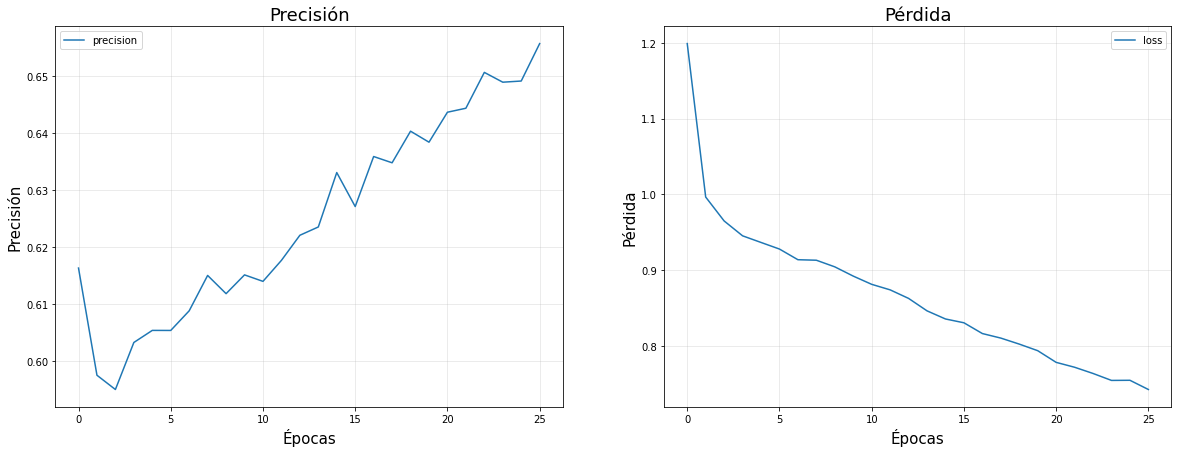

In [110]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Precision
best_cv_2 = load_model('model_ent73.h5')
plt.plot(hist_entities_.iloc[0, 1].epoch, hist_entities_.iloc[0, 1].history['precision'], label = "precision")

plt.title("Precisión", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Precisión", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Pérdida
fig.add_subplot(122)

plt.plot(hist_entities_.iloc[0, 1].epoch, hist_entities_.iloc[0, 1].history['loss'], label="loss")

plt.title("Pérdida", fontsize=18)
plt.xlabel("Épocas", fontsize=15)
plt.ylabel("Pérdida", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

Podemos ver claramente que el modelo paró en la época de mejor precisión y menor pérdida. No obstante, esta precisión sigue siendo muy baja con respecto a lo que esperaríamos para que sea un modelo realmente bueno. Veamos el reporte de clasificación y la matriz de confusión:

In [112]:
y_pred_2 = best_cv_2.predict(embedded_entities)
y_pred_2 = y_pred_2.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 
Y_en = Y_ent.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 


print('---Reporte para el modelo construido---')
print(classification_report(Y_en, y_pred_2))

---Reporte para el modelo construido---
              precision    recall  f1-score   support

           1       0.71      0.81      0.76      2099
           2       0.52      0.78      0.62       988
           3       0.45      0.76      0.57      1208
           4       0.68      0.78      0.73      2014
           5       0.65      0.26      0.37      3112

    accuracy                           0.61      9421
   macro avg       0.60      0.68      0.61      9421
weighted avg       0.63      0.61      0.58      9421



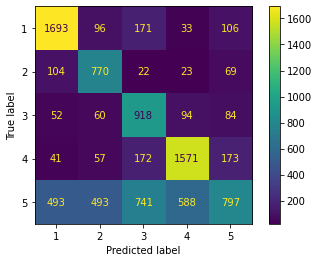

In [114]:
cm_2 = confusion_matrix(Y_en, y_pred_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels= np.arange(1,6))
disp_2.plot()
plt.show()

A diferencia del modelo anterior, este modelo tiene un rango de precisiones más variado. Notamos que la clasificación de la clase 1 es la mejor, mientras que la de la clase 3 está incluso por debajo del 50%. Por esta razón, y debido a que dado el contexto del problema queremos clasificar tan bien como se pueda de todas las clases, nos quedamos con el modelo en el que usamos BioSentVec.

Inferimos que quizá el wordembedding que utilizamos como preentrenamiento tenía una dimensionalidad muy grande, para haber sido únicamente tan pocas palabras. Este modelo queda, entonces, descartado.

Por lo tanto, como resultado de este notebook, nos quedamos con el modelo resultado de la validación cruzada 1, el cual se encuentra en el archivo ```model_94.h5``` para su validación con respecto a los otros modelos. Es importante anotar que decidimos también implementar un algoritmo con transfer learning, remítase a dicho cuaderno para visualizarlo.

## Bibliografía
---
[1] https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/

[2] https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

[3] Application of Long Short-Term Memory (LSTM) Neural Network for Flood Forecasting - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507 [accessed 28 Mar, 2022]

[4] Zhang Y, Chen Q, Yang Z, Lin H, Lu Z. BioWordVec, improving biomedical word embeddings with subword information and MeSH. Scientific Data. 2019.

[5] https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

[6] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

[7] https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e